## 1. Import Data

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import (
    chi2_contingency, fisher_exact, mannwhitneyu, ttest_ind, kruskal, f_oneway,
    shapiro, normaltest, anderson, kstest, pearsonr, spearmanr
)

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

from pandas.api.types import CategoricalDtype

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the saved patient list
final_patients = pd.read_csv('final_analysis_cohort.csv')
final_participant_list = final_patients['participant'].tolist()

# Load and prepare data (using exact same workflow as before)
metadata = pd.read_csv('UCSF-PDGM-metadata_v5_cleaned.csv')
tracts = pd.read_csv('UCSF-PDGM-v5_profiles_20250819.csv')
tumor_volumes = pd.read_csv('tumor_volumes.csv')

# Convert metadata IDs to match tract format
metadata['participant'] = 'sub-' + metadata['ID'].str.extract(r'UCSF-PDGM-(\d+)')[0].str.zfill(4)

# Merge datasets and FILTER TO FINAL PATIENTS ONLY
df = tracts.merge(metadata, on='participant', how='inner')
df = df[df['participant'].isin(final_participant_list)]

## Demographic and clinical comparisons

### Demographics table

In [3]:
# Create analysis variables with NEW GRADE DEFINITION
df['any_tumor'] = df[['TUMOR-1', 'TUMOR-2', 'TUMOR-4']].max(axis=1)
df['tumor_affected'] = (df['any_tumor'] > 0.05).astype(int)
df['hemisphere'] = df['tract'].str.extract('(Left|Right)')[0]

# NEW GRADE DEFINITION: Low grade = 2, High grade = 3 OR 4
df['grade_binary'] = (df['WHO CNS Grade'].isin([3, 4])).astype(int)  # Changed this line
df['grade_label'] = df['WHO CNS Grade'].map({2: 'Low', 3: 'High', 4: 'High'})  # Changed this line

print(f"\nFiltered dataset: {len(df):,} rows, {df['participant'].nunique()} subjects")
print(f"NEW Grade definition - Low (grade 2): {(df.groupby('participant')['grade_label'].first() == 'Low').sum()}")
print(f"NEW Grade definition - High (grade 3-4): {(df.groupby('participant')['grade_label'].first() == 'High').sum()}")

# Create subject-level summary for demographics
subject_data = df.groupby('participant').agg({
    'Age at MRI': 'first',
    'Sex': 'first', 
    'WHO CNS Grade': 'first',
    'grade_label': 'first',
    'Pathology': 'first',  # Add pathology
    'tumor_affected': 'sum'
}).reset_index()

# Add IDH column if it exists
idh_cols = [col for col in df.columns if 'IDH' in col]
if idh_cols:
    idh_col = idh_cols[0]
    subject_data[idh_col] = df.groupby('participant')[idh_col].first().values
else:
    idh_col = None

subject_data['total_nodes'] = df.groupby('participant').size().values
subject_data['tumor_proportion'] = subject_data['tumor_affected'] / subject_data['total_nodes']

# Process tumor volume data by component
tumor_vol_pivot = tumor_volumes.pivot_table(
    index='participant', 
    columns='tumor_label', 
    values=['tumor_volume', 'p_tumor_volume'], 
    aggfunc='sum', 
    fill_value=0
).reset_index()

# Flatten column names and rename for clarity
tumor_vol_pivot.columns = ['participant'] + [f'{metric}_{label}' for metric, label in tumor_vol_pivot.columns[1:]]

# Rename columns to match tumor components - check if columns exist first
volume_cols = {}
if 'tumor_volume_1' in tumor_vol_pivot.columns:
    volume_cols['tumor_volume_1'] = 'enhancing_volume'
if 'tumor_volume_2' in tumor_vol_pivot.columns:
    volume_cols['tumor_volume_2'] = 'edema_volume'
if 'tumor_volume_4' in tumor_vol_pivot.columns:
    volume_cols['tumor_volume_4'] = 'necrotic_volume'
if 'p_tumor_volume_1' in tumor_vol_pivot.columns:
    volume_cols['p_tumor_volume_1'] = 'p_enhancing_volume'
if 'p_tumor_volume_2' in tumor_vol_pivot.columns:
    volume_cols['p_tumor_volume_2'] = 'p_edema_volume'
if 'p_tumor_volume_4' in tumor_vol_pivot.columns:
    volume_cols['p_tumor_volume_4'] = 'p_necrotic_volume'

tumor_vol_pivot = tumor_vol_pivot.rename(columns=volume_cols)

# Add missing columns as zeros if they don't exist
expected_cols = ['enhancing_volume', 'edema_volume', 'necrotic_volume', 
                'p_enhancing_volume', 'p_edema_volume', 'p_necrotic_volume']
for col in expected_cols:
    if col not in tumor_vol_pivot.columns:
        tumor_vol_pivot[col] = 0

# Calculate total volumes
tumor_vol_pivot['total_volume'] = tumor_vol_pivot[['enhancing_volume', 'edema_volume', 'necrotic_volume']].sum(axis=1)
tumor_vol_pivot['p_total_volume'] = tumor_vol_pivot[['p_enhancing_volume', 'p_edema_volume', 'p_necrotic_volume']].sum(axis=1)

# Merge tumor volumes with subject data
subject_data = subject_data.merge(tumor_vol_pivot, on='participant', how='left')

print(f"Subject-level data: {len(subject_data)} subjects")
print(f"Subjects with tumor volume data: {subject_data['total_volume'].notna().sum()}")

def create_pathology_table_matched():
    """Create pathology comparison table for matched cohort with 3-way analyses"""
    
    print("\n" + "="*80)
    print("TABLE 1: DEMOGRAPHICS BY TUMOR PATHOLOGY (MATCHED COHORT)")
    print(f"Using {len(final_participant_list)} patients from asymmetry analysis")
    print("NEW GRADE DEFINITION: Low grade = WHO grade 2, High grade = WHO grade 3-4")
    print("="*80)
    
    # Filter to subjects with pathology data
    pathology_subjects = subject_data[subject_data['Pathology'].notna()]
    
    if len(pathology_subjects) == 0:
        print("No subjects with pathology data available")
        return
    
    print(f"Subjects with pathology data: {len(pathology_subjects)}")
    print(f"Pathology distribution:")
    print(pathology_subjects['Pathology'].value_counts())
    
    # Verify grade distribution with new definition
    print(f"\nGrade distribution with NEW definition:")
    print(f"Low grade (WHO grade 2): {(pathology_subjects['WHO CNS Grade'] == 2).sum()}")
    print(f"High grade (WHO grade 3-4): {(pathology_subjects['WHO CNS Grade'].isin([3,4])).sum()}")
    print(f"Grade distribution by pathology:")
    print(pd.crosstab(pathology_subjects['Pathology'], pathology_subjects['grade_label']))
    
    # Order pathologies for table
    pathology_order = ['Glioblastoma', 'Astrocytoma', 'Oligodendroglioma']
    available_pathologies = [p for p in pathology_order if p in pathology_subjects['Pathology'].values]
    
    pathology_stats = []
    
    for pathology in available_pathologies:
        path_subjects = pathology_subjects[pathology_subjects['Pathology'] == pathology]
        n = len(path_subjects)
        
        # Age statistics
        age_mean = path_subjects['Age at MRI'].mean()
        age_std = path_subjects['Age at MRI'].std()
        age_median = path_subjects['Age at MRI'].median()
        age_iqr = [path_subjects['Age at MRI'].quantile(0.25), 
                   path_subjects['Age at MRI'].quantile(0.75)]
        
        # Sex distribution
        sex_counts = path_subjects['Sex'].value_counts()
        sex_f = sex_counts.get('F', 0)
        sex_f_pct = (sex_f / n) * 100 if n > 0 else 0
        
        # Grade distribution with NEW definition
        grade_counts = path_subjects['grade_label'].value_counts()
        grade_low = grade_counts.get('Low', 0)  # Grade 2 only
        grade_high = grade_counts.get('High', 0)  # Grade 3-4
        grade_low_pct = (grade_low / n) * 100 if n > 0 else 0
        grade_high_pct = (grade_high / n) * 100 if n > 0 else 0
        
        # IDH distribution (if available)
        if idh_col:
            path_idh = path_subjects[path_subjects[idh_col].notna() & (path_subjects[idh_col] != 'unknown')]
            idh_mut = len(path_idh[path_idh[idh_col].str.contains('mutated', na=False)])
            idh_wt = len(path_idh[path_idh[idh_col].str.contains('wildtype', na=False)])
            idh_total = len(path_idh)
            idh_mut_pct = (idh_mut / idh_total) * 100 if idh_total > 0 else 0
            idh_wt_pct = (idh_wt / idh_total) * 100 if idh_total > 0 else 0
        else:
            idh_mut = idh_wt = idh_total = 0
            idh_mut_pct = idh_wt_pct = 0
        
        # Tumor involvement
        tumor_prop_mean = path_subjects['tumor_proportion'].mean()
        tumor_prop_std = path_subjects['tumor_proportion'].std()
        tumor_prop_median = path_subjects['tumor_proportion'].median()
        tumor_prop_iqr = [path_subjects['tumor_proportion'].quantile(0.25),
                         path_subjects['tumor_proportion'].quantile(0.75)]
        
        # Tumor volume statistics
        path_vol = path_subjects[path_subjects['total_volume'].notna()]
        vol_n = len(path_vol)
        
        volume_stats = {}
        volume_types = ['total_volume', 'p_total_volume', 'enhancing_volume', 'p_enhancing_volume', 
                       'edema_volume', 'p_edema_volume', 'necrotic_volume', 'p_necrotic_volume']
        
        for vol_type in volume_types:
            if vol_n > 0:
                volume_stats[f'{vol_type}_mean'] = path_vol[vol_type].mean()
                volume_stats[f'{vol_type}_std'] = path_vol[vol_type].std()
                volume_stats[f'{vol_type}_median'] = path_vol[vol_type].median()
                volume_stats[f'{vol_type}_iqr'] = [path_vol[vol_type].quantile(0.25),
                                                  path_vol[vol_type].quantile(0.75)]
            else:
                volume_stats[f'{vol_type}_mean'] = np.nan
                volume_stats[f'{vol_type}_std'] = np.nan
                volume_stats[f'{vol_type}_median'] = np.nan
                volume_stats[f'{vol_type}_iqr'] = [np.nan, np.nan]
        
        pathology_stats.append({
            'Pathology': pathology,
            'N': n,
            'Age_mean': age_mean,
            'Age_std': age_std,
            'Age_median': age_median,
            'Age_IQR': age_iqr,
            'Female_n': sex_f,
            'Female_pct': sex_f_pct,
            'Grade_low_n': grade_low,
            'Grade_low_pct': grade_low_pct,
            'Grade_high_n': grade_high,
            'Grade_high_pct': grade_high_pct,
            'IDH_mut_n': idh_mut,
            'IDH_mut_pct': idh_mut_pct,
            'IDH_wt_n': idh_wt,
            'IDH_wt_pct': idh_wt_pct,
            'IDH_total': idh_total,
            'Tumor_prop_mean': tumor_prop_mean,
            'Tumor_prop_std': tumor_prop_std,
            'Tumor_prop_median': tumor_prop_median,
            'Tumor_prop_IQR': tumor_prop_iqr,
            'Vol_n': vol_n,
            **volume_stats
        })
    
    # Print table header
    print(f"\n{'Characteristic':<25} {'Glioblastoma':<20} {'Astrocytoma':<20} {'Oligodendroglioma':<20} {'P-value':<10}")
    print("-" * 100)
    
    # Sample sizes
    gbm_stats = next((s for s in pathology_stats if s['Pathology'] == 'Glioblastoma'), None)
    astro_stats = next((s for s in pathology_stats if s['Pathology'] == 'Astrocytoma'), None)
    oligo_stats = next((s for s in pathology_stats if s['Pathology'] == 'Oligodendroglioma'), None)
    
    gbm_n = gbm_stats['N'] if gbm_stats else 0
    astro_n = astro_stats['N'] if astro_stats else 0
    oligo_n = oligo_stats['N'] if oligo_stats else 0
    
    print(f"{'N':<25} {gbm_n:<20} {astro_n:<20} {oligo_n:<20} {'':<10}")
    
    # Age comparison (3-way)
    if len([s for s in pathology_stats if s['N'] >= 5]) >= 2:
        age_groups = []
        for pathology in available_pathologies:
            path_data = pathology_subjects[pathology_subjects['Pathology'] == pathology]['Age at MRI'].dropna()
            if len(path_data) >= 5:
                age_groups.append(path_data)
        
        if len(age_groups) >= 2:
            if len(age_groups) >= 3:
                # Kruskal-Wallis for 3-way comparison
                age_stat, age_p = kruskal(*age_groups)
            else:
                # Mann-Whitney U for 2-way comparison
                age_stat, age_p = mannwhitneyu(age_groups[0], age_groups[1], alternative='two-sided')
        else:
            age_p = np.nan
    else:
        age_p = np.nan
    
    print(f"{'Age, years':<25} {'':<20} {'':<20} {'':<20} {'':<10}")
    
    if gbm_stats:
        gbm_age_str = f"{gbm_stats['Age_median']:.1f} [{gbm_stats['Age_IQR'][0]:.1f}-{gbm_stats['Age_IQR'][1]:.1f}]"
    else:
        gbm_age_str = "N/A"
    
    if astro_stats:
        astro_age_str = f"{astro_stats['Age_median']:.1f} [{astro_stats['Age_IQR'][0]:.1f}-{astro_stats['Age_IQR'][1]:.1f}]"
    else:
        astro_age_str = "N/A"
    
    if oligo_stats:
        oligo_age_str = f"{oligo_stats['Age_median']:.1f} [{oligo_stats['Age_IQR'][0]:.1f}-{oligo_stats['Age_IQR'][1]:.1f}]"
    else:
        oligo_age_str = "N/A"
    
    age_p_str = f"{age_p:.3f}" if not np.isnan(age_p) else "N/A"
    print(f"{'  Median [IQR]':<25} {gbm_age_str:<20} {astro_age_str:<20} {oligo_age_str:<20} {age_p_str:<10}")
    
    # Sex comparison (3-way chi-square)
    if len(available_pathologies) >= 2:
        try:
            sex_table = pd.crosstab(pathology_subjects['Pathology'], pathology_subjects['Sex'])
            sex_table = sex_table.reindex(available_pathologies, fill_value=0)
            if sex_table.shape[0] >= 2 and sex_table.shape[1] >= 2:
                chi2, sex_p, _, _ = chi2_contingency(sex_table)
            else:
                sex_p = np.nan
        except:
            sex_p = np.nan
    else:
        sex_p = np.nan
    
    sex_p_str = f"{sex_p:.3f}" if not np.isnan(sex_p) else "N/A"
    print(f"{'Sex, n (%)':<25} {'':<20} {'':<20} {'':<20} {sex_p_str:<10}")
    
    gbm_sex_str = f"{gbm_stats['Female_n']} ({gbm_stats['Female_pct']:.1f})" if gbm_stats else "N/A"
    astro_sex_str = f"{astro_stats['Female_n']} ({astro_stats['Female_pct']:.1f})" if astro_stats else "N/A"
    oligo_sex_str = f"{oligo_stats['Female_n']} ({oligo_stats['Female_pct']:.1f})" if oligo_stats else "N/A"
    
    print(f"{'  Female':<25} {gbm_sex_str:<20} {astro_sex_str:<20} {oligo_sex_str:<20} {'':<10}")
    
    # Grade comparison (3-way chi-square) with NEW definition
    if len(available_pathologies) >= 2:
        try:
            grade_table = pd.crosstab(pathology_subjects['Pathology'], pathology_subjects['grade_label'])
            grade_table = grade_table.reindex(available_pathologies, fill_value=0)
            if grade_table.shape[0] >= 2 and grade_table.shape[1] >= 2:
                chi2, grade_p, _, _ = chi2_contingency(grade_table)
            else:
                grade_p = np.nan
        except:
            grade_p = np.nan
    else:
        grade_p = np.nan
    
    grade_p_str = f"{grade_p:.3f}" if not np.isnan(grade_p) else "N/A"
    print(f"{'WHO CNS Grade':<25} {'':<20} {'':<20} {'':<20} {grade_p_str:<10}")
    
    gbm_low_str = f"{gbm_stats['Grade_low_n']} ({gbm_stats['Grade_low_pct']:.1f})" if gbm_stats else "N/A"
    astro_low_str = f"{astro_stats['Grade_low_n']} ({astro_stats['Grade_low_pct']:.1f})" if astro_stats else "N/A"
    oligo_low_str = f"{oligo_stats['Grade_low_n']} ({oligo_stats['Grade_low_pct']:.1f})" if oligo_stats else "N/A"
    
    gbm_high_str = f"{gbm_stats['Grade_high_n']} ({gbm_stats['Grade_high_pct']:.1f})" if gbm_stats else "N/A"
    astro_high_str = f"{astro_stats['Grade_high_n']} ({astro_stats['Grade_high_pct']:.1f})" if astro_stats else "N/A"
    oligo_high_str = f"{oligo_stats['Grade_high_n']} ({oligo_stats['Grade_high_pct']:.1f})" if oligo_stats else "N/A"
    
    print(f"{'  Low grade (2), n (%)':<25} {gbm_low_str:<20} {astro_low_str:<20} {oligo_low_str:<20} {'':<10}")
    print(f"{'  High grade (3-4), n (%)':<25} {gbm_high_str:<20} {astro_high_str:<20} {oligo_high_str:<20} {'':<10}")
    
    # IDH comparison (if data available)
    if idh_col and any(s['IDH_total'] > 0 for s in pathology_stats):
        # Filter to subjects with IDH data
        path_idh_subjects = pathology_subjects[pathology_subjects[idh_col].notna() & 
                                             (pathology_subjects[idh_col] != 'unknown')]
        
        if len(path_idh_subjects) >= 10 and len(available_pathologies) >= 2:
            try:
                idh_table = pd.crosstab(path_idh_subjects['Pathology'], path_idh_subjects[idh_col])
                idh_table = idh_table.reindex([p for p in available_pathologies if p in idh_table.index], fill_value=0)
                if idh_table.shape[0] >= 2 and idh_table.shape[1] >= 2:
                    chi2, idh_p, _, _ = chi2_contingency(idh_table)
                else:
                    idh_p = np.nan
            except:
                idh_p = np.nan
        else:
            idh_p = np.nan
        
        idh_p_str = f"{idh_p:.3f}" if not np.isnan(idh_p) else "N/A"
        print(f"{'IDH status, n (%)*':<25} {'':<20} {'':<20} {'':<20} {idh_p_str:<10}")
        
        gbm_mut_str = f"{gbm_stats['IDH_mut_n']} ({gbm_stats['IDH_mut_pct']:.1f})" if gbm_stats and gbm_stats['IDH_total'] > 0 else "N/A"
        astro_mut_str = f"{astro_stats['IDH_mut_n']} ({astro_stats['IDH_mut_pct']:.1f})" if astro_stats and astro_stats['IDH_total'] > 0 else "N/A"
        oligo_mut_str = f"{oligo_stats['IDH_mut_n']} ({oligo_stats['IDH_mut_pct']:.1f})" if oligo_stats and oligo_stats['IDH_total'] > 0 else "N/A"
        
        gbm_wt_str = f"{gbm_stats['IDH_wt_n']} ({gbm_stats['IDH_wt_pct']:.1f})" if gbm_stats and gbm_stats['IDH_total'] > 0 else "N/A"
        astro_wt_str = f"{astro_stats['IDH_wt_n']} ({astro_stats['IDH_wt_pct']:.1f})" if astro_stats and astro_stats['IDH_total'] > 0 else "N/A"
        oligo_wt_str = f"{oligo_stats['IDH_wt_n']} ({oligo_stats['IDH_wt_pct']:.1f})" if oligo_stats and oligo_stats['IDH_total'] > 0 else "N/A"
        
        print(f"{'  Mutated':<25} {gbm_mut_str:<20} {astro_mut_str:<20} {oligo_mut_str:<20} {'':<10}")
        print(f"{'  Wildtype':<25} {gbm_wt_str:<20} {astro_wt_str:<20} {oligo_wt_str:<20} {'':<10}")
        
        gbm_idh_n = gbm_stats['IDH_total'] if gbm_stats else 0
        astro_idh_n = astro_stats['IDH_total'] if astro_stats else 0
        oligo_idh_n = oligo_stats['IDH_total'] if oligo_stats else 0
        
        print(f"{'  *of those with IDH data':<25} n={gbm_idh_n:<17} n={astro_idh_n:<17} n={oligo_idh_n:<17} {'':<10}")
    
    # Tumor involvement comparison (3-way)
    tumor_groups = []
    for pathology in available_pathologies:
        path_data = pathology_subjects[pathology_subjects['Pathology'] == pathology]['tumor_proportion'].dropna()
        if len(path_data) >= 5:
            tumor_groups.append(path_data)
    
    if len(tumor_groups) >= 2:
        if len(tumor_groups) >= 3:
            # Kruskal-Wallis for 3-way comparison
            tumor_stat, tumor_p = kruskal(*tumor_groups)
        else:
            # Mann-Whitney U for 2-way comparison
            tumor_stat, tumor_p = mannwhitneyu(tumor_groups[0], tumor_groups[1], alternative='two-sided')
    else:
        tumor_p = np.nan
    
    tumor_p_str = f"{tumor_p:.3f}" if not np.isnan(tumor_p) else "N/A"
    print(f"{'Tumor involvement':<25} {'':<20} {'':<20} {'':<20} {tumor_p_str:<10}")
    
    gbm_tumor_str = f"{gbm_stats['Tumor_prop_median']:.3f} [{gbm_stats['Tumor_prop_IQR'][0]:.3f}-{gbm_stats['Tumor_prop_IQR'][1]:.3f}]" if gbm_stats else "N/A"
    astro_tumor_str = f"{astro_stats['Tumor_prop_median']:.3f} [{astro_stats['Tumor_prop_IQR'][0]:.3f}-{astro_stats['Tumor_prop_IQR'][1]:.3f}]" if astro_stats else "N/A"
    oligo_tumor_str = f"{oligo_stats['Tumor_prop_median']:.3f} [{oligo_stats['Tumor_prop_IQR'][0]:.3f}-{oligo_stats['Tumor_prop_IQR'][1]:.3f}]" if oligo_stats else "N/A"
    
    print(f"{'  Median [IQR]':<25} {gbm_tumor_str:<20} {astro_tumor_str:<20} {oligo_tumor_str:<20} {'':<10}")
    
    # Tumor volume comparisons (3-way)
    vol_subjects_by_path = {}
    for pathology in available_pathologies:
        vol_subjects_by_path[pathology] = pathology_subjects[
            (pathology_subjects['Pathology'] == pathology) & 
            (pathology_subjects['total_volume'].notna())
        ]
    
    if sum(len(vs) > 0 for vs in vol_subjects_by_path.values()) >= 2:
        # Total normalized volume
        vol_groups = []
        for pathology in available_pathologies:
            vol_data = vol_subjects_by_path[pathology]['p_total_volume'].dropna()
            if len(vol_data) >= 3:
                vol_groups.append(vol_data)
        
        if len(vol_groups) >= 2:
            if len(vol_groups) >= 3:
                vol_stat, vol_p = kruskal(*vol_groups)
            else:
                vol_stat, vol_p = mannwhitneyu(vol_groups[0], vol_groups[1], alternative='two-sided')
        else:
            vol_p = np.nan
        
        vol_p_str = f"{vol_p:.5f}" if not np.isnan(vol_p) else "N/A"
        print(f"{'Norm. tumor volume*':<25} {'':<20} {'':<20} {'':<20} {vol_p_str:<10}")
        
        gbm_vol_str = f"{gbm_stats['p_total_volume_median']:.5f} [{gbm_stats['p_total_volume_iqr'][0]:.5f}-{gbm_stats['p_total_volume_iqr'][1]:.5f}]" if gbm_stats and gbm_stats['Vol_n'] > 0 else "N/A"
        astro_vol_str = f"{astro_stats['p_total_volume_median']:.5f} [{astro_stats['p_total_volume_iqr'][0]:.5f}-{astro_stats['p_total_volume_iqr'][1]:.5f}]" if astro_stats and astro_stats['Vol_n'] > 0 else "N/A"
        oligo_vol_str = f"{oligo_stats['p_total_volume_median']:.5f} [{oligo_stats['p_total_volume_iqr'][0]:.5f}-{oligo_stats['p_total_volume_iqr'][1]:.5f}]" if oligo_stats and oligo_stats['Vol_n'] > 0 else "N/A"
        
        print(f"{'  Total':<25} {gbm_vol_str:<20} {astro_vol_str:<20} {oligo_vol_str:<20} {'':<10}")
        
        # Component-specific volumes
        components = [('enhancing', 'Enhancing'), ('edema', 'Edema'), ('necrotic', 'Necrotic')]
        for comp_short, comp_name in components:
            # 3-way comparison for this component
            comp_groups = []
            for pathology in available_pathologies:
                comp_data = vol_subjects_by_path[pathology][f'p_{comp_short}_volume'].dropna()
                if len(comp_data) >= 3:
                    comp_groups.append(comp_data)
            
            if len(comp_groups) >= 2:
                if len(comp_groups) >= 3:
                    comp_stat, comp_p = kruskal(*comp_groups)
                else:
                    comp_stat, comp_p = mannwhitneyu(comp_groups[0], comp_groups[1], alternative='two-sided')
            else:
                comp_p = np.nan
            
            comp_p_str = f"{comp_p:.5f}" if not np.isnan(comp_p) else "N/A"
            
            gbm_comp_str = f"{gbm_stats[f'p_{comp_short}_volume_median']:.5f} [{gbm_stats[f'p_{comp_short}_volume_iqr'][0]:.5f}-{gbm_stats[f'p_{comp_short}_volume_iqr'][1]:.5f}]" if gbm_stats and gbm_stats['Vol_n'] > 0 else "N/A"
            astro_comp_str = f"{astro_stats[f'p_{comp_short}_volume_median']:.5f} [{astro_stats[f'p_{comp_short}_volume_iqr'][0]:.5f}-{astro_stats[f'p_{comp_short}_volume_iqr'][1]:.5f}]" if astro_stats and astro_stats['Vol_n'] > 0 else "N/A"
            oligo_comp_str = f"{oligo_stats[f'p_{comp_short}_volume_median']:.5f} [{oligo_stats[f'p_{comp_short}_volume_iqr'][0]:.5f}-{oligo_stats[f'p_{comp_short}_volume_iqr'][1]:.5f}]" if oligo_stats and oligo_stats['Vol_n'] > 0 else "N/A"
            
            print(f"{f'  {comp_name}':<25} {gbm_comp_str:<20} {astro_comp_str:<20} {oligo_comp_str:<20} {comp_p_str:<10}")
        
        gbm_vol_n = gbm_stats['Vol_n'] if gbm_stats else 0
        astro_vol_n = astro_stats['Vol_n'] if astro_stats else 0
        oligo_vol_n = oligo_stats['Vol_n'] if oligo_stats else 0
        
        print(f"{'  *volume data available':<25} n={gbm_vol_n:<17} n={astro_vol_n:<17} n={oligo_vol_n:<17} {'':<10}")
    else:
        print("Insufficient tumor volume data for pathology comparison")
    
    print(f"\n{'='*80}")
    print("NOTE: Grade definition changed for this analysis:")
    print("• Low grade = WHO CNS Grade 2 only")
    print("• High grade = WHO CNS Grade 3 OR 4")
    print("• This better reflects biological distinctions in tumor behavior")
    print(f"{'='*80}")
    
    return pathology_stats

# Run the pathology analysis
print("Creating Table 1 for Matched Cohort: Demographics by Tumor Pathology")
print("Using NEW grade definition: Low = grade 2, High = grade 3-4")
print("Using 3-way statistical comparisons")

pathology_stats = create_pathology_table_matched()


Filtered dataset: 928,800 rows, 459 subjects
NEW Grade definition - Low (grade 2): 42
NEW Grade definition - High (grade 3-4): 417
Subject-level data: 459 subjects
Subjects with tumor volume data: 459
Creating Table 1 for Matched Cohort: Demographics by Tumor Pathology
Using NEW grade definition: Low = grade 2, High = grade 3-4
Using 3-way statistical comparisons

TABLE 1: DEMOGRAPHICS BY TUMOR PATHOLOGY (MATCHED COHORT)
Using 459 patients from asymmetry analysis
NEW GRADE DEFINITION: Low grade = WHO grade 2, High grade = WHO grade 3-4
Subjects with pathology data: 459
Pathology distribution:
Pathology
Glioblastoma         361
Astrocytoma           87
Oligodendroglioma     11
Name: count, dtype: int64

Grade distribution with NEW definition:
Low grade (WHO grade 2): 42
High grade (WHO grade 3-4): 417
Grade distribution by pathology:
grade_label        High  Low
Pathology                   
Astrocytoma          54   33
Glioblastoma        361    0
Oligodendroglioma     2    9

Characte

### Check presence of tumor component volumes

In [4]:
# Check all tumor components for zero medians - PATHOLOGY ANALYSIS
astrocytoma_subjects = subject_data[subject_data['Pathology'] == 'Astrocytoma']
oligodendroglioma_subjects = subject_data[subject_data['Pathology'] == 'Oligodendroglioma']

print("="*60)
print("TUMOR VOLUME COMPONENT ANALYSIS - PATHOLOGY")
print("="*60)

print("Astrocytoma enhancing volume:")
enhancing_astro = astrocytoma_subjects['p_enhancing_volume'] 
print(f"Count > 0: {(enhancing_astro > 0).sum()}/{len(enhancing_astro)} ({(enhancing_astro > 0).mean()*100:.1f}%)")

print("\nAstrocytoma necrotic volume:")
necrotic_astro = astrocytoma_subjects['p_necrotic_volume'] 
print(f"Count > 0: {(necrotic_astro > 0).sum()}/{len(necrotic_astro)} ({(necrotic_astro > 0).mean()*100:.1f}%)")

print("\nOligodendroglioma enhancing volume:")
enhancing_oligo = oligodendroglioma_subjects['p_enhancing_volume']
print(f"Count > 0: {(enhancing_oligo > 0).sum()}/{len(enhancing_oligo)} ({(enhancing_oligo > 0).mean()*100:.1f}%)")

print("\nOligodendroglioma necrotic volume:")  
necrotic_oligo = oligodendroglioma_subjects['p_necrotic_volume']
print(f"Count > 0: {(necrotic_oligo > 0).sum()}/{len(necrotic_oligo)} ({(necrotic_oligo > 0).mean()*100:.1f}%)")

print("\n" + "="*60)
print("EXPECTED PATTERNS:")
print("• Astrocytoma: Typically non-enhancing, minimal necrosis")
print("• Oligodendroglioma: Variable enhancement, minimal necrosis")
print("• Both should have lower enhancement/necrosis rates than GBM")
print("="*60)

TUMOR VOLUME COMPONENT ANALYSIS - PATHOLOGY
Astrocytoma enhancing volume:
Count > 0: 33/87 (37.9%)

Astrocytoma necrotic volume:
Count > 0: 41/87 (47.1%)

Oligodendroglioma enhancing volume:
Count > 0: 1/11 (9.1%)

Oligodendroglioma necrotic volume:
Count > 0: 4/11 (36.4%)

EXPECTED PATTERNS:
• Astrocytoma: Typically non-enhancing, minimal necrosis
• Oligodendroglioma: Variable enhancement, minimal necrosis
• Both should have lower enhancement/necrosis rates than GBM


## Analysis of Direct Tumor Involvement

### % Subjects with Tumor Involvement for Each Tract

Filtered data: 928800 rows from 459 subjects

Pathology distribution:
Pathology
Glioblastoma         361
Astrocytoma           87
Oligodendroglioma     11
Name: count, dtype: int64

Pathology analysis dataset: 4589 tract observations from 459 subjects
Pathology distribution in analysis:
pathology
Glioblastoma         361
Astrocytoma           87
Oligodendroglioma     11
Name: count, dtype: int64


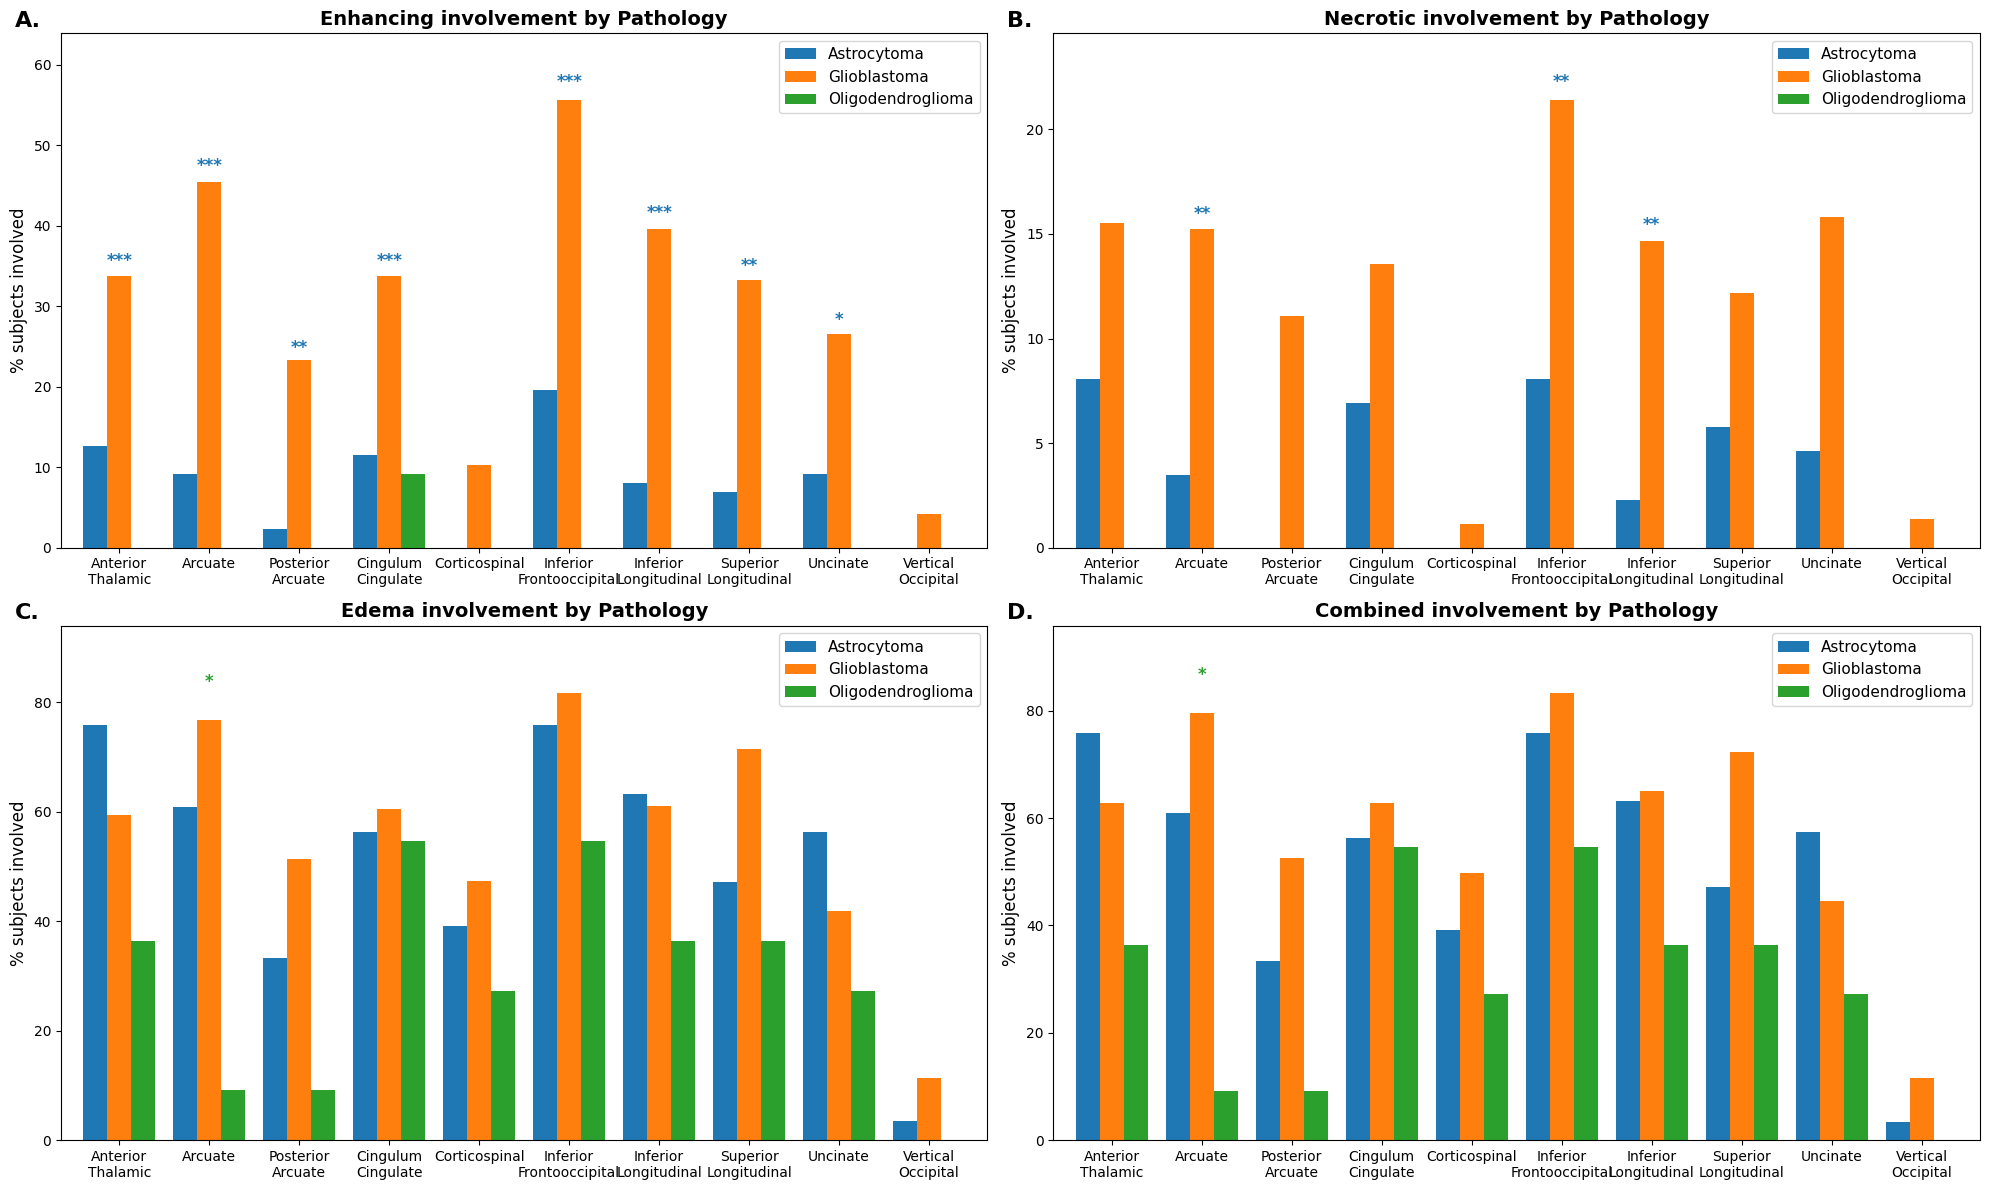


3-GROUP PATHOLOGY ANALYSIS - SIGNIFICANT DIFFERENCES (FDR-ADJUSTED)
Reference Group: Glioblastoma (odds ratio = 1.0)

Astrocytoma vs vs vs Glioblastoma:
  • Enhancing - Anterior Thalamic: Astrocytoma 12.6% vs Glioblastoma 33.8% (OR=0.19, q=0.0001)
  • Enhancing - Arcuate: Astrocytoma 9.2% vs Glioblastoma 45.4% (OR=0.11, q=0.0000)
  • Necrotic - Arcuate: Astrocytoma 3.4% vs Glioblastoma 15.2% (OR=0.13, q=0.0091)
  • Enhancing - Posterior Arcuate: Astrocytoma 2.3% vs Glioblastoma 23.3% (OR=0.08, q=0.0014)
  • Enhancing - Cingulum Cingulate: Astrocytoma 11.5% vs Glioblastoma 33.8% (OR=0.20, q=0.0002)
  • Enhancing - Inferior Frontooccipital: Astrocytoma 19.5% vs Glioblastoma 55.6% (OR=0.18, q=0.0000)
  • Necrotic - Inferior Frontooccipital: Astrocytoma 8.0% vs Glioblastoma 21.4% (OR=0.24, q=0.0091)
  • Enhancing - Inferior Longitudinal: Astrocytoma 8.0% vs Glioblastoma 39.6% (OR=0.12, q=0.0000)
  • Necrotic - Inferior Longitudinal: Astrocytoma 2.3% vs Glioblastoma 14.7% (OR=0.09, q=0.009

In [5]:
# Load data
metadata = pd.read_csv('UCSF-PDGM-metadata_v5_cleaned.csv')
tracts = pd.read_csv('UCSF-PDGM-v5_profiles_20250819.csv')
final_patients = pd.read_csv('final_analysis_cohort.csv')

# ID matching functions
def extract_subject_num_meta(subject_id):
    if pd.isna(subject_id):
        return None
    import re
    match = re.search(r'PDGM-(\d+)', str(subject_id))
    if match:
        num_str = match.group(1)
        if len(num_str) == 3:
            return f"0{num_str}"
        return num_str
    return None

def extract_subject_num_tract(participant_id):
    if pd.isna(participant_id):
        return None
    import re
    match = re.search(r'sub-(\d+)', str(participant_id))
    return match.group(1) if match else None

# Add matching columns
metadata['subject_num'] = metadata['ID'].apply(extract_subject_num_meta)
tracts['subject_num'] = tracts['participant'].apply(extract_subject_num_tract)
final_patients['subject_num'] = final_patients['participant'].apply(extract_subject_num_tract)

# Filter to final cohort
final_cohort_nums = set(final_patients['subject_num'].dropna())
metadata_filtered = metadata[metadata['subject_num'].isin(final_cohort_nums)].copy()
tracts_filtered = tracts[tracts['subject_num'].isin(final_cohort_nums)].copy()

# Merge to create df
df = pd.merge(tracts_filtered, metadata_filtered, on='subject_num', how='inner')
df_filtered = df[df['participant'].isin(final_patients['participant'])].copy()
print(f"Filtered data: {len(df_filtered)} rows from {df_filtered['participant'].nunique()} subjects")

# Check pathology distribution
print("\nPathology distribution:")
pathology_counts = df_filtered.groupby('participant')['Pathology'].first().value_counts()
print(pathology_counts)

# Config
THRESH = 0.05
COMPARTMENTS_BASE = {
    'Enhancing': 'TUMOR-4',
    'Necrotic':  'TUMOR-1',
    'Edema':     'TUMOR-2',
}
COMPARTMENTS_FOR_PLOTTING = ['Enhancing','Necrotic','Edema','Combined']

COMBINE_TRACTS = {
    'Anterior Thalamic': ['LeftAnteriorThalamic','RightAnteriorThalamic'],
    'Arcuate': ['LeftArcuate','RightArcuate'],
    'Posterior Arcuate': ['LeftPosteriorArcuate','RightPosteriorArcuate'],
    'Cingulum Cingulate': ['LeftCingulumCingulate','RightCingulumCingulate'],
    'Corticospinal': ['LeftCorticospinal','RightCorticospinal'],
    'Inferior Frontooccipital': ['LeftInferiorFrontooccipital','RightInferiorFrontooccipital'],
    'Inferior Longitudinal': ['LeftInferiorLongitudinal','RightInferiorLongitudinal'],
    'Superior Longitudinal': ['LeftSuperiorLongitudinal','RightSuperiorLongitudinal'],
    'Uncinate': ['LeftUncinate','RightUncinate'],
    'Vertical Occipital': ['LeftVerticalOccipital','RightVerticalOccipital'],
}
TRACT_ORDER_COMBINED = list(COMBINE_TRACTS.keys())

# Subject-level binary involvement for PATHOLOGY analysis
def build_subject_flags_pathology(node_df: pd.DataFrame, thresh=0.05) -> pd.DataFrame:
    rows = []
    for (pid, tract), g in node_df.groupby(['participant','tract'], sort=False):
        rec = {'participant': pid, 'tract': tract}
        # Raw compartment involvement
        for comp_name, col in COMPARTMENTS_BASE.items():
            rec[comp_name] = int((g[col] > thresh).any())
        rec['Combined'] = int(any(rec[c] for c in COMPARTMENTS_BASE.keys()))
        
        # Pathology and covariates
        rec['pathology'] = str(g['Pathology'].iloc[0])
        rec['Age_at_MRI'] = pd.to_numeric(g['Age at MRI'], errors='coerce').iloc[0] if 'Age at MRI' in g else np.nan
        rec['sex_binary'] = int(str(g['Sex'].iloc[0]).upper().startswith('M')) if 'Sex' in g else np.nan
        
        rows.append(rec)
    return pd.DataFrame(rows)

# Collapse tracts function for pathology
def collapse_tracts_pathology(st_df: pd.DataFrame, combine_map: dict) -> pd.DataFrame:
    out = []
    for pid, sub in st_df.groupby('participant', sort=False):
        base = {
            'participant': pid,
            'pathology': sub['pathology'].iloc[0],
            'Age_at_MRI': sub['Age_at_MRI'].iloc[0] if 'Age_at_MRI' in sub.columns else np.nan,
            'sex_binary': sub['sex_binary'].iloc[0] if 'sex_binary' in sub.columns else np.nan,
        }
        for tract_name, children in combine_map.items():
            child = sub[sub['tract'].isin(children)]
            if child.empty: 
                continue
            row = base.copy()
            row['tract'] = tract_name
            for comp in COMPARTMENTS_FOR_PLOTTING:
                row[comp] = int(child[comp].any())
            out.append(row)
    return pd.DataFrame(out)

# 3-group logistic regression with dummy coding (Glioblastoma as reference)
def logistic_pvals_pathology_3group(st_df: pd.DataFrame, tracts, comps) -> pd.DataFrame:
    """
    Run 3-group logistic regression with Glioblastoma as reference
    Creates dummy variables: astro_dummy, oligo_dummy (GBM = reference = 0,0)
    """
    rows = []
    
    for tract in tracts:
        tract_data = st_df[st_df['tract'] == tract].copy()
        if tract_data.empty or tract_data['pathology'].nunique() < 2:
            for comp in comps:
                rows.append({
                    'tract': tract, 'comp': comp,
                    'comparison': 'Astrocytoma_vs_Glioblastoma', 'p': np.nan, 'odds_ratio': np.nan
                })
                rows.append({
                    'tract': tract, 'comp': comp, 
                    'comparison': 'Oligodendroglioma_vs_Glioblastoma', 'p': np.nan, 'odds_ratio': np.nan
                })
            continue
            
        # Create dummy variables with Glioblastoma as reference
        tract_data['astro_dummy'] = (tract_data['pathology'] == 'Astrocytoma').astype(int)
        tract_data['oligo_dummy'] = (tract_data['pathology'] == 'Oligodendroglioma').astype(int)
        
        for comp in comps:
            y = tract_data[comp].astype(int)
            if y.nunique() < 2:
                rows.append({
                    'tract': tract, 'comp': comp,
                    'comparison': 'Astrocytoma_vs_Glioblastoma', 'p': np.nan, 'odds_ratio': np.nan
                })
                rows.append({
                    'tract': tract, 'comp': comp,
                    'comparison': 'Oligodendroglioma_vs_Glioblastoma', 'p': np.nan, 'odds_ratio': np.nan
                })
                continue
            
            # Prepare design matrix: dummy variables + age + sex
            X = tract_data[['astro_dummy', 'oligo_dummy', 'Age_at_MRI', 'sex_binary']].copy()
            mask = X.notna().all(axis=1)
            X = X.loc[mask]
            yy = y.loc[mask]
            
            if X.empty or yy.nunique() < 2 or len(X) < 15:
                rows.append({
                    'tract': tract, 'comp': comp,
                    'comparison': 'Astrocytoma_vs_Glioblastoma', 'p': np.nan, 'odds_ratio': np.nan
                })
                rows.append({
                    'tract': tract, 'comp': comp,
                    'comparison': 'Oligodendroglioma_vs_Glioblastoma', 'p': np.nan, 'odds_ratio': np.nan
                })
                continue
            
            X = sm.add_constant(X, has_constant='add')
            try:
                fit = sm.GLM(yy, X, family=sm.families.Binomial()).fit()
                
                # Extract p-values and odds ratios for each comparison vs Glioblastoma
                p_astro = float(fit.pvalues.get('astro_dummy', np.nan))
                p_oligo = float(fit.pvalues.get('oligo_dummy', np.nan))
                
                # Get odds ratios
                or_astro = np.exp(fit.params.get('astro_dummy', np.nan))
                or_oligo = np.exp(fit.params.get('oligo_dummy', np.nan))
                
                rows.append({
                    'tract': tract, 'comp': comp,
                    'comparison': 'Astrocytoma_vs_Glioblastoma', 
                    'p': p_astro, 'odds_ratio': or_astro
                })
                rows.append({
                    'tract': tract, 'comp': comp,
                    'comparison': 'Oligodendroglioma_vs_Glioblastoma', 
                    'p': p_oligo, 'odds_ratio': or_oligo
                })
                
            except Exception as e:
                print(f"Model failed for {tract}, {comp}: {e}")
                rows.append({
                    'tract': tract, 'comp': comp,
                    'comparison': 'Astrocytoma_vs_Glioblastoma', 'p': np.nan, 'odds_ratio': np.nan
                })
                rows.append({
                    'tract': tract, 'comp': comp,
                    'comparison': 'Oligodendroglioma_vs_Glioblastoma', 'p': np.nan, 'odds_ratio': np.nan
                })
    
    return pd.DataFrame(rows)

def add_fdr_pathology_3group(pval_df: pd.DataFrame, alpha=0.05) -> pd.DataFrame:
    """
    Apply FDR correction within each comparison and component
    """
    out = pval_df.copy()
    out['q'] = np.nan
    out['sig'] = False
    
    # Apply FDR correction within each comparison-component combination
    for comparison in out['comparison'].dropna().unique():
        for comp in out['comp'].dropna().unique():
            mask = (out['comparison'] == comparison) & (out['comp'] == comp) & out['p'].notna()
            if mask.any():
                reject, qvals, _, _ = multipletests(out.loc[mask, 'p'].values, alpha=alpha, method='fdr_bh')
                out.loc[mask, 'q'] = qvals
                out.loc[mask, 'sig'] = reject
    
    return out

# Build pathology dataset
st_path = build_subject_flags_pathology(df_filtered, THRESH)
st_path_col = collapse_tracts_pathology(st_path, COMBINE_TRACTS)

# Filter out any missing pathology data
st_path_col = st_path_col[st_path_col['pathology'].notna()].copy()

print(f"\nPathology analysis dataset: {len(st_path_col)} tract observations from {st_path_col['participant'].nunique()} subjects")
print("Pathology distribution in analysis:")
print(st_path_col.groupby('participant')['pathology'].first().value_counts())

# Calculate proportions by pathology
prop_summary_path = (
    st_path_col.groupby(['tract','pathology'])[COMPARTMENTS_FOR_PLOTTING]
    .mean()
    .reset_index()
)
prop_summary_path[COMPARTMENTS_FOR_PLOTTING] *= 100.0

# Calculate p-values and FDR for pathology comparisons using 3-group approach
pvals_path = logistic_pvals_pathology_3group(st_path_col, TRACT_ORDER_COMBINED, COMPARTMENTS_FOR_PLOTTING)
pvals_path_fdr = add_fdr_pathology_3group(pvals_path, alpha=0.05)

# Combined plot function for pathology
def format_sig_q(q):
    if pd.isna(q): return ''
    elif q < 0.001: return '***'
    elif q < 0.01:  return '**'
    elif q < 0.05:  return '*'
    else: return ''

def plot_pathology_analysis():
    fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharey=False)
    
    # Define colors for each pathology type
    colors = {'Astrocytoma': '#1f77b4', 'Glioblastoma': '#ff7f0e', 'Oligodendroglioma': '#2ca02c'}
    
    for i, comp in enumerate(COMPARTMENTS_FOR_PLOTTING):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        
        sub = prop_summary_path[['tract','pathology',comp]].copy()
        pivot = sub.pivot(index='tract', columns='pathology', values=comp)
        
        # Ensure all pathology types are present
        for path_type in ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']:
            if path_type not in pivot.columns:
                pivot[path_type] = np.nan
        
        pivot = pivot.reindex(TRACT_ORDER_COMBINED)
        pivot.index = pivot.index.str.replace(" ", "\n")
        
        # Create bar plot with custom colors
        pivot[['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']].plot(
            kind='bar', ax=ax, width=0.8, 
            color=[colors[col] for col in ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']]
        )
        
        ax.set_title(f"{comp} involvement by Pathology", fontsize=14, fontweight='bold')
        ax.set_ylabel('% subjects involved', fontsize=12)
        ax.set_xlabel('')
        ax.legend(title="", fontsize=11)

        # Add panel label
        label = chr(65 + i) + '.'  # A., B., C., D.
        ax.text(-0.05, 1.005, label, transform=ax.transAxes, fontsize=16, fontweight='bold', 
                verticalalignment='bottom', horizontalalignment='left')

        ymax = float(np.nanmax(pivot.values)) if np.isfinite(np.nanmax(pivot.values)) else 100.0
        ax.set_ylim(0, ymax * 1.15)  # Extra space for significance stars

        # Add significance stars for each comparison vs Glioblastoma (reference)
        comparisons = ['Astrocytoma_vs_Glioblastoma', 'Oligodendroglioma_vs_Glioblastoma']
        star_colors = ['#1f77b4', '#2ca02c']  # Colors matching the pathology types being compared
        
        for j, tract in enumerate(pivot.index):
            tract_clean = tract.replace("\n", " ")
            
            # Position stars at different heights
            base_height = float(np.nanmax(pivot.loc[tract].values)) if np.isfinite(np.nanmax(pivot.loc[tract].values)) else ymax * 0.8
            
            for k, (comparison, star_color) in enumerate(zip(comparisons, star_colors)):
                row_data = pvals_path_fdr[(pvals_path_fdr['tract'] == tract_clean) & 
                                         (pvals_path_fdr['comp'] == comp) & 
                                         (pvals_path_fdr['comparison'] == comparison)]
                if not row_data.empty and 'q' in row_data.columns:
                    q = row_data['q'].values[0]
                    mark = format_sig_q(q)
                    if mark:
                        star_y = base_height * (1.02 + k * 0.05)  # Offset vertically for multiple comparisons
                        ax.text(j, star_y, mark, ha='center', va='bottom',
                                fontsize=12, fontweight='bold', color=star_color)

        ax.tick_params(axis='x', labelrotation=0, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    plt.show()

# Run the pathology analysis
plot_pathology_analysis()

# Print summary
print("\n" + "="*70)
print("3-GROUP PATHOLOGY ANALYSIS - SIGNIFICANT DIFFERENCES (FDR-ADJUSTED)")
print("Reference Group: Glioblastoma (odds ratio = 1.0)")
print("="*70)

# Print results for each comparison
comparisons = ['Astrocytoma_vs_Glioblastoma', 'Oligodendroglioma_vs_Glioblastoma']

for comparison in comparisons:
    print(f"\n{comparison.replace('_', ' vs ')}:")
    sig_results = pvals_path_fdr[(pvals_path_fdr['comparison'] == comparison) & 
                                (pvals_path_fdr['sig'] == True)].copy()
    
    if len(sig_results) > 0:
        for _, row in sig_results.iterrows():
            # Get the proportions for this tract and component
            tract_props = prop_summary_path[prop_summary_path['tract'] == row['tract']]
            
            comp_props = tract_props[['pathology', row['comp']]].set_index('pathology')[row['comp']]
            
            gbm_pct = comp_props.get('Glioblastoma', np.nan)
            if comparison == 'Astrocytoma_vs_Glioblastoma':
                other_pct = comp_props.get('Astrocytoma', np.nan)
                other_name = 'Astrocytoma'
            else:
                other_pct = comp_props.get('Oligodendroglioma', np.nan)
                other_name = 'Oligodendroglioma'
            
            if not (np.isnan(gbm_pct) or np.isnan(other_pct)) and not pd.isna(row.get('odds_ratio')):
                print(f"  • {row['comp']} - {row['tract']}: {other_name} {other_pct:.1f}% vs Glioblastoma {gbm_pct:.1f}% "
                      f"(OR={row['odds_ratio']:.2f}, q={row['q']:.4f})")
            elif not (np.isnan(gbm_pct) or np.isnan(other_pct)):
                print(f"  • {row['comp']} - {row['tract']}: {other_name} {other_pct:.1f}% vs Glioblastoma {gbm_pct:.1f}% "
                      f"(q={row['q']:.4f})")
    else:
        print(f"  No significant differences found")

# Print sample sizes
print(f"\n" + "="*70)
print("SAMPLE SIZES BY PATHOLOGY")
print("="*70)
pathology_n = st_path_col.groupby('participant')['pathology'].first().value_counts()
for pathology, n in pathology_n.items():
    print(f"{pathology}: {n} subjects")

print(f"\n" + "="*70)
print("STATISTICAL APPROACH SUMMARY")
print("="*70)
print("• 3-group logistic regression with dummy coding")
print("• Reference: Glioblastoma (astro_dummy=0, oligo_dummy=0)")
print("• Astrocytoma: astro_dummy=1, oligo_dummy=0")
print("• Oligodendroglioma: astro_dummy=0, oligo_dummy=1")
print("• Each dummy coefficient represents comparison vs Glioblastoma")
print("• Adjusted for age and sex")
print("• FDR correction within each comparison-component family")
print(f"• Analysis includes {st_path_col['participant'].nunique()} subjects from final 483-patient cohort")

### % Nodes with Tumor Involvement for Each Tract

Final dataset: 928800 rows from 459 subjects

Pathology distribution:
Pathology
Glioblastoma         361
Astrocytoma           87
Oligodendroglioma     11
Name: count, dtype: int64
Available pathologies: ['pathology']


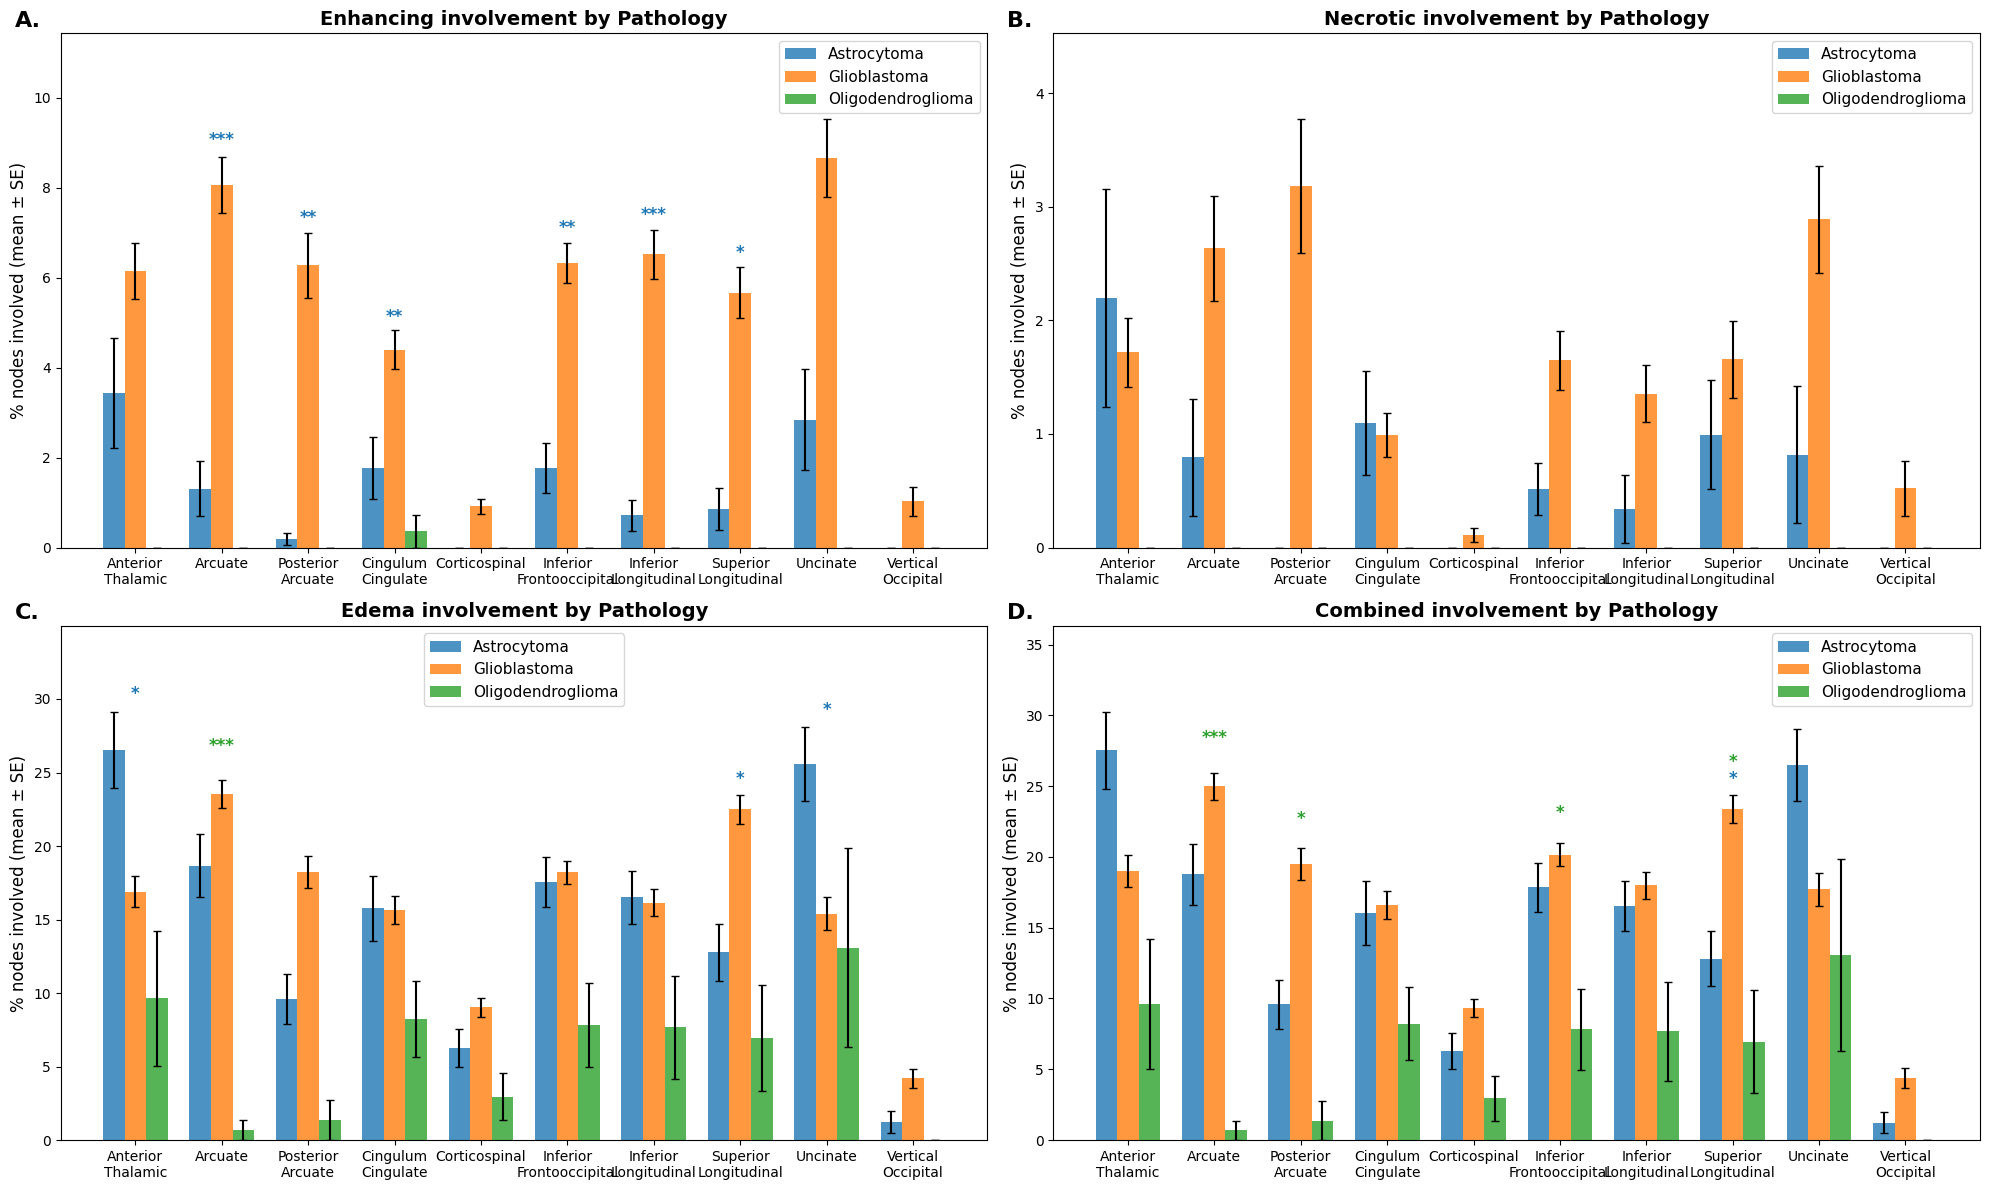


SIGNIFICANT PATHOLOGY DIFFERENCES (adjusted for age, sex)

Astrocytoma vs Glioblastoma:
  • Edema - Anterior Thalamic: Astrocytoma 26.5% vs Glioblastoma 16.9% (q=0.0132) *
  • Enhancing - Arcuate: Astrocytoma 1.3% vs Glioblastoma 8.1% (q=0.0001) ***
  • Enhancing - Posterior Arcuate: Astrocytoma 0.2% vs Glioblastoma 6.3% (q=0.0021) **
  • Enhancing - Cingulum Cingulate: Astrocytoma 1.8% vs Glioblastoma 4.4% (q=0.0023) **
  • Enhancing - Inferior Frontooccipital: Astrocytoma 1.8% vs Glioblastoma 6.3% (q=0.0042) **
  • Enhancing - Inferior Longitudinal: Astrocytoma 0.7% vs Glioblastoma 6.5% (q=0.0003) ***
  • Enhancing - Superior Longitudinal: Astrocytoma 0.9% vs Glioblastoma 5.7% (q=0.0217) *
  • Edema - Superior Longitudinal: Astrocytoma 12.8% vs Glioblastoma 22.5% (q=0.0266) *
  • Combined - Superior Longitudinal: Astrocytoma 12.8% vs Glioblastoma 23.4% (q=0.0436) *
  • Edema - Uncinate: Astrocytoma 25.6% vs Glioblastoma 15.4% (q=0.0133) *

Oligodendroglioma vs Glioblastoma:
  • Edem

In [6]:
# Load data and filter to final 483 patients
metadata = pd.read_csv('UCSF-PDGM-metadata_v5_cleaned.csv')
tracts = pd.read_csv('UCSF-PDGM-v5_profiles_20250819.csv')
final_patients = pd.read_csv('final_analysis_cohort.csv')

# ID matching functions
def extract_subject_num_meta(subject_id):
    if pd.isna(subject_id):
        return None
    import re
    match = re.search(r'PDGM-(\d+)', str(subject_id))
    if match:
        num_str = match.group(1)
        if len(num_str) == 3:
            return f"0{num_str}"
        return num_str
    return None

def extract_subject_num_tract(participant_id):
    if pd.isna(participant_id):
        return None
    import re
    match = re.search(r'sub-(\d+)', str(participant_id))
    return match.group(1) if match else None

# Match IDs and filter to final cohort
metadata['subject_num'] = metadata['ID'].apply(extract_subject_num_meta)
tracts['subject_num'] = tracts['participant'].apply(extract_subject_num_tract)
final_patients['subject_num'] = final_patients['participant'].apply(extract_subject_num_tract)

final_cohort_nums = set(final_patients['subject_num'].dropna())
metadata_filtered = metadata[metadata['subject_num'].isin(final_cohort_nums)].copy()
tracts_filtered = tracts[tracts['subject_num'].isin(final_cohort_nums)].copy()

# Merge to create df
df = pd.merge(tracts_filtered, metadata_filtered, on='subject_num', how='inner')
print(f"Final dataset: {len(df)} rows from {df['participant'].nunique()} subjects")

# Check pathology distribution
print("\nPathology distribution:")
pathology_counts = df.groupby('participant')['Pathology'].first().value_counts()
print(pathology_counts)

# Config
THRESH = 0.05
COMPONENTS = ['Enhancing', 'Necrotic', 'Edema', 'Combined']

COMBINE_TRACTS = {
    'Anterior Thalamic': ['LeftAnteriorThalamic','RightAnteriorThalamic'],
    'Arcuate': ['LeftArcuate','RightArcuate'],
    'Posterior Arcuate': ['LeftPosteriorArcuate','RightPosteriorArcuate'],
    'Cingulum Cingulate': ['LeftCingulumCingulate','RightCingulumCingulate'],
    'Corticospinal': ['LeftCorticospinal','RightCorticospinal'],
    'Inferior Frontooccipital': ['LeftInferiorFrontooccipital','RightInferiorFrontooccipital'],
    'Inferior Longitudinal': ['LeftInferiorLongitudinal','RightInferiorLongitudinal'],
    'Superior Longitudinal': ['LeftSuperiorLongitudinal','RightSuperiorLongitudinal'],
    'Uncinate': ['LeftUncinate','RightUncinate'],
    'Vertical Occipital': ['LeftVerticalOccipital','RightVerticalOccipital'],
}
TRACT_ORDER_COMBINED = list(COMBINE_TRACTS.keys())

# 1) Build continuous subject–tract measures with PATHOLOGY
def build_subject_continuous_pathology(df_nodes, thresh=0.05):
    rows = []

    for (pid, tract), g in df_nodes.groupby(['participant','tract'], sort=False):
        rec = {'participant': pid, 'tract': tract}

        # per-component: proportion of nodes above threshold
        rec['Enhancing_prop'] = (g['TUMOR-4'] > thresh).mean()
        rec['Necrotic_prop']  = (g['TUMOR-1'] > thresh).mean()
        rec['Edema_prop']     = (g['TUMOR-2'] > thresh).mean()

        # Combined: union across maps at node-level, then proportion > thresh
        any_tumor = g[['TUMOR-1','TUMOR-2','TUMOR-4']].max(axis=1)
        rec['Combined_prop']  = (any_tumor > thresh).mean()

        # Pathology and covariates
        rec['pathology'] = str(g['Pathology'].iloc[0])
        rec['Age_at_MRI'] = pd.to_numeric(g['Age at MRI'], errors='coerce').iloc[0] if 'Age at MRI' in g else np.nan
        rec['sex_binary'] = int(str(g['Sex'].iloc[0]).upper().startswith('M')) if 'Sex' in g else np.nan

        rows.append(rec)

    cont = pd.DataFrame(rows)
    if cont.empty:
        raise ValueError("No continuous subject–tract rows produced.")
    return cont

cont = build_subject_continuous_pathology(df, THRESH)

# 2) Collapse Left/Right to 10 combined tracts
def collapse_lr_continuous_pathology(cont_df, combine_map):
    out = []
    for pid, sub in cont_df.groupby('participant', sort=False):
        base = {
            'participant': pid,
            'pathology': sub['pathology'].iloc[0],
            'Age_at_MRI': sub['Age_at_MRI'].iloc[0],
            'sex_binary': sub['sex_binary'].iloc[0],
        }
        for tract_name, kids in combine_map.items():
            child = sub[sub['tract'].isin(kids)]
            if child.empty:
                continue
            row = base.copy()
            row['tract'] = tract_name
            # Average L/R proportions
            for comp in ['Enhancing_prop','Necrotic_prop','Edema_prop','Combined_prop']:
                row[comp] = child[comp].mean(skipna=True)
            out.append(row)
    coll = pd.DataFrame(out)
    if coll.empty:
        raise ValueError("Collapsed continuous table is empty.")
    return coll

cont_col = collapse_lr_continuous_pathology(cont, COMBINE_TRACTS)

# 3) Summaries: mean and SE per tract × pathology
def mean_se(x):
    x = pd.to_numeric(x, errors='coerce')
    n = x.notna().sum()
    mu = x.mean()
    se = x.std(ddof=1) / np.sqrt(n) if n > 1 else np.nan
    return pd.Series({'mean': mu, 'se': se, 'n': n})

def summarize_cont_pathology(cont_df):
    long = []
    for comp, col in [('Enhancing','Enhancing_prop'),
                      ('Necrotic','Necrotic_prop'),
                      ('Edema','Edema_prop'),
                      ('Combined','Combined_prop')]:
        tmp = (cont_df
               .groupby(['tract','pathology'])[col]
               .apply(mean_se)
               .unstack())
        tmp['component'] = comp
        tmp = tmp.reset_index()
        long.append(tmp)
    return pd.concat(long, ignore_index=True)

cont_pathology = summarize_cont_pathology(cont_col)

# 4) OLS regression p-values for pathology comparisons (adjusted for age + sex only)
def regression_pvals_pathology_adj(cont_df, comps, tracts, ref_pathology='Glioblastoma'):
    """Compare each pathology vs reference, adjusted for age and sex only"""
    rows = []
    pathology_types = cont_df['pathology'].unique()
    pathology_types = [p for p in pathology_types if p != ref_pathology and pd.notna(p)]
    
    for tract in tracts:
        tract_data = cont_df[cont_df['tract'] == tract].copy()
        if tract_data.empty:
            for comp in comps:
                for path_type in pathology_types:
                    rows.append({'tract': tract, 'comp': comp, 'comparison': f'{path_type}_vs_{ref_pathology}', 'p': np.nan})
            continue
            
        for comp in comps:
            ycol = f"{comp}_prop"
            
            # Run pairwise comparisons
            for path_type in pathology_types:
                # Filter to only reference group and current pathology type
                subset = tract_data[tract_data['pathology'].isin([ref_pathology, path_type])].copy()
                if subset.empty or subset['pathology'].nunique() < 2:
                    rows.append({'tract': tract, 'comp': comp, 'comparison': f'{path_type}_vs_{ref_pathology}', 'p': np.nan})
                    continue
                
                # Create binary variable (1 = current pathology, 0 = reference)
                subset['pathology_binary'] = (subset['pathology'] == path_type).astype(int)
                
                y = subset[ycol]
                if y.notna().sum() < 10 or subset['pathology_binary'].nunique() < 2:
                    rows.append({'tract': tract, 'comp': comp, 'comparison': f'{path_type}_vs_{ref_pathology}', 'p': np.nan})
                    continue
                
                # Build formula (adjust for age and sex only)
                formula = f"{ycol} ~ pathology_binary + Q('Age_at_MRI') + sex_binary"
                try:
                    model = smf.ols(formula, data=subset.dropna(subset=[ycol, 'pathology_binary', 'Age_at_MRI', 'sex_binary'])).fit()
                    pval = model.pvalues.get('pathology_binary', np.nan)
                except Exception:
                    pval = np.nan
                
                rows.append({'tract': tract, 'comp': comp, 'comparison': f'{path_type}_vs_{ref_pathology}', 'p': pval})
    
    return pd.DataFrame(rows)

# Get pathology p-values (adjusted for age + sex only) - NOW WITH GLIOBLASTOMA AS REFERENCE
pvals_pathology = regression_pvals_pathology_adj(
    cont_col, comps=COMPONENTS, tracts=TRACT_ORDER_COMBINED, ref_pathology='Glioblastoma'
)

def add_fdr_pathology(pval_df, alpha=0.05):
    out = pval_df.copy()
    out['q'] = np.nan
    out['sig'] = ''
    
    # Apply FDR correction within each comparison type and component
    for comparison in out['comparison'].dropna().unique():
        for comp in out['comp'].dropna().unique():
            mask = (out['comparison'] == comparison) & (out['comp'] == comp) & out['p'].notna()
            if mask.any():
                reject, qvals, _, _ = multipletests(out.loc[mask, 'p'].values, alpha=alpha, method='fdr_bh')
                out.loc[mask, 'q'] = qvals
                # star mapping based on q
                stars = []
                for q in qvals:
                    if q < 0.001: stars.append('***')
                    elif q < 0.01: stars.append('**')
                    elif q < 0.05: stars.append('*')
                    else: stars.append('')
                out.loc[mask, 'sig'] = stars
    return out

pvals_pathology = add_fdr_pathology(pvals_pathology, alpha=0.05)

# 5) Plotting function for pathology comparisons
def plot_pathology_mean_se():
    # Count how many pathology types we have
    pathologies = cont_pathology.columns.drop(['tract', 'component'])
    pathologies = [p for p in pathologies if 'mean' in str(p) or 'se' in str(p) or 'n' in str(p)]
    
    # Get unique pathology types from the data
    unique_pathologies = []
    for col in cont_pathology.columns:
        if col not in ['tract', 'component'] and not any(x in str(col) for x in ['mean', 'se', 'n']):
            unique_pathologies.append(col)
    
    if not unique_pathologies:
        # Extract from column names if structured differently
        unique_pathologies = cont_col['pathology'].dropna().unique()
    
    print(f"Available pathologies: {unique_pathologies}")
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharey=False)
    order = TRACT_ORDER_COMBINED
    
    # Define colors for each pathology type
    colors = {'Astrocytoma': '#1f77b4', 'Glioblastoma': '#ff7f0e', 'Oligodendroglioma': '#2ca02c'}
    
    for i, comp in enumerate(COMPONENTS):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        
        # Add panel label
        panel_letter = chr(65 + i) + '.'  # A., B., C., D.
        ax.text(-0.05, 1.005, panel_letter, transform=ax.transAxes, fontsize=16, fontweight='bold', 
                verticalalignment='bottom', horizontalalignment='left')
        
        # Get data for this component
        sub = cont_pathology[cont_pathology['component'] == comp].copy()
        
        if sub.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            continue
        
        # Create pivot tables for mean and se
        try:
            p_mean = sub.pivot(index='tract', columns='pathology', values='mean').reindex(order)
            p_se = sub.pivot(index='tract', columns='pathology', values='se').reindex(order)
        except Exception as e:
            print(f"Error creating pivot for {comp}: {e}")
            print(f"Available columns: {sub.columns.tolist()}")
            continue
        
        # Ensure all pathology types are present
        for path_type in ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']:
            if path_type not in p_mean.columns:
                p_mean[path_type] = np.nan
                p_se[path_type] = np.nan
        
        # Multi-line x labels
        tract_labels = p_mean.index.str.replace(" ", "\n")
        
        # Grouped bar positions
        idx = np.arange(len(p_mean.index))
        width = 0.25  # Narrower bars for 3 groups
        
        # Bars + SE error bars (in %)
        pathology_order = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
        for j, path_type in enumerate(pathology_order):
            if path_type in p_mean.columns:
                y = p_mean[path_type].values * 100.0
                e = p_se[path_type].values * 100.0
                color = colors.get(path_type, f'C{j}')
                ax.bar(idx + (j-1)*width, y, width, yerr=e, capsize=3, 
                       label=path_type, color=color, alpha=0.8)
        
        ax.set_title(f"{comp} involvement by Pathology", fontsize=14, fontweight='bold')
        ax.set_ylabel('% nodes involved (mean ± SE)', fontsize=12)
        ax.set_xlabel('')
        ax.legend(title="", fontsize=11)
        
        # Headroom includes error bars
        ymax = np.nanmax((p_mean.values + p_se.values) * 100.0)
        if np.isfinite(ymax):
            ax.set_ylim(0, ymax * 1.2)  # Extra space for significance stars
        
        ax.set_xticks(idx)
        ax.set_xticklabels(tract_labels, rotation=0)
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        
        # Add significance stars for each comparison - UPDATED COMPARISONS
        comparisons = ['Astrocytoma_vs_Glioblastoma', 'Oligodendroglioma_vs_Glioblastoma']
        star_colors = ['#1f77b4', '#2ca02c']  # Colors matching the pathology types
        
        for k, tract_orig in enumerate(p_mean.index):
            # Position stars at different heights
            base_height = np.nanmax((p_mean.iloc[k].values + p_se.iloc[k].values) * 100.0)
            if not np.isfinite(base_height):
                continue
            
            for m, (comparison, star_color) in enumerate(zip(comparisons, star_colors)):
                row = pvals_pathology[(pvals_pathology['tract'] == tract_orig) & 
                                     (pvals_pathology['comp'] == comp) & 
                                     (pvals_pathology['comparison'] == comparison)]
                if not row.empty and 'sig' in row.columns:
                    sig = row['sig'].values[0]
                    if sig:
                        star_y = base_height * (1.02 + m * 0.05)  # Offset vertically
                        ax.text(k, star_y, sig, ha='center', va='bottom',
                                fontsize=12, fontweight='bold', color=star_color)

    plt.tight_layout()
    plt.show()

# Generate the pathology plot
plot_pathology_mean_se()

# Print summary results
print("\n" + "="*70)
print("SIGNIFICANT PATHOLOGY DIFFERENCES (adjusted for age, sex)")
print("="*70)

comparisons = ['Astrocytoma_vs_Glioblastoma', 'Oligodendroglioma_vs_Glioblastoma']

for comparison in comparisons:
    print(f"\n{comparison.replace('_', ' ')}:")
    sig_results = pvals_pathology[(pvals_pathology['comparison'] == comparison) & 
                                 (pvals_pathology['sig'] != '')].copy()
    
    if len(sig_results) > 0:
        for _, row in sig_results.iterrows():
            # Get data directly from cont_col instead of the pivot
            tract_data = cont_col[cont_col['tract'] == row['tract']]
            comp_col = f"{row['comp']}_prop"
            
            # Calculate means by pathology
            gbm_mean = tract_data[tract_data['pathology'] == 'Glioblastoma'][comp_col].mean() * 100
            
            other_name = comparison.split('_')[0]
            other_mean = tract_data[tract_data['pathology'] == other_name][comp_col].mean() * 100
            
            print(f"  • {row['comp']} - {row['tract']}: {other_name} {other_mean:.1f}% vs Glioblastoma {gbm_mean:.1f}% (q={row['q']:.4f}) {row['sig']}")
    else:
        print(f"  No significant differences found")

### Summary Table of Direct Tract Involvement

In [7]:
COMPONENTS = ['Enhancing','Necrotic','Edema','Combined']

def build_pathology_summary(global_comp):
    """
    Summarize component measures by pathology group.
    Returns a DataFrame with mean and std for each component/outcome/pathology.
    """
    summary_rows = []
    for comp in COMPONENTS:
        for outcome in ['any', 'ntracts', 'meanprop']:
            ycol = f'{comp}_{outcome}'
            for pathology, group in global_comp.groupby('pathology'):
                vals = group[ycol].dropna()
                summary_rows.append({
                    'component': comp,
                    'outcome': outcome,
                    'pathology': pathology,
                    'n': len(vals),
                    'mean': vals.mean() if len(vals) > 0 else float('nan'),
                    'std': vals.std() if len(vals) > 0 else float('nan')
                })
    return pd.DataFrame(summary_rows)

# 1) Build subject-level component outcomes (unchanged)
def build_subject_component_measures(df_nodes, thresh=0.05):
    rows = []

    for pid, g in df_nodes.groupby('participant'):
        rec = {'participant': pid}
        # covariates
        rec['Age_at_MRI'] = pd.to_numeric(g['Age at MRI'], errors='coerce').iloc[0] if 'Age at MRI' in g else np.nan
        rec['sex_binary'] = int(str(g['Sex'].iloc[0]).upper().startswith('M')) if 'Sex' in g else np.nan
        
        # Add pathology
        rec['pathology'] = str(g['Pathology'].iloc[0]) if 'Pathology' in g else np.nan

        # compartment-level measures
        for comp, col in zip(['Necrotic','Edema','Enhancing'], ['TUMOR-1','TUMOR-2','TUMOR-4']):
            any_inv = int((g[col] > thresh).any())
            n_tracts = g.groupby('tract')[col].max().gt(thresh).sum()
            mean_prop = (g[col] > thresh).mean()
            rec[f'{comp}_any']       = any_inv
            rec[f'{comp}_ntracts']   = n_tracts
            rec[f'{comp}_meanprop']  = mean_prop

        # Combined
        any_all = g[['TUMOR-1','TUMOR-2','TUMOR-4']].max(axis=1)
        rec['Combined_any']       = int((any_all > thresh).any())
        rec['Combined_ntracts']   = g.groupby('tract')[['TUMOR-1','TUMOR-2','TUMOR-4']].max().max(axis=1).gt(thresh).sum()
        rec['Combined_meanprop']  = (any_all > thresh).mean()

        rows.append(rec)
    return pd.DataFrame(rows)

global_comp = build_subject_component_measures(df, thresh=0.05)

# 2) Enhanced function with both overall 3-way and pairwise comparisons
def run_pathology_models_with_overall(global_df, adjust_cols, family_label):
    """Run pathology comparisons with both overall 3-way and pairwise tests"""
    rows = []
    
    # Filter to subjects with pathology data
    pathology_df = global_df.dropna(subset=['pathology']).copy()
    
    # Check available pathologies
    available_pathologies = pathology_df['pathology'].unique()
    pathology_order = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
    valid_pathologies = [p for p in pathology_order if p in available_pathologies]
    
    if len(valid_pathologies) < 2:
        print(f"Insufficient pathology groups: {valid_pathologies}")
        return pd.DataFrame()
    
    # Filter to only valid pathologies
    pathology_df = pathology_df[pathology_df['pathology'].isin(valid_pathologies)]
    
    # Create dummy variables with Glioblastoma as reference
    pathology_df['astro_dummy'] = (pathology_df['pathology'] == 'Astrocytoma').astype(int)
    pathology_df['oligo_dummy'] = (pathology_df['pathology'] == 'Oligodendroglioma').astype(int)
    
    for comp in COMPONENTS:
        for outcome in ['any','ntracts','meanprop']:
            ycol = f'{comp}_{outcome}'
            sub = pathology_df.dropna(subset=[ycol] + adjust_cols).copy()
            
            if sub.empty or len(sub['pathology'].unique()) < 2:
                # Add placeholder for overall test
                rows.append({
                    'comparison': family_label,
                    'component': comp,
                    'outcome': outcome,
                    'pathology_comparison': 'Overall_3way',
                    'p': np.nan
                })
                # Add placeholders for pairwise tests
                for pathology in ['Astrocytoma', 'Oligodendroglioma']:
                    if pathology in valid_pathologies:
                        rows.append({
                            'comparison': family_label,
                            'component': comp,
                            'outcome': outcome,
                            'pathology_comparison': f'{pathology}_vs_Glioblastoma',
                            'p': np.nan
                        })
                continue
            
            try:
                if outcome == 'any':
                    # Logistic regression
                    X_cols = ['astro_dummy', 'oligo_dummy'] + adjust_cols
                    X = sm.add_constant(sub[X_cols])
                    y = sub[ycol].astype(int)
                    fit = sm.GLM(y, X, family=sm.families.Binomial()).fit()
                else:
                    # OLS regression
                    cov_terms = [f"Q('{c}')" if c == 'Age_at_MRI' else c for c in adjust_cols]
                    formula = f"{ycol} ~ astro_dummy + oligo_dummy + " + " + ".join(cov_terms)
                    fit = smf.ols(formula, data=sub).fit()
                
                # =============================================================
                # OVERALL 3-WAY TEST: Test if both dummy coefficients = 0
                # =============================================================
                try:
                    # F-test for overall pathology effect (both dummies jointly = 0)
                    if len(valid_pathologies) >= 3:  # Only if we have all 3 pathologies
                        pathology_params = ['astro_dummy', 'oligo_dummy']
                        # Create restriction matrix: both coefficients = 0
                        restriction = np.zeros((2, len(fit.params)))
                        param_names = list(fit.params.index)
                        
                        for i, param in enumerate(pathology_params):
                            if param in param_names:
                                restriction[i, param_names.index(param)] = 1
                        
                        # Perform F-test
                        if outcome == 'any':
                            # For GLM, use Wald test
                            wald_stat = fit.wald_test(restriction)
                            overall_p = wald_stat.pvalue
                        else:
                            # For OLS, use F-test
                            f_test = fit.f_test(restriction)
                            overall_p = f_test.pvalue
                    else:
                        overall_p = np.nan
                        
                except Exception as e:
                    print(f"Overall test failed for {comp}_{outcome}: {e}")
                    overall_p = np.nan
                
                # Add overall test result
                rows.append({
                    'comparison': family_label,
                    'component': comp,
                    'outcome': outcome,
                    'pathology_comparison': 'Overall_3way',
                    'p': overall_p
                })
                
                # =============================================================
                # PAIRWISE TESTS: Individual dummy coefficients
                # =============================================================
                # Extract p-values for each pathology vs Glioblastoma
                astro_p = fit.pvalues.get('astro_dummy', np.nan)
                oligo_p = fit.pvalues.get('oligo_dummy', np.nan)
                
                rows.append({
                    'comparison': family_label,
                    'component': comp,
                    'outcome': outcome,
                    'pathology_comparison': 'Astrocytoma_vs_Glioblastoma',
                    'p': astro_p
                })
                
                rows.append({
                    'comparison': family_label,
                    'component': comp,
                    'outcome': outcome,
                    'pathology_comparison': 'Oligodendroglioma_vs_Glioblastoma',
                    'p': oligo_p
                })
                
            except Exception as e:
                print(f"Model failed for {comp}_{outcome}: {e}")
                # Add NaN entries for failed models
                rows.append({
                    'comparison': family_label,
                    'component': comp,
                    'outcome': outcome,
                    'pathology_comparison': 'Overall_3way',
                    'p': np.nan
                })
                for pathology in ['Astrocytoma', 'Oligodendroglioma']:
                    if pathology in valid_pathologies:
                        rows.append({
                            'comparison': family_label,
                            'component': comp,
                            'outcome': outcome,
                            'pathology_comparison': f'{pathology}_vs_Glioblastoma',
                            'p': np.nan
                        })
    
    return pd.DataFrame(rows)

# 3) Run enhanced pathology analysis
pvals_pathology = run_pathology_models_with_overall(global_comp, ['Age_at_MRI','sex_binary'], 'Pathology')

# 4) Enhanced FDR correction with separate families for overall vs pairwise
def add_fdr_pathology_enhanced(pval_df):
    out = pval_df.copy()
    out['q'] = np.nan
    out['sig'] = ''
    
    # Separate overall tests from pairwise tests
    overall_tests = out['pathology_comparison'] == 'Overall_3way'
    pairwise_tests = out['pathology_comparison'] != 'Overall_3way'
    
    # Apply FDR correction separately for overall and pairwise tests
    for test_family, family_name in [(overall_tests, 'Overall'), (pairwise_tests, 'Pairwise')]:
        for outcome in out['outcome'].unique():
            mask = test_family & (out['outcome'] == outcome) & out['p'].notna()
            if mask.any():
                reject, qvals, _, _ = multipletests(out.loc[mask,'p'], alpha=0.05, method='fdr_bh')
                out.loc[mask,'q'] = qvals
                out.loc[mask,'sig'] = ['***' if q<0.001 else '**' if q<0.01 else '*' if q<0.05 else ''
                                       for q in qvals]
    return out

if not pvals_pathology.empty:
    pvals_pathology = add_fdr_pathology_enhanced(pvals_pathology)

# 5) Enhanced results display
def print_enhanced_pathology_results(pvals_df):
    """Print results with clear separation of overall vs pairwise tests"""
    
    print(f"\n{'='*80}")
    print("PATHOLOGY ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    # Overall 3-way tests
    overall_results = pvals_df[pvals_df['pathology_comparison'] == 'Overall_3way']
    if not overall_results.empty:
        print(f"\nOVERALL 3-WAY PATHOLOGY EFFECTS:")
        print(f"{'Component':<12} {'Outcome':<10} {'p-value':<10} {'q-value':<10} {'Significant':<12}")
        print("-" * 60)
        
        for _, row in overall_results.iterrows():
            sig_marker = row['sig'] if pd.notna(row['sig']) else ''
            p_val = f"{row['p']:.4f}" if pd.notna(row['p']) else 'N/A'
            q_val = f"{row['q']:.4f}" if pd.notna(row['q']) else 'N/A'
            
            print(f"{row['component']:<12} {row['outcome']:<10} {p_val:<10} {q_val:<10} {sig_marker:<12}")
    
    # Pairwise tests
    pairwise_results = pvals_df[pvals_df['pathology_comparison'] != 'Overall_3way']
    if not pairwise_results.empty:
        print(f"\nPAIRWISE PATHOLOGY COMPARISONS:")
        print(f"{'Component':<12} {'Outcome':<10} {'Comparison':<30} {'p-value':<10} {'q-value':<10} {'Sig':<5}")
        print("-" * 80)
        
        for _, row in pairwise_results.iterrows():
            sig_marker = row['sig'] if pd.notna(row['sig']) else ''
            p_val = f"{row['p']:.4f}" if pd.notna(row['p']) else 'N/A'
            q_val = f"{row['q']:.4f}" if pd.notna(row['q']) else 'N/A'
            comparison = row['pathology_comparison'].replace('_vs_', ' vs ')
            
            print(f"{row['component']:<12} {row['outcome']:<10} {comparison:<30} {p_val:<10} {q_val:<10} {sig_marker:<5}")

# Build pathology summary
summary_pathology = build_pathology_summary(global_comp)

# Save and display results
if not pvals_pathology.empty:
        
    # Print enhanced results
    print_enhanced_pathology_results(pvals_pathology)
    
    # Count significant results by type
    overall_sig = pvals_pathology[(pvals_pathology['pathology_comparison'] == 'Overall_3way') & 
                                 (pvals_pathology['sig'] != '')].copy()
    pairwise_sig = pvals_pathology[(pvals_pathology['pathology_comparison'] != 'Overall_3way') & 
                                  (pvals_pathology['sig'] != '')].copy()
    
    print(f"\nSUMMARY:")
    print(f"Overall 3-way effects: {len(overall_sig)} significant out of {len(pvals_pathology[pvals_pathology['pathology_comparison'] == 'Overall_3way'])}")
    print(f"Pairwise effects: {len(pairwise_sig)} significant out of {len(pvals_pathology[pvals_pathology['pathology_comparison'] != 'Overall_3way'])}")
    
    print("\nModels adjusted for: age, sex")
    print("Reference group: Glioblastoma")
    print("FDR correction applied separately for overall vs pairwise tests")
    
else:
    print("No pathology analysis results generated - insufficient data")

print(f"\nPathology summary table:")
print(summary_pathology.head(20))


PATHOLOGY ANALYSIS RESULTS

OVERALL 3-WAY PATHOLOGY EFFECTS:
Component    Outcome    p-value    q-value    Significant 
------------------------------------------------------------
Enhancing    any        0.0000     0.0000     ***         
Enhancing    ntracts    0.0000     0.0000     ***         
Enhancing    meanprop   0.0000     0.0000     ***         
Necrotic     any        0.0000     0.0000     ***         
Necrotic     ntracts    0.0000     0.0000     ***         
Necrotic     meanprop   0.0107     0.0107     *           
Edema        any        1.0000     1.0000                 
Edema        ntracts    0.0009     0.0009     ***         
Edema        meanprop   0.0048     0.0064     **          
Combined     any        1.0000     1.0000                 
Combined     ntracts    0.0002     0.0002     ***         
Combined     meanprop   0.0014     0.0027     **          

PAIRWISE PATHOLOGY COMPARISONS:
Component    Outcome    Comparison                     p-value    q-value    

## Contralateral hemisphere analyses

### Pairwise Analyses

In [8]:
# Load and prepare the data
final_patients = pd.read_csv('final_analysis_cohort.csv')
final_participant_list = final_patients['participant'].tolist()
metadata = pd.read_csv('UCSF-PDGM-metadata_v5_cleaned.csv')
tracts = pd.read_csv('UCSF-PDGM-v5_profiles_20250819.csv')
metadata['participant'] = 'sub-' + metadata['ID'].str.extract(r'UCSF-PDGM-(\d+)')[0].str.zfill(4)

# Merge datasets and FILTER TO FINAL PATIENTS ONLY
df = tracts.merge(metadata, on='participant', how='inner')
df = df[df['participant'].isin(final_participant_list)]

# Create analysis variables
df['sex_binary'] = (df['Sex'] == 'M').astype(int)
df['hemisphere'] = df['tract'].str.extract('(Left|Right)')[0]
df['tract_base'] = df['tract'].str.replace('Left|Right', '', regex=True)

print(f"Dataset: {len(df):,} rows, {df['participant'].nunique()} subjects")

# Check pathology distribution
print("\nPathology distribution:")
pathology_counts = df.groupby('participant')['Pathology'].first().value_counts()
print(pathology_counts)

def extract_contralateral_data_pathology():
    """
    Extract contralateral hemisphere data for pathology analysis
    Use hemisphere with less tumor involvement as "contralateral"
    """
    print(f"\n{'='*80}")
    print("EXTRACTING CONTRALATERAL DATA - PATHOLOGY ANALYSIS")
    print(f"{'='*80}")
    
    # Define tumor involvement
    df['any_tumor'] = df[['TUMOR-1', 'TUMOR-2', 'TUMOR-4']].max(axis=1)
    df['tumor_affected'] = (df['any_tumor'] > 0.05).astype(int)
    
    contralateral_data = []
    
    for participant in df['participant'].unique():
        subj_data = df[df['participant'] == participant]
        participant_info = subj_data.iloc[0]
        
        # Skip if no pathology data
        if pd.isna(participant_info['Pathology']):
            continue
        
        # Get hemisphere-level tumor involvement
        left_involvement = subj_data[subj_data['hemisphere'] == 'Left']['tumor_affected'].mean()
        right_involvement = subj_data[subj_data['hemisphere'] == 'Right']['tumor_affected'].mean()
        
        # Choose hemisphere with less involvement as "contralateral"
        if left_involvement <= right_involvement:
            contralateral_hemisphere = 'Left'
        else:
            contralateral_hemisphere = 'Right'
        
        # Extract contralateral data
        contra_data = subj_data[subj_data['hemisphere'] == contralateral_hemisphere]
        
        if len(contra_data) > 0:
            # Calculate mean BELTRAMI values across all contralateral nodes
            beltrami_fa = contra_data['BELTRAMI-FA'].mean()
            beltrami_fwf = contra_data['BELTRAMI-FWF'].mean()
            beltrami_md = contra_data['BELTRAMI-MD'].mean()
            
            contralateral_data.append({
                'participant': participant,
                'pathology': participant_info['Pathology'],
                'Age at MRI': participant_info['Age at MRI'],
                'Sex': participant_info['Sex'],
                'sex_binary': participant_info['sex_binary'],
                'contralateral_hemisphere': contralateral_hemisphere,
                'left_involvement': left_involvement,
                'right_involvement': right_involvement,
                'BELTRAMI_FA_contra': beltrami_fa,
                'BELTRAMI_FWF_contra': beltrami_fwf,
                'BELTRAMI_MD_contra': beltrami_md
            })
    
    contra_df = pd.DataFrame(contralateral_data)
    print(f"Contralateral data extracted for {len(contra_df)} patients")
    
    # Print pathology distribution in final dataset
    print("\nPathology distribution in contralateral analysis:")
    pathology_contra_counts = contra_df['pathology'].value_counts()
    print(pathology_contra_counts)
    
    return contra_df

def compare_pathology_pairwise(contra_df, pathology1, pathology2):
    """
    Compare two pathology groups with age + sex adjustment only
    """
    print(f"\n{pathology1} vs {pathology2}:")
    print("-" * 50)
    
    # Filter to only these two pathologies
    data = contra_df[contra_df['pathology'].isin([pathology1, pathology2])].copy()
    
    if len(data) == 0:
        print("  No data for this comparison")
        return []
    
    results = []
    measures = ['BELTRAMI_FA_contra', 'BELTRAMI_MD_contra', 'BELTRAMI_FWF_contra']
    measure_names = ['FA', 'MD', 'FWF']
    
    for measure, measure_name in zip(measures, measure_names):
        # Get values for each pathology
        vals1 = data[data['pathology'] == pathology1][measure].dropna()
        vals2 = data[data['pathology'] == pathology2][measure].dropna()
        
        if len(vals1) < 3 or len(vals2) < 3:
            print(f"  {measure_name}: Insufficient data (n1={len(vals1)}, n2={len(vals2)})")
            continue

        # Basic descriptive stats
        mean1, sd1, n1 = vals1.mean(), vals1.std(ddof=1), len(vals1)
        mean2, sd2, n2 = vals2.mean(), vals2.std(ddof=1), len(vals2)
        diff = mean2 - mean1
        pooled = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2) / (n1+n2-2)) if (n1+n2-2)>0 else np.nan
        cohens_d = diff/pooled if (pooled is not None and pooled>0) else np.nan

        print(f"  {measure_name}:")
        print(f"    {pathology1}: {mean1:.4f} ± {sd1:.4f} (n={n1})")
        print(f"    {pathology2}: {mean2:.4f} ± {sd2:.4f} (n={n2})")
        print(f"    Difference ({pathology2}-{pathology1}): {diff:+.4f}")
        print(f"    Cohen's d: {cohens_d:.3f}")

        # Unadjusted Mann-Whitney U test
        try:
            mw_stat, mw_p = mannwhitneyu(vals2, vals1, alternative='two-sided')
            print(f"    Unadjusted Mann-Whitney U: p={mw_p:.4f}")
        except:
            mw_p = np.nan
            print(f"    Unadjusted Mann-Whitney U: Failed")

        # Age + Sex adjusted model
        model_data = data.dropna(subset=['pathology', measure, 'Age at MRI', 'Sex'])
        
        if len(model_data) >= 10 and model_data['pathology'].nunique() == 2:
            try:
                formula = f'{measure} ~ C(pathology) + Q("Age at MRI") + C(Sex)'
                model = smf.ols(formula, data=model_data).fit()
                
                # Find the pathology coefficient
                coef_terms = [ix for ix in model.params.index if ix.startswith("C(pathology)[T.")]
                if coef_terms:
                    coef_term = coef_terms[0]
                    coef = model.params[coef_term]
                    p_adj = model.pvalues[coef_term]
                    ci_low, ci_high = model.conf_int().loc[coef_term]
                    print(f"    Age+Sex adjusted: coef={coef:+.4f} [{ci_low:+.4f},{ci_high:+.4f}], p={p_adj:.4f}")
                else:
                    coef, p_adj = np.nan, np.nan
                    print(f"    Age+Sex adjusted: Failed to find coefficient")
            except Exception as e:
                coef, p_adj = np.nan, np.nan
                print(f"    Age+Sex adjusted: Failed - {e}")
        else:
            coef, p_adj = np.nan, np.nan
            print(f"    Age+Sex adjusted: Insufficient data for modeling")

        # Store results
        results.append({
            'comparison': f'{pathology1}_vs_{pathology2}',
            'measure': measure_name,
            'pathology1': pathology1,
            'pathology2': pathology2,
            'mean1': mean1,
            'sd1': sd1,
            'mean2': mean2, 
            'sd2': sd2,
            'diff': diff,
            'cohens_d': cohens_d,
            'n1': n1,
            'n2': n2,
            'p_unadjusted': mw_p,
            'p_adjusted': p_adj,
            'coef_adjusted': coef
        })
    
    return results

def apply_pathology_fdr_correction(all_results):
    """
    Apply FDR correction to pathology comparisons
    Separate correction for unadjusted vs adjusted models
    """
    print(f"\n{'='*80}")
    print("FDR CORRECTION FOR PATHOLOGY COMPARISONS")
    print(f"{'='*80}")
    
    results_df = pd.DataFrame(all_results)
    if results_df.empty:
        print("No results to correct")
        return results_df
    
    # Apply FDR correction separately for unadjusted and adjusted models
    results_df['q_unadjusted'] = np.nan
    results_df['q_adjusted'] = np.nan
    results_df['sig_unadjusted'] = False
    results_df['sig_adjusted'] = False
    
    # Unadjusted tests
    p_unadj = results_df['p_unadjusted'].dropna()
    if len(p_unadj) > 0:
        reject, q_unadj, _, _ = multipletests(p_unadj.values, method='fdr_bh', alpha=0.05)
        results_df.loc[p_unadj.index, 'q_unadjusted'] = q_unadj
        results_df.loc[p_unadj.index, 'sig_unadjusted'] = reject
        
        n_sig_before = sum(p_unadj < 0.05)
        n_sig_after = sum(reject)
        print(f"Unadjusted tests: {len(p_unadj)} tests, {n_sig_before}→{n_sig_after} significant after FDR")
    
    # Adjusted tests
    p_adj = results_df['p_adjusted'].dropna()
    if len(p_adj) > 0:
        reject, q_adj, _, _ = multipletests(p_adj.values, method='fdr_bh', alpha=0.05)
        results_df.loc[p_adj.index, 'q_adjusted'] = q_adj
        results_df.loc[p_adj.index, 'sig_adjusted'] = reject
        
        n_sig_before = sum(p_adj < 0.05)
        n_sig_after = sum(reject)
        print(f"Adjusted tests: {len(p_adj)} tests, {n_sig_before}→{n_sig_after} significant after FDR")
    
    return results_df

def print_pathology_results_table(results_df):
    """
    Print formatted results table for pathology comparisons
    """
    print(f"\n{'='*100}")
    print("PATHOLOGY CONTRALATERAL HEMISPHERE ANALYSIS RESULTS")
    print(f"{'='*100}")
    
    if results_df.empty:
        print("No results to display")
        return
    
    print("Reference: Glioblastoma (positive values = other pathology > Glioblastoma)")
    print("Adjustment: Age + Sex only")
    print()
    
    # Group by comparison
    for comparison in results_df['comparison'].unique():
        comp_data = results_df[results_df['comparison'] == comparison]
        
        pathology1 = comp_data['pathology1'].iloc[0]
        pathology2 = comp_data['pathology2'].iloc[0]
        
        print(f"{comparison.replace('_vs_', ' vs ')}:")
        print("-" * 90)
        print(f"{'Measure':<8} {'Mean1±SD':<15} {'Mean2±SD':<15} {'Diff':<8} {'Cohen_d':<8} {'Unadj p/q':<12} {'Adj p/q':<12}")
        print("-" * 90)
        
        for _, row in comp_data.iterrows():
            # Format based on measure type
            if row['measure'] == 'MD':
                mean1_str = f"{row['mean1']:.5f}±{row['sd1']:.5f}"
                mean2_str = f"{row['mean2']:.5f}±{row['sd2']:.5f}"
            else:
                mean1_str = f"{row['mean1']:.3f}±{row['sd1']:.3f}"
                mean2_str = f"{row['mean2']:.3f}±{row['sd2']:.3f}"
            
            diff_str = f"{row['diff']:+.4f}" if not pd.isna(row['diff']) else "N/A"
            d_str = f"{row['cohens_d']:.3f}" if not pd.isna(row['cohens_d']) else "N/A"
            
            # Format p/q values with significance markers
            if not pd.isna(row['p_unadjusted']) and not pd.isna(row['q_unadjusted']):
                unadj_str = f"{row['p_unadjusted']:.3f}/{row['q_unadjusted']:.3f}"
                if row['sig_unadjusted']:
                    unadj_str += "*"
            else:
                unadj_str = "N/A"
                
            if not pd.isna(row['p_adjusted']) and not pd.isna(row['q_adjusted']):
                adj_str = f"{row['p_adjusted']:.3f}/{row['q_adjusted']:.3f}"
                if row['sig_adjusted']:
                    adj_str += "*"
            else:
                adj_str = "N/A"
            
            print(f"{row['measure']:<8} {mean1_str:<15} {mean2_str:<15} {diff_str:<8} "
                  f"{d_str:<8} {unadj_str:<12} {adj_str:<12}")
        
        print()

def print_significant_pathology_effects(results_df):
    """
    Print only FDR-significant results
    """
    print(f"\n{'='*80}")
    print("SIGNIFICANT PATHOLOGY EFFECTS (FDR-CORRECTED)")
    print(f"{'='*80}")
    
    # Unadjusted significant results
    sig_unadj = results_df[results_df['sig_unadjusted'] == True]
    print(f"\nUNADJUSTED COMPARISONS (Mann-Whitney U):")
    if len(sig_unadj) > 0:
        for _, row in sig_unadj.iterrows():
            direction = "higher" if row['diff'] > 0 else "lower"
            print(f"• {row['pathology2']} vs {row['pathology1']} - {row['measure']}: "
                  f"{row['pathology2']} {direction} by {abs(row['diff']):.4f} "
                  f"(d={row['cohens_d']:.3f}, q={row['q_unadjusted']:.4f})")
    else:
        print("• No significant unadjusted effects")
    
    # Adjusted significant results
    sig_adj = results_df[results_df['sig_adjusted'] == True]
    print(f"\nAGE+SEX ADJUSTED COMPARISONS:")
    if len(sig_adj) > 0:
        for _, row in sig_adj.iterrows():
            direction = "higher" if row['coef_adjusted'] > 0 else "lower"
            print(f"• {row['pathology2']} vs {row['pathology1']} - {row['measure']}: "
                  f"{row['pathology2']} {direction} by {abs(row['coef_adjusted']):.4f} "
                  f"(coef={row['coef_adjusted']:+.4f}, q={row['q_adjusted']:.4f})")
    else:
        print("• No significant adjusted effects")

# Run the pathology analysis
print("CONTRALATERAL HEMISPHERE ANALYSIS - PATHOLOGY COMPARISONS")
print("="*70)

# Extract contralateral data for pathology analysis
contra_df = extract_contralateral_data_pathology()

if len(contra_df) > 0:
    # Define pathology comparisons (using Glioblastoma as reference)
    pathology_comparisons = [
        ('Glioblastoma', 'Astrocytoma'),
        ('Glioblastoma', 'Oligodendroglioma'),
        ('Astrocytoma', 'Oligodendroglioma')
    ]
    
    all_results = []
    
    # Run pairwise comparisons
    for path1, path2 in pathology_comparisons:
        # Check if both pathologies exist in data
        available_pathologies = contra_df['pathology'].unique()
        if path1 in available_pathologies and path2 in available_pathologies:
            results = compare_pathology_pairwise(contra_df, path1, path2)
            all_results.extend(results)
        else:
            print(f"\nSkipping {path1} vs {path2}: One or both pathologies not available")
    
    if all_results:
        # Apply FDR correction
        results_df = apply_pathology_fdr_correction(all_results)
        
        # Print results
        print_pathology_results_table(results_df)
        print_significant_pathology_effects(results_df)

    else:
        print("No pathology comparison results generated")
        
else:
    print("No contralateral data extracted for pathology analysis")

Dataset: 928,800 rows, 459 subjects

Pathology distribution:
Pathology
Glioblastoma         361
Astrocytoma           87
Oligodendroglioma     11
Name: count, dtype: int64
CONTRALATERAL HEMISPHERE ANALYSIS - PATHOLOGY COMPARISONS

EXTRACTING CONTRALATERAL DATA - PATHOLOGY ANALYSIS
Contralateral data extracted for 459 patients

Pathology distribution in contralateral analysis:
pathology
Glioblastoma         361
Astrocytoma           87
Oligodendroglioma     11
Name: count, dtype: int64

Glioblastoma vs Astrocytoma:
--------------------------------------------------
  FA:
    Glioblastoma: 0.4181 ± 0.0160 (n=361)
    Astrocytoma: 0.4282 ± 0.0138 (n=87)
    Difference (Astrocytoma-Glioblastoma): +0.0102
    Cohen's d: 0.650
    Unadjusted Mann-Whitney U: p=0.0000
    Age+Sex adjusted: coef=-0.0061 [-0.0107,-0.0015], p=0.0098
  MD:
    Glioblastoma: 0.0006 ± 0.0000 (n=361)
    Astrocytoma: 0.0006 ± 0.0000 (n=87)
    Difference (Astrocytoma-Glioblastoma): -0.0000
    Cohen's d: -0.601
    U

### 3-way Analyses

In [9]:
def compare_pathology_3way_adjusted(contra_df):
    """
    3-way pathology comparison with age + sex adjustment
    Uses ANOVA F-test approach with dummy coding
    """
    print(f"\n{'='*80}")
    print("3-WAY PATHOLOGY ANALYSIS WITH AGE + SEX ADJUSTMENT")
    print(f"{'='*80}")
    
    # Filter to subjects with complete data
    pathology_data = contra_df.dropna(subset=['pathology', 'Age at MRI', 'Sex'])
    
    # Check available pathologies
    available_pathologies = pathology_data['pathology'].unique()
    pathology_order = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
    valid_pathologies = [p for p in pathology_order if p in available_pathologies]
    
    if len(valid_pathologies) < 3:
        print(f"Insufficient pathology groups for 3-way analysis: {valid_pathologies}")
        return []
    
    # Filter to only valid pathologies
    pathology_data = pathology_data[pathology_data['pathology'].isin(valid_pathologies)]
    
    print(f"3-way analysis with {len(pathology_data)} subjects:")
    pathology_counts = pathology_data['pathology'].value_counts()
    for pathology, count in pathology_counts.items():
        print(f"  {pathology}: {count} subjects")
    
    results = []
    measures = ['BELTRAMI_FA_contra', 'BELTRAMI_MD_contra', 'BELTRAMI_FWF_contra']
    measure_names = ['FA', 'MD', 'FWF']
    
    for measure, measure_name in zip(measures, measure_names):
        model_data = pathology_data.dropna(subset=[measure])
        
        if len(model_data) < 15 or len(model_data['pathology'].unique()) < 3:
            print(f"\n{measure_name}: Insufficient data for 3-way analysis")
            continue
        
        print(f"\n{measure_name} Analysis:")
        print("-" * 40)
        
        # Descriptive statistics by pathology
        for pathology in valid_pathologies:
            path_data = model_data[model_data['pathology'] == pathology][measure]
            mean_val = path_data.mean()
            sd_val = path_data.std(ddof=1)
            n_val = len(path_data)
            
            # Enhanced precision for MD
            if measure_name == 'MD':
                print(f"  {pathology}: {mean_val:.6f} ± {sd_val:.6f} (n={n_val})")
            else:
                print(f"  {pathology}: {mean_val:.4f} ± {sd_val:.4f} (n={n_val})")
        
        try:
            # =================================================================
            # 3-WAY ANOVA WITH AGE + SEX ADJUSTMENT
            # =================================================================
            formula = f'{measure} ~ C(pathology) + Q("Age at MRI") + C(Sex)'
            model = smf.ols(formula, data=model_data).fit()
            
            # Overall F-test for pathology effect
            pathology_params = [p for p in model.params.index if 'C(pathology)[T.' in p]
            
            if len(pathology_params) >= 2:  # Need at least 2 dummy variables for 3-way
                # Create restriction matrix for overall pathology effect
                restriction = f"{' = '.join(pathology_params)} = 0"
                
                try:
                    f_test = model.f_test(restriction)
                    overall_f = f_test.fvalue[0, 0]
                    overall_p = f_test.pvalue
                    
                    print(f"  Overall pathology effect: F={overall_f:.3f}, p={overall_p:.4f}")
                    
                    results.append({
                        'test_type': '3-way_ANOVA',
                        'measure': measure_name,
                        'analysis': 'overall_pathology',
                        'statistic': overall_f,
                        'p_value': overall_p,
                        'n_total': len(model_data),
                        'df_num': len(pathology_params),
                        'df_den': model.df_resid
                    })
                    
                except Exception as e:
                    print(f"  Overall F-test failed: {e}")
            
            # =================================================================
            # PAIRWISE COMPARISONS FROM THE SAME MODEL
            # =================================================================
            # Extract coefficients for pairwise comparisons
            # Glioblastoma is reference group (coefficient = 0)
            
            for param in pathology_params:
                # Extract which pathology this parameter represents
                if '[T.Astrocytoma]' in param:
                    comparison_path = 'Astrocytoma'
                elif '[T.Oligodendroglioma]' in param:
                    comparison_path = 'Oligodendroglioma'
                else:
                    continue
                
                coef = model.params[param]
                p_val = model.pvalues[param]
                ci_low, ci_high = model.conf_int().loc[param]
                
                print(f"  {comparison_path} vs Glioblastoma: coef={coef:+.4f} [{ci_low:+.4f},{ci_high:+.4f}], p={p_val:.4f}")
                
                results.append({
                    'test_type': 'pairwise_from_3way',
                    'measure': measure_name,
                    'analysis': f'{comparison_path}_vs_Glioblastoma',
                    'pathology1': 'Glioblastoma',
                    'pathology2': comparison_path,
                    'coefficient': coef,
                    'p_value': p_val,
                    'ci_low': ci_low,
                    'ci_high': ci_high
                })
            
            # =================================================================
            # ASTROCYTOMA VS OLIGODENDROGLIOMA CONTRAST
            # =================================================================
            # Need to test difference between two non-reference groups
            try:
                astro_param = next((p for p in pathology_params if 'Astrocytoma' in p), None)
                oligo_param = next((p for p in pathology_params if 'Oligodendroglioma' in p), None)
                
                if astro_param and oligo_param:
                    # Test if astro_coef - oligo_coef = 0
                    contrast = f"{astro_param} - {oligo_param} = 0"
                    contrast_test = model.f_test(contrast)
                    contrast_p = contrast_test.pvalue
                    contrast_diff = model.params[astro_param] - model.params[oligo_param]
                    
                    print(f"  Astrocytoma vs Oligodendroglioma: diff={contrast_diff:+.4f}, p={contrast_p:.4f}")
                    
                    results.append({
                        'test_type': 'pairwise_from_3way',
                        'measure': measure_name,
                        'analysis': 'Astrocytoma_vs_Oligodendroglioma',
                        'pathology1': 'Oligodendroglioma',
                        'pathology2': 'Astrocytoma',
                        'coefficient': contrast_diff,
                        'p_value': contrast_p,
                        'ci_low': np.nan,  # Would need manual calculation
                        'ci_high': np.nan
                    })
                    
            except Exception as e:
                print(f"  Astro vs Oligo contrast failed: {e}")
                
        except Exception as e:
            print(f"  3-way model failed: {e}")
    
    return results

def apply_3way_fdr_correction(results_3way):
    """
    Apply FDR correction to 3-way analysis results
    Separate families for overall tests vs pairwise tests
    """
    print(f"\n{'='*80}")
    print("FDR CORRECTION FOR 3-WAY PATHOLOGY ANALYSIS")
    print(f"{'='*80}")
    
    results_df = pd.DataFrame(results_3way)
    if results_df.empty:
        print("No 3-way results to correct")
        return results_df
    
    # Add FDR columns
    results_df['p_fdr'] = np.nan
    results_df['sig_fdr'] = False
    
    # Apply FDR correction separately for overall tests and pairwise tests
    for test_type in results_df['test_type'].unique():
        test_mask = (results_df['test_type'] == test_type) & results_df['p_value'].notna()
        
        if test_mask.any():
            reject, qvals, _, _ = multipletests(results_df.loc[test_mask, 'p_value'].values, 
                                              alpha=0.05, method='fdr_bh')
            results_df.loc[test_mask, 'p_fdr'] = qvals
            results_df.loc[test_mask, 'sig_fdr'] = reject
            
            n_tests = test_mask.sum()
            n_sig_before = sum(results_df.loc[test_mask, 'p_value'] < 0.05)
            n_sig_after = sum(reject)
            
            print(f"\n{test_type}:")
            print(f"  Tests: {n_tests}")
            print(f"  Significant before correction: {n_sig_before}")
            print(f"  Significant after FDR correction: {n_sig_after}")
    
    return results_df

def print_3way_results(results_df):
    """
    Print formatted 3-way analysis results
    """
    print(f"\n{'='*100}")
    print("3-WAY PATHOLOGY ANALYSIS RESULTS (AGE + SEX ADJUSTED)")
    print(f"{'='*100}")
    
    if results_df.empty:
        print("No 3-way results to display")
        return
    
    # Overall tests
    overall_results = results_df[results_df['test_type'] == '3-way_ANOVA']
    if not overall_results.empty:
        print("\nOVERALL 3-WAY EFFECTS:")
        print("-" * 50)
        print(f"{'Measure':<8} {'F-stat':<8} {'p-value':<10} {'p-FDR':<10} {'Significant':<12}")
        print("-" * 50)
        
        for _, row in overall_results.iterrows():
            sig_marker = "*" if row['sig_fdr'] else ""
            print(f"{row['measure']:<8} {row['statistic']:.3f}  {row['p_value']:.4f}    "
                  f"{row['p_fdr']:.4f}    {sig_marker:<12}")
    
    # Pairwise tests
    pairwise_results = results_df[results_df['test_type'] == 'pairwise_from_3way']
    if not pairwise_results.empty:
        print(f"\nPAIRWISE COMPARISONS FROM 3-WAY MODEL:")
        print("-" * 80)
        print(f"{'Measure':<8} {'Comparison':<25} {'Coefficient':<12} {'p-value':<10} {'p-FDR':<10} {'Sig':<5}")
        print("-" * 80)
        
        for _, row in pairwise_results.iterrows():
            sig_marker = "*" if row['sig_fdr'] else ""
            comparison = row['analysis'].replace('_vs_', ' vs ')
            print(f"{row['measure']:<8} {comparison:<25} {row['coefficient']:+.4f}     "
                  f"{row['p_value']:.4f}    {row['p_fdr']:.4f}    {sig_marker:<5}")

def print_significant_3way_effects(results_df):
    """
    Print only FDR-significant 3-way results
    """
    print(f"\n{'='*80}")
    print("SIGNIFICANT 3-WAY PATHOLOGY EFFECTS (FDR-CORRECTED)")
    print(f"{'='*80}")
    
    sig_results = results_df[results_df['sig_fdr'] == True]
    
    if sig_results.empty:
        print("No significant 3-way effects after FDR correction")
        return
    
    # Overall effects
    sig_overall = sig_results[sig_results['test_type'] == '3-way_ANOVA']
    if not sig_overall.empty:
        print("\nSIGNIFICANT OVERALL 3-WAY EFFECTS:")
        for _, row in sig_overall.iterrows():
            print(f"• {row['measure']}: F={row['statistic']:.3f}, q={row['p_fdr']:.4f}")
    
    # Pairwise effects
    sig_pairwise = sig_results[sig_results['test_type'] == 'pairwise_from_3way']
    if not sig_pairwise.empty:
        print(f"\nSIGNIFICANT PAIRWISE EFFECTS:")
        for _, row in sig_pairwise.iterrows():
            direction = "higher" if row['coefficient'] > 0 else "lower"
            comparison = row['analysis'].replace('_vs_', ' vs ')
            print(f"• {comparison} - {row['measure']}: "
                  f"{row['pathology2']} {direction} by {abs(row['coefficient']):.4f} "
                  f"(q={row['p_fdr']:.4f})")

# ADD THIS TO YOUR EXISTING ANALYSIS:
if len(contra_df) > 0:
    # ... your existing pairwise code ...
    
    # NEW: Add 3-way analysis
    print(f"\n{'='*80}")
    print("RUNNING 3-WAY PATHOLOGY ANALYSIS")
    print(f"{'='*80}")
    
    results_3way = compare_pathology_3way_adjusted(contra_df)
    
    if results_3way:
        # Apply FDR correction
        results_3way_df = apply_3way_fdr_correction(results_3way)
        
        # Print results
        print_3way_results(results_3way_df)
        print_significant_3way_effects(results_3way_df)
        
        print(f"\n{'='*80}")
        print("3-WAY ANALYSIS SUMMARY")
        print(f"{'='*80}")
        print("• ANOVA F-test for overall pathology effect")
        print("• Pairwise contrasts from same model")
        print("• Age + Sex adjustment applied to all tests")
        print("• FDR correction within test families")
        print("• Reference group: Glioblastoma")
    else:
        print("No 3-way analysis results generated")


RUNNING 3-WAY PATHOLOGY ANALYSIS

3-WAY PATHOLOGY ANALYSIS WITH AGE + SEX ADJUSTMENT
3-way analysis with 459 subjects:
  Glioblastoma: 361 subjects
  Astrocytoma: 87 subjects
  Oligodendroglioma: 11 subjects

FA Analysis:
----------------------------------------
  Astrocytoma: 0.4282 ± 0.0138 (n=87)
  Glioblastoma: 0.4181 ± 0.0160 (n=361)
  Oligodendroglioma: 0.4185 ± 0.0161 (n=11)
  Overall F-test failed: 'float' object is not subscriptable
  Oligodendroglioma vs Glioblastoma: coef=-0.0090 [-0.0187,+0.0007], p=0.0697

MD Analysis:
----------------------------------------
  Astrocytoma: 0.000591 ± 0.000012 (n=87)
  Glioblastoma: 0.000598 ± 0.000012 (n=361)
  Oligodendroglioma: 0.000596 ± 0.000005 (n=11)
  Overall F-test failed: 'float' object is not subscriptable
  Oligodendroglioma vs Glioblastoma: coef=+0.0000 [-0.0000,+0.0000], p=0.4438

FWF Analysis:
----------------------------------------
  Astrocytoma: 0.1790 ± 0.0360 (n=87)
  Glioblastoma: 0.2138 ± 0.0553 (n=361)
  Oligodendro

## Evaluation of Hemispheric Asymmetry

### Normality testing for asymmetry

NORMALITY TESTING FOR ASYMMETRY DATA - PATHOLOGY ANALYSIS
Calculating asymmetry data for pathology normality testing...
Generated 12417 asymmetry observations for pathology testing

Pathology distribution in asymmetry data:
  Glioblastoma: 11631 observations
  Astrocytoma: 786 observations

NORMALITY TESTING BY MEASURE AND PATHOLOGY
Subject-level data: 135 observations from 45 participants

MEASURE: BELTRAMI-FA

NORMALITY TESTING: BELTRAMI-FA BY PATHOLOGY

Glioblastoma (n=42):
----------------------------------------
Mean: -3.319
Std:  12.856
Skew: -0.439
Kurt: 1.307
Range: [-43.657, 23.615]

Normality Tests:
Shapiro-Wilk:     W=0.9668, p=0.2565
D'Agostino:       χ²=5.0924, p=0.07838
Anderson-Darling: A²=0.4114
  α=0.150: ACCEPT normality (critical=0.533)
  α=0.100: ACCEPT normality (critical=0.607)
  α=0.050: ACCEPT normality (critical=0.728)
  α=0.025: ACCEPT normality (critical=0.849)
  α=0.010: ACCEPT normality (critical=1.010)

Interpretation:
  INSUFFICIENT evidence against norma

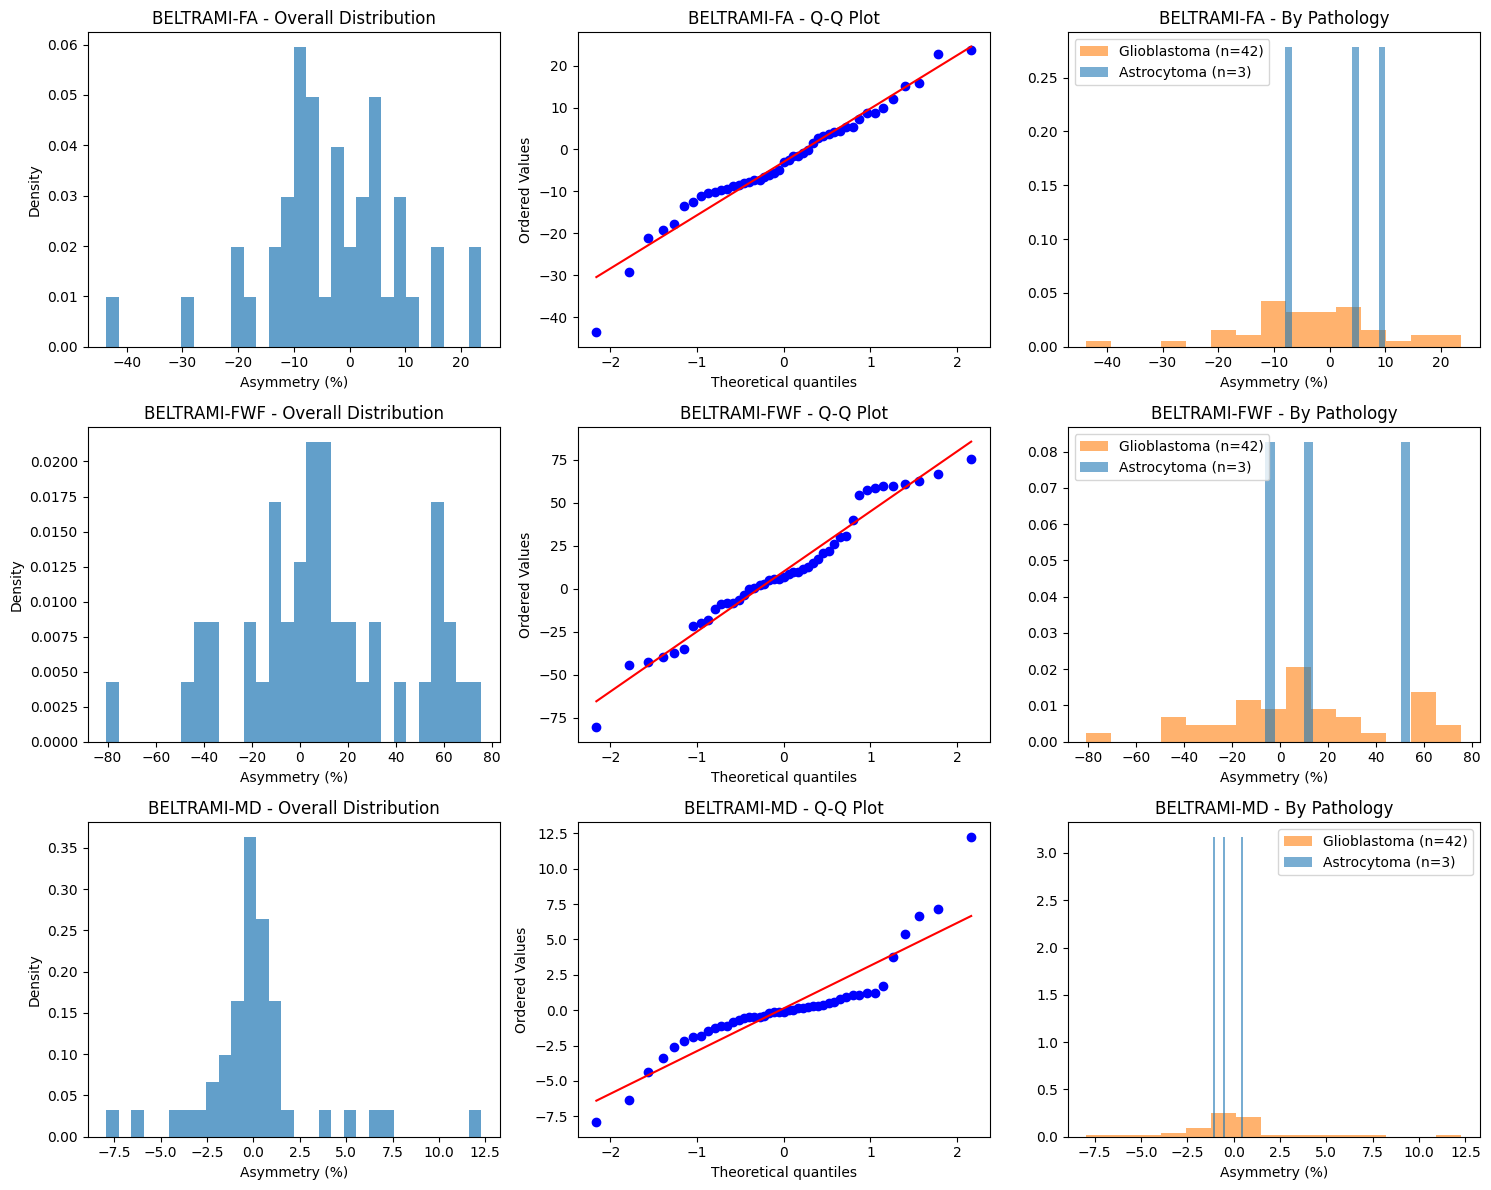

Plots created. Look for:
• Histograms: Normal = bell-shaped, symmetric
• Q-Q plots: Normal = points follow diagonal line
• Pathology differences: Check if distributions look similar

SUMMARY AND STATISTICAL TEST RECOMMENDATIONS - PATHOLOGY
Dataset summary:
• 45 participants
• 3 measures: BELTRAMI-FA, BELTRAMI-FWF, BELTRAMI-MD

Sample sizes by pathology:
pathology     Astrocytoma  Glioblastoma
measure                                
BELTRAMI-FA             3            42
BELTRAMI-FWF            3            42
BELTRAMI-MD             3            42

Based on typical neuroimaging asymmetry data characteristics:

RECOMMENDATIONS:
1. UNADJUSTED COMPARISONS:
   → Use Kruskal-Wallis test for 3-group comparison
   → Follow up with pairwise Mann-Whitney U tests
   → Brain asymmetry data is rarely normal
   → Sample sizes adequate for non-parametric tests

2. ADJUSTED COMPARISONS:
   → Use linear regression with dummy coding
   → Reference group: Glioblastoma (largest group)
   → Control for 

In [10]:
# Load the saved patient list
final_patients = pd.read_csv('final_analysis_cohort.csv')
final_participant_list = final_patients['participant'].tolist()

# Load and prepare data (abbreviated version)
metadata = pd.read_csv('UCSF-PDGM-metadata_v5_cleaned.csv')
tracts = pd.read_csv('UCSF-PDGM-v5_profiles_20250819.csv')

# Convert metadata IDs to match tract format
metadata['participant'] = 'sub-' + metadata['ID'].str.extract(r'UCSF-PDGM-(\d+)')[0].str.zfill(4)

# Merge datasets and filter to matched cohort
df = tracts.merge(metadata, on='participant', how='inner')
df = df[df['participant'].isin(final_participant_list)]

# Create analysis variables
df['hemisphere'] = df['tract'].str.extract('(Left|Right)')[0]
df['tract_base'] = df['tract'].str.replace('Left|Right', '', regex=True)
df['any_tumor'] = df[['TUMOR-1', 'TUMOR-2', 'TUMOR-4']].max(axis=1)
df['tumor_affected'] = (df['any_tumor'] > 0.05).astype(int)

def quick_asymmetry_calculation_pathology():
    """
    Quick asymmetry calculation for pathology normality testing
    """
    print("Calculating asymmetry data for pathology normality testing...")
    
    # Simplified version - just get some asymmetry data
    asymmetry_data = []
    
    for participant in df['participant'].unique()[:50]:  # Test with first 50 subjects for speed
        subj_data = df[df['participant'] == participant]
        participant_info = subj_data.iloc[0]
        
        # Skip if no pathology data
        if pd.isna(participant_info.get('Pathology')):
            continue
        
        for tract_base in subj_data['tract_base'].unique()[:3]:  # Test with first 3 tract types
            # Get left and right versions
            left_tract = subj_data[(subj_data['tract_base'] == tract_base) & 
                                  (subj_data['hemisphere'] == 'Left')]
            right_tract = subj_data[(subj_data['tract_base'] == tract_base) & 
                                   (subj_data['hemisphere'] == 'Right')]
            
            if len(left_tract) == 0 or len(right_tract) == 0:
                continue
            
            # Determine unilateral involvement (simplified)
            left_tumor_prop = left_tract['tumor_affected'].mean()
            right_tumor_prop = right_tract['tumor_affected'].mean()
            
            bilateral_threshold = 0.05
            is_left_unilateral = (left_tumor_prop > bilateral_threshold and 
                                 right_tumor_prop < bilateral_threshold)
            is_right_unilateral = (right_tumor_prop > bilateral_threshold and 
                                  left_tumor_prop < bilateral_threshold)
            
            if not (is_left_unilateral or is_right_unilateral):
                continue
                
            tumor_side = 'Left' if is_left_unilateral else 'Right'
            healthy_side = 'Right' if is_left_unilateral else 'Left'
            
            # Get clean nodes on tumor side
            tumor_tract = left_tract if tumor_side == 'Left' else right_tract
            healthy_tract = right_tract if tumor_side == 'Left' else left_tract
            
            clean_tumor_nodes = tumor_tract[tumor_tract['tumor_affected'] == 0]
            
            for _, tumor_node in clean_tumor_nodes.iterrows():
                node_num = tumor_node['node']
                healthy_node = healthy_tract[healthy_tract['node'] == node_num]
                
                if len(healthy_node) == 0:
                    continue
                    
                healthy_node = healthy_node.iloc[0]
                
                # Calculate asymmetry for each BELTRAMI measure
                for measure in ['BELTRAMI-FA', 'BELTRAMI-FWF', 'BELTRAMI-MD']:
                    tumor_val = tumor_node[measure]
                    healthy_val = healthy_node[measure]
                    
                    if pd.isna(tumor_val) or pd.isna(healthy_val) or (tumor_val + healthy_val) == 0:
                        continue
                    
                    mean_val = (tumor_val + healthy_val) / 2
                    asymmetry = (tumor_val - healthy_val) / mean_val * 100
                    
                    asymmetry_data.append({
                        'participant': participant,
                        'measure': measure,
                        'asymmetry': asymmetry,
                        'pathology': participant_info['Pathology']
                    })
    
    return pd.DataFrame(asymmetry_data)

def test_normality_comprehensive(data, group_col, value_col, group_name):
    """
    Comprehensive normality testing for each group
    """
    print(f"\n{'='*80}")
    print(f"NORMALITY TESTING: {group_name.upper()}")
    print(f"{'='*80}")
    
    groups = data[group_col].dropna().unique()
    
    for group in groups:
        group_data = data[data[group_col] == group][value_col].dropna()
        
        if len(group_data) < 10:
            print(f"\n{group}: Too few observations (n={len(group_data)}) for reliable testing")
            continue
            
        print(f"\n{group} (n={len(group_data)}):")
        print("-" * 40)
        
        # Descriptive statistics
        print(f"Mean: {group_data.mean():.3f}")
        print(f"Std:  {group_data.std():.3f}")
        print(f"Skew: {stats.skew(group_data):.3f}")
        print(f"Kurt: {stats.kurtosis(group_data):.3f}")
        print(f"Range: [{group_data.min():.3f}, {group_data.max():.3f}]")
        
        # Normality tests
        print(f"\nNormality Tests:")
        
        # Shapiro-Wilk (best for n < 50, still informative for larger n)
        if len(group_data) <= 5000:  # Shapiro-Wilk has sample size limits
            try:
                sw_stat, sw_p = shapiro(group_data)
                print(f"Shapiro-Wilk:     W={sw_stat:.4f}, p={sw_p:.4g}")
            except:
                print(f"Shapiro-Wilk:     Failed")
        
        # D'Agostino's normality test (good for larger samples)
        if len(group_data) >= 20:
            try:
                da_stat, da_p = normaltest(group_data)
                print(f"D'Agostino:       χ²={da_stat:.4f}, p={da_p:.4g}")
            except:
                print(f"D'Agostino:       Failed")
        
        # Anderson-Darling test
        try:
            ad_result = anderson(group_data, dist='norm')
            critical_vals = ad_result.critical_values
            significance_levels = ad_result.significance_level
            
            print(f"Anderson-Darling: A²={ad_result.statistic:.4f}")
            for i, (cv, sl) in enumerate(zip(critical_vals, significance_levels)):
                reject = "REJECT" if ad_result.statistic > cv else "ACCEPT"
                print(f"  α={sl/100:.3f}: {reject} normality (critical={cv:.3f})")
        except:
            print(f"Anderson-Darling: Failed")
        
        # Interpretation
        print(f"\nInterpretation:")
        if len(group_data) >= 20:
            try:
                _, da_p = normaltest(group_data)
                if da_p < 0.001:
                    print("  STRONG evidence against normality (p < 0.001)")
                elif da_p < 0.01:
                    print("  MODERATE evidence against normality (p < 0.01)")
                elif da_p < 0.05:
                    print("  WEAK evidence against normality (p < 0.05)")
                else:
                    print("  INSUFFICIENT evidence against normality (p ≥ 0.05)")
            except:
                print("  Unable to determine")

def test_normality_by_pathology_and_measure(asymmetry_df):
    """
    Test normality for each measure and pathology combination
    """
    print(f"\n{'='*80}")
    print("NORMALITY TESTING BY MEASURE AND PATHOLOGY")
    print(f"{'='*80}")
    
    # Collapse to subject-level first (like in your main analysis)
    subject_level = (asymmetry_df
                     .groupby(['participant','measure','pathology'], dropna=False)
                     ['asymmetry']
                     .mean()
                     .reset_index())
    
    print(f"Subject-level data: {len(subject_level)} observations from {subject_level['participant'].nunique()} participants")
    
    # Test each measure
    for measure in subject_level['measure'].unique():
        measure_data = subject_level[subject_level['measure'] == measure]
        
        print(f"\n{'='*60}")
        print(f"MEASURE: {measure}")
        print(f"{'='*60}")
        
        # Test pathology groups
        test_normality_comprehensive(measure_data, 'pathology', 'asymmetry', f'{measure} by Pathology')

def create_normality_plots_pathology(asymmetry_df):
    """
    Create visual diagnostics for normality - pathology version
    """
    print(f"\n{'='*80}")
    print("CREATING NORMALITY DIAGNOSTIC PLOTS FOR PATHOLOGY")
    print(f"{'='*80}")
    
    # Collapse to subject-level
    subject_level = (asymmetry_df
                     .groupby(['participant','measure','pathology'], dropna=False)
                     ['asymmetry']
                     .mean()
                     .reset_index())
    
    # Create plots for each measure
    measures = subject_level['measure'].unique()
    fig, axes = plt.subplots(len(measures), 3, figsize=(15, 4*len(measures)))
    if len(measures) == 1:
        axes = axes.reshape(1, -1)
    
    # Define colors for each pathology type
    pathology_colors = {'Astrocytoma': '#1f77b4', 'Glioblastoma': '#ff7f0e', 'Oligodendroglioma': '#2ca02c'}
    
    for i, measure in enumerate(measures):
        measure_data = subject_level[subject_level['measure'] == measure]
        
        # Overall histogram
        axes[i,0].hist(measure_data['asymmetry'].dropna(), bins=30, alpha=0.7, density=True)
        axes[i,0].set_title(f'{measure} - Overall Distribution')
        axes[i,0].set_xlabel('Asymmetry (%)')
        axes[i,0].set_ylabel('Density')
        
        # Q-Q plot
        stats.probplot(measure_data['asymmetry'].dropna(), dist="norm", plot=axes[i,1])
        axes[i,1].set_title(f'{measure} - Q-Q Plot')
        
        # By Pathology
        for pathology in measure_data['pathology'].dropna().unique():
            pathology_data = measure_data[measure_data['pathology'] == pathology]['asymmetry'].dropna()
            if len(pathology_data) > 0:
                color = pathology_colors.get(pathology, None)
                axes[i,2].hist(pathology_data, alpha=0.6, label=f'{pathology} (n={len(pathology_data)})', 
                              bins=15, density=True, color=color)
        axes[i,2].set_title(f'{measure} - By Pathology')
        axes[i,2].set_xlabel('Asymmetry (%)')
        axes[i,2].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Plots created. Look for:")
    print("• Histograms: Normal = bell-shaped, symmetric")
    print("• Q-Q plots: Normal = points follow diagonal line")
    print("• Pathology differences: Check if distributions look similar")

def summary_and_recommendations_pathology(asymmetry_df):
    """
    Provide summary and statistical test recommendations for pathology analysis
    """
    print(f"\n{'='*80}")
    print("SUMMARY AND STATISTICAL TEST RECOMMENDATIONS - PATHOLOGY")
    print(f"{'='*80}")
    
    # Quick summary stats
    subject_level = (asymmetry_df
                     .groupby(['participant','measure','pathology'], dropna=False)
                     ['asymmetry']
                     .mean()
                     .reset_index())
    
    print(f"Dataset summary:")
    print(f"• {subject_level['participant'].nunique()} participants")
    print(f"• {len(subject_level['measure'].unique())} measures: {', '.join(subject_level['measure'].unique())}")
    
    pathology_counts = subject_level.groupby('measure')['pathology'].value_counts().unstack(fill_value=0)
    
    print(f"\nSample sizes by pathology:")
    print(pathology_counts)
    
    print(f"\nBased on typical neuroimaging asymmetry data characteristics:")
    print(f"\nRECOMMENDATIONS:")
    print(f"1. UNADJUSTED COMPARISONS:")
    print(f"   → Use Kruskal-Wallis test for 3-group comparison")
    print(f"   → Follow up with pairwise Mann-Whitney U tests")
    print(f"   → Brain asymmetry data is rarely normal")
    print(f"   → Sample sizes adequate for non-parametric tests")
    
    print(f"\n2. ADJUSTED COMPARISONS:")
    print(f"   → Use linear regression with dummy coding")
    print(f"   → Reference group: Glioblastoma (largest group)")
    print(f"   → Control for age and sex only (avoid over-adjustment)")
    print(f"   → Check residuals for normality after fitting")
    
    print(f"\n3. MULTIPLE COMPARISONS:")
    print(f"   → For 3-way Kruskal-Wallis: correct across measures")
    print(f"   → For pairwise comparisons: correct within each measure")
    print(f"   → Use Benjamini-Hochberg FDR correction")
    print(f"   → Consider effect sizes (eta-squared for K-W, Cohen's d for pairwise)")
    
    print(f"\n4. INTERPRETATION:")
    print(f"   → Focus on pairwise differences vs Glioblastoma")
    print(f"   → Look for consistent patterns across BELTRAMI measures")
    print(f"   → Consider biological plausibility of findings")
    
    print(f"\nThis approach properly handles the 3-group pathology comparison")

# Run the pathology normality testing pipeline
print("NORMALITY TESTING FOR ASYMMETRY DATA - PATHOLOGY ANALYSIS")
print("="*65)

# Step 1: Get asymmetry data for pathology (quick version)
asymmetry_df = quick_asymmetry_calculation_pathology()

if len(asymmetry_df) > 0:
    print(f"Generated {len(asymmetry_df)} asymmetry observations for pathology testing")
    
    # Check pathology distribution
    pathology_counts = asymmetry_df['pathology'].value_counts()
    print(f"\nPathology distribution in asymmetry data:")
    for pathology, count in pathology_counts.items():
        print(f"  {pathology}: {count} observations")
    
    # Step 2: Test normality by pathology and measure
    test_normality_by_pathology_and_measure(asymmetry_df)
    
    # Step 3: Create diagnostic plots
    create_normality_plots_pathology(asymmetry_df)
    
    # Step 4: Summary and recommendations
    summary_and_recommendations_pathology(asymmetry_df)
    
else:
    print("No asymmetry data generated - check data paths and filtering")

### Complete hemispheric asymmetry

In [11]:
# Load and prepare the data
final_patients = pd.read_csv('final_analysis_cohort.csv')
final_participant_list = final_patients['participant'].tolist()
metadata = pd.read_csv('UCSF-PDGM-metadata_v5_cleaned.csv')
tracts = pd.read_csv('UCSF-PDGM-v5_profiles_20250819.csv')
metadata['participant'] = 'sub-' + metadata['ID'].str.extract(r'UCSF-PDGM-(\d+)')[0].str.zfill(4)

# Merge datasets and filter to matched cohort
df = tracts.merge(metadata, on='participant', how='inner')
df = df[df['participant'].isin(final_participant_list)]

# Create analysis variables (pathology only)
df['hemisphere'] = df['tract'].str.extract('(Left|Right)')[0]
df['tract_base'] = df['tract'].str.replace('Left|Right', '', regex=True)
df['pathology'] = df['Pathology']  # Keep original pathology labels

# Define tumor involvement
df['any_tumor'] = df[['TUMOR-1', 'TUMOR-2', 'TUMOR-4']].max(axis=1)
df['tumor_affected'] = (df['any_tumor'] > 0.05).astype(int)

print(f"Dataset: {len(df):,} rows, {df['participant'].nunique()} subjects")
print(f"Pathology distribution: {df.groupby('participant')['pathology'].first().value_counts().to_dict()}")

def identify_unilateral_tumor_cases():
    """
    Identify cases with unilateral tumor involvement for contralateral comparison
    """
    print(f"\n{'='*80}")
    print("IDENTIFYING UNILATERAL TUMOR CASES")
    print(f"{'='*80}")
    
    unilateral_cases = []
    bilateral_threshold = 0.05  # 5% involvement threshold
    
    for participant in df['participant'].unique():
        subj_data = df[df['participant'] == participant]
        participant_info = subj_data.iloc[0]
        
        for tract_base in subj_data['tract_base'].unique():
            # Get left and right versions of this tract
            left_tract = subj_data[(subj_data['tract_base'] == tract_base) & 
                                  (subj_data['hemisphere'] == 'Left')]
            right_tract = subj_data[(subj_data['tract_base'] == tract_base) & 
                                   (subj_data['hemisphere'] == 'Right')]
            
            if len(left_tract) == 0 or len(right_tract) == 0:
                continue
            
            # Calculate tumor involvement proportions
            left_tumor_prop = left_tract['tumor_affected'].mean()
            right_tumor_prop = right_tract['tumor_affected'].mean()
            
            # Determine if unilateral
            is_left_unilateral = (left_tumor_prop > bilateral_threshold and 
                                 right_tumor_prop < bilateral_threshold)
            is_right_unilateral = (right_tumor_prop > bilateral_threshold and 
                                  left_tumor_prop < bilateral_threshold)
            
            if is_left_unilateral or is_right_unilateral:
                tumor_side = 'Left' if is_left_unilateral else 'Right'
                healthy_side = 'Right' if is_left_unilateral else 'Left'
                tumor_involvement = left_tumor_prop if is_left_unilateral else right_tumor_prop
                
                unilateral_cases.append({
                    'participant': participant,
                    'tract_base': tract_base,
                    'tumor_side': tumor_side,
                    'healthy_side': healthy_side,
                    'tumor_involvement': tumor_involvement,
                    'pathology': participant_info['pathology']
                })
    
    unilateral_df = pd.DataFrame(unilateral_cases)
    
    print(f"Unilateral tumor cases identified: {len(unilateral_df)}")
    print(f"Participants: {unilateral_df['participant'].nunique()}")
    print(f"Tract types: {unilateral_df['tract_base'].nunique()}")
    
    return unilateral_df

def calculate_contralateral_asymmetry(unilateral_df):
    """
    Calculate DIRECTIONAL asymmetry between tumor-affected and healthy hemispheres
    Only analyzing non-tumor-involved nodes
    """
    print(f"\n{'='*80}")
    print("CALCULATING DIRECTIONAL CONTRALATERAL ASYMMETRY IN CLEAN TISSUE")
    print(f"{'='*80}")
    print("Asymmetry = (ipsilateral - contralateral) / mean * 100%")
    print("Positive values: ipsilateral > contralateral")
    print("Negative values: ipsilateral < contralateral")
    
    asymmetry_data = []
    
    for _, case in unilateral_df.iterrows():
        participant = case['participant']
        tract_base = case['tract_base']
        tumor_side = case['tumor_side']
        healthy_side = case['healthy_side']
        
        # Get tumor-side tract (only non-tumor nodes) - IPSILATERAL
        ipsilateral_tract = df[(df['participant'] == participant) & 
                              (df['tract_base'] == tract_base) & 
                              (df['hemisphere'] == tumor_side) &
                              (df['tumor_affected'] == 0)].sort_values('node')  # CLEAN NODES ONLY
        
        # Get healthy-side tract - CONTRALATERAL
        contralateral_tract = df[(df['participant'] == participant) & 
                                (df['tract_base'] == tract_base) & 
                                (df['hemisphere'] == healthy_side)].sort_values('node')
        
        if len(ipsilateral_tract) == 0 or len(contralateral_tract) == 0:
            continue
        
        # For each clean node on ipsilateral side, find corresponding node on contralateral side
        for _, ipsilateral_node in ipsilateral_tract.iterrows():
            node_num = ipsilateral_node['node']
            
            # Find corresponding node on contralateral side
            contralateral_node = contralateral_tract[contralateral_tract['node'] == node_num]
            if len(contralateral_node) == 0:
                continue
            
            contralateral_node = contralateral_node.iloc[0]
            
            # Calculate DIRECTIONAL asymmetry for each BELTRAMI measure
            for measure in ['BELTRAMI-FA', 'BELTRAMI-FWF', 'BELTRAMI-MD']:
                ipsilateral_val = ipsilateral_node[measure]
                contralateral_val = contralateral_node[measure]
                
                # Skip if either value is invalid
                if pd.isna(ipsilateral_val) or pd.isna(contralateral_val) or (ipsilateral_val + contralateral_val) == 0:
                    continue
                
                # Calculate DIRECTIONAL percent asymmetry: (ipsilateral - contralateral) / mean * 100
                mean_val = (ipsilateral_val + contralateral_val) / 2
                asymmetry = (ipsilateral_val - contralateral_val) / mean_val * 100
                
                asymmetry_data.append({
                    'participant': participant,
                    'tract_base': tract_base,
                    'node': node_num,
                    'measure': measure,
                    'pathology': case['pathology'],
                    'asymmetry': asymmetry  # DIRECTIONAL asymmetry
                })
    
    asymmetry_df = pd.DataFrame(asymmetry_data)
    
    print(f"Clean node asymmetry dataset: {len(asymmetry_df):,} observations")
    print(f"Participants: {asymmetry_df['participant'].nunique()}")
    print(f"Tract types: {asymmetry_df['tract_base'].nunique()}")
    
    return asymmetry_df

def collapse_to_subject_level(asymmetry_df):
    """
    Collapse to subject-level means for proper statistical analysis
    """
    print(f"\n{'='*80}")
    print("COLLAPSING TO SUBJECT-LEVEL MEANS")
    print(f"{'='*80}")
    
    # Collapse to subject-level means - PATHOLOGY ONLY
    subject_level = (asymmetry_df
                     .groupby(['participant','measure','pathology'], dropna=False)
                     ['asymmetry']
                     .mean()
                     .reset_index())
    
    print("\nSUBJECT-LEVEL CLEAN TISSUE ASYMMETRY")
    print(subject_level.groupby('measure')['asymmetry'].describe()[['count','mean','std']])
    
    return subject_level

def display_pathology_asymmetry_values(subject_level):
    """
    Display actual asymmetry values (mean ± SD) for each pathology group by measure
    """
    print(f"\n{'='*80}")
    print("ASYMMETRY VALUES BY PATHOLOGY")
    print(f"{'='*80}")
    print("Values shown as: Mean ± SD (N)")
    print("Asymmetry = (ipsilateral - contralateral) / mean * 100%")
    print("Positive values: ipsilateral > contralateral")
    print("Negative values: ipsilateral < contralateral")
    
    # Get available pathologies
    pathology_order = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
    available_pathologies = [p for p in pathology_order if p in subject_level['pathology'].values]
    
    for measure in subject_level['measure'].unique():
        print(f"\n{measure} ASYMMETRY VALUES:")
        print("=" * 60)
        
        measure_data = subject_level[subject_level['measure'] == measure]
        
        for pathology in available_pathologies:
            path_data = measure_data[measure_data['pathology'] == pathology]['asymmetry']
            
            if len(path_data) > 0:
                mean_val = path_data.mean()
                std_val = path_data.std(ddof=1)
                n_val = len(path_data)
                median_val = path_data.median()
                
                # Format with appropriate precision based on measure
                if measure == 'BELTRAMI-MD':
                    print(f"  {pathology}: {mean_val:+.4f} ± {std_val:.4f} (n={n_val}), median={median_val:+.4f}")
                else:
                    print(f"  {pathology}: {mean_val:+.3f} ± {std_val:.3f} (n={n_val}), median={median_val:+.3f}")
            else:
                print(f"  {pathology}: No data")
    
    # Create a summary table
    print(f"\n{'='*80}")
    print("SUMMARY TABLE")
    print(f"{'='*80}")
    
    summary_data = []
    for measure in subject_level['measure'].unique():
        measure_data = subject_level[subject_level['measure'] == measure]
        
        for pathology in available_pathologies:
            path_data = measure_data[measure_data['pathology'] == pathology]['asymmetry']
            
            if len(path_data) > 0:
                summary_data.append({
                    'Measure': measure.replace('BELTRAMI-', ''),
                    'Pathology': pathology,
                    'N': len(path_data),
                    'Mean': path_data.mean(),
                    'SD': path_data.std(ddof=1),
                    'Median': path_data.median(),
                    'Min': path_data.min(),
                    'Max': path_data.max()
                })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        
        # Print formatted table
        for measure in summary_df['Measure'].unique():
            measure_summary = summary_df[summary_df['Measure'] == measure]
            print(f"\n{measure} Summary:")
            print("-" * 70)
            print(f"{'Pathology':<15} {'N':<5} {'Mean':<10} {'SD':<10} {'Median':<10} {'Range':<15}")
            print("-" * 70)
            
            for _, row in measure_summary.iterrows():
                range_str = f"[{row['Min']:+.3f}, {row['Max']:+.3f}]"
                print(f"{row['Pathology']:<15} {row['N']:<5} {row['Mean']:+.3f}     {row['SD']:.3f}     "
                      f"{row['Median']:+.3f}     {range_str:<15}")
    
    return summary_data

def compare_pathology_groups_3way_unadjusted(subj_df, title=''):
    """
    3-way pathology comparison using unadjusted tests only:
    1. Kruskal-Wallis overall test
    2. All pairwise Mann-Whitney U comparisons
    """
    print(f"\n{'='*80}")
    print(title.upper() if title else "PATHOLOGY EFFECTS (3-WAY COMPARISON - UNADJUSTED)")
    print(f"{'='*80}")
    
    results = []
    pathology_order = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
    
    for measure in subj_df['measure'].unique():
        data = subj_df[subj_df['measure']==measure].dropna(subset=['pathology', 'asymmetry'])
        
        # Filter to available pathologies
        available_pathologies = [p for p in pathology_order if p in data['pathology'].values]
        data_filtered = data[data['pathology'].isin(available_pathologies)]
        
        if len(available_pathologies) < 2:
            print(f"\n{measure}: Insufficient pathology groups ({len(available_pathologies)})")
            continue
        
        print(f"\n{measure} (n={len(data_filtered)} from {len(available_pathologies)} pathology types):")
        
        # Sample sizes and descriptives
        for pathology in available_pathologies:
            path_data = data_filtered[data_filtered['pathology'] == pathology]['asymmetry']
            n = len(path_data)
            mean = path_data.mean()
            sd = path_data.std(ddof=1)
            median = path_data.median()
            print(f"  {pathology}: mean={mean:+.3f}±{sd:.3f}, median={median:+.3f} (n={n})")
        
        # ========== 1. KRUSKAL-WALLIS OVERALL TEST ==========
        if len(available_pathologies) >= 3:
            try:
                groups = [data_filtered[data_filtered['pathology'] == p]['asymmetry'].values 
                         for p in available_pathologies]
                kw_stat, kw_p = kruskal(*groups)
                print(f"  Kruskal-Wallis overall: χ²={kw_stat:.3f}, p={kw_p:.4g}")
                
                results.append({
                    'measure': measure,
                    'analysis': 'kruskal_wallis_overall',
                    'test_type': 'Kruskal-Wallis',
                    'p_value': kw_p,
                    'statistic': kw_stat,
                    'n_groups': len(available_pathologies),
                    'total_n': len(data_filtered)
                })
            except Exception as e:
                print(f"  Kruskal-Wallis failed: {e}")
        
        # ========== 2. PAIRWISE MANN-WHITNEY U TESTS ==========
        pairwise_comparisons = [
            ('Glioblastoma', 'Astrocytoma'),
            ('Glioblastoma', 'Oligodendroglioma'), 
            ('Astrocytoma', 'Oligodendroglioma')
        ]
        
        for path1, path2 in pairwise_comparisons:
            if path1 in available_pathologies and path2 in available_pathologies:
                vals1 = data_filtered[data_filtered['pathology'] == path1]['asymmetry']
                vals2 = data_filtered[data_filtered['pathology'] == path2]['asymmetry']
                
                if len(vals1) >= 3 and len(vals2) >= 3:
                    try:
                        mw_stat, mw_p = mannwhitneyu(vals2, vals1, alternative='two-sided')
                        
                        # Effect size (Cohen's d)
                        mean_diff = vals2.mean() - vals1.mean()
                        pooled_std = np.sqrt(((len(vals1)-1)*vals1.std(ddof=1)**2 + 
                                            (len(vals2)-1)*vals2.std(ddof=1)**2) / 
                                           (len(vals1)+len(vals2)-2))
                        cohens_d = mean_diff / pooled_std if pooled_std > 0 else np.nan
                        
                        print(f"  {path2} vs {path1}: diff={mean_diff:+.3f}, d={cohens_d:.3f}, "
                              f"p={mw_p:.4g} (n={len(vals1)+len(vals2)})")
                        
                        results.append({
                            'measure': measure,
                            'analysis': f'pairwise_{path2}_vs_{path1}',
                            'test_type': 'Mann-Whitney U',
                            'comparison': f'{path2} vs {path1}',
                            'path1': path1, 'path2': path2,
                            'mean1': vals1.mean(), 'mean2': vals2.mean(),
                            'diff': mean_diff, 'cohens_d': cohens_d,
                            'p_value': mw_p, 'n1': len(vals1), 'n2': len(vals2)
                        })
                    except Exception as e:
                        print(f"  {path2} vs {path1}: Failed - {e}")
    
    return results

def apply_pathology_fdr_correction_targeted(pathology_results):
    """
    Apply FDR correction across FA, MD, and FWF for 3-way tests
    Separate correction for Kruskal-Wallis (across measures) vs Mann-Whitney U (within measure)
    """
    print(f"\n{'='*80}")
    print("MODIFIED FDR CORRECTION - PATHOLOGY ANALYSIS")
    print("Kruskal-Wallis: FDR across FA, MD, FWF measures")
    print("Mann-Whitney U: FDR within each measure separately")
    print(f"{'='*80}")
    
    # Convert to DataFrame for easier manipulation
    results_df = pd.DataFrame(pathology_results)
    if results_df.empty:
        print("No results to correct")
        return {'overall': [], 'pairwise': []}
    
    # Add FDR columns
    results_df['p_fdr'] = np.nan
    results_df['significant_fdr'] = False
    
    # 1. KRUSKAL-WALLIS: Apply FDR correction ACROSS all measures (FA, MD, FWF)
    kw_mask = (results_df['test_type'] == 'Kruskal-Wallis') & results_df['p_value'].notna()
    
    if kw_mask.any():
        reject, qvals, _, _ = multipletests(results_df.loc[kw_mask, 'p_value'].values, 
                                          alpha=0.05, method='fdr_bh')
        results_df.loc[kw_mask, 'p_fdr'] = qvals
        results_df.loc[kw_mask, 'significant_fdr'] = reject
        
        # Print summary for Kruskal-Wallis family
        n_tests = kw_mask.sum()
        n_sig_before = sum(results_df.loc[kw_mask, 'p_value'] < 0.05)
        n_sig_after = sum(reject)
        
        print(f"\nKruskal-Wallis tests (across FA, MD, FWF):")
        print(f"  Tests: {n_tests}")
        print(f"  Significant before correction: {n_sig_before}")
        print(f"  Significant after FDR correction: {n_sig_after}")
    
    # 2. MANN-WHITNEY U: Apply FDR correction WITHIN each measure separately
    for measure in results_df['measure'].unique():
        mw_mask = ((results_df['test_type'] == 'Mann-Whitney U') & 
                   (results_df['measure'] == measure) & 
                   results_df['p_value'].notna())
        
        if mw_mask.any():
            reject, qvals, _, _ = multipletests(results_df.loc[mw_mask, 'p_value'].values, 
                                              alpha=0.05, method='fdr_bh')
            results_df.loc[mw_mask, 'p_fdr'] = qvals
            results_df.loc[mw_mask, 'significant_fdr'] = reject
            
            # Print summary for this measure
            n_tests = mw_mask.sum()
            n_sig_before = sum(results_df.loc[mw_mask, 'p_value'] < 0.05)
            n_sig_after = sum(reject)
            
            print(f"\nMann-Whitney U - {measure}:")
            print(f"  Tests: {n_tests}")
            print(f"  Significant before correction: {n_sig_before}")
            print(f"  Significant after FDR correction: {n_sig_after}")
    
    # Print detailed results table
    print(f"\n{'='*80}")
    print("DETAILED RESULTS TABLE")
    print(f"{'='*80}")
    
    # Overall tests
    overall_results = results_df[results_df['test_type'] == 'Kruskal-Wallis']
    if not overall_results.empty:
        print(f"\nOVERALL TESTS (Kruskal-Wallis) - FDR across FA, MD, FWF:")
        print(f"{'Measure':<15} {'Statistic':<10} {'Raw p':<8} {'FDR p':<8} {'Sig':<5}")
        print("-" * 50)
        for _, row in overall_results.iterrows():
            sig = "*" if row['significant_fdr'] else ""
            print(f"{row['measure']:<15} {row['statistic']:.3f}    {row['p_value']:.4f}  "
                  f"{row['p_fdr']:.4f}  {sig:<5}")
    
    # Pairwise tests
    pairwise_results = results_df[results_df['test_type'] == 'Mann-Whitney U']
    if not pairwise_results.empty:
        print(f"\nPAIRWISE TESTS (Mann-Whitney U) - FDR within each measure:")
        print(f"{'Measure':<15} {'Comparison':<25} {'Diff':<8} {'Cohen_d':<8} {'Raw p':<8} {'FDR p':<8} {'Sig':<5}")
        print("-" * 85)
        for _, row in pairwise_results.iterrows():
            sig = "*" if row['significant_fdr'] else ""
            effect = row.get('diff', np.nan)
            effect_str = f"{effect:+.3f}" if not pd.isna(effect) else "N/A"
            cohens_d = row.get('cohens_d', np.nan)
            d_str = f"{cohens_d:.3f}" if not pd.isna(cohens_d) else "N/A"
            comparison = row.get('comparison', '')
            print(f"{row['measure']:<15} {comparison:<25} {effect_str:<8} {d_str:<8} "
                  f"{row['p_value']:.4f}  {row['p_fdr']:.4f}  {sig:<5}")
    
    # Convert back to the expected format
    overall_tests = []
    pairwise_tests = []
    
    for _, row in results_df.iterrows():
        test_dict = row.to_dict()
        if row['test_type'] == 'Kruskal-Wallis':
            overall_tests.append(test_dict)
        elif row['test_type'] == 'Mann-Whitney U':
            pairwise_tests.append(test_dict)
    
    return {
        'overall': overall_tests,
        'pairwise': pairwise_tests
    }

# Run the pathology-only analysis (unadjusted)
print("PATHOLOGY-ONLY SUBJECT-LEVEL ANALYSIS (NO AGE/SEX ADJUSTMENT)")
print("="*95)

# Step 1: Identify unilateral cases
unilateral_df = identify_unilateral_tumor_cases()

if len(unilateral_df) > 0:
    # Step 2: Calculate contralateral asymmetry in clean tissue
    asymmetry_df = calculate_contralateral_asymmetry(unilateral_df)
    
    if len(asymmetry_df) > 0:
        # Step 3: Collapse to subject-level means
        subject_level = collapse_to_subject_level(asymmetry_df)
        
        # Step 3.5: Display actual asymmetry values
        display_pathology_asymmetry_values(subject_level)
        
        # Step 4: Run 3-way pathology comparison (unadjusted only)
        pathology_results = compare_pathology_groups_3way_unadjusted(
            subject_level,
            title='Pathology Effects (3-way: Astrocytoma, Glioblastoma, Oligodendroglioma) - UNADJUSTED'
        )
        
        # Step 5: Apply FDR corrections
        pathology_results_corrected = apply_pathology_fdr_correction_targeted(pathology_results)
    
    else:
        print("No clean tissue asymmetry data generated")
        
else:
    print("No unilateral tumor cases identified")

Dataset: 928,800 rows, 459 subjects
Pathology distribution: {'Glioblastoma': 361, 'Astrocytoma': 87, 'Oligodendroglioma': 11}
PATHOLOGY-ONLY SUBJECT-LEVEL ANALYSIS (NO AGE/SEX ADJUSTMENT)

IDENTIFYING UNILATERAL TUMOR CASES
Unilateral tumor cases identified: 2240
Participants: 459
Tract types: 10

CALCULATING DIRECTIONAL CONTRALATERAL ASYMMETRY IN CLEAN TISSUE
Asymmetry = (ipsilateral - contralateral) / mean * 100%
Positive values: ipsilateral > contralateral
Negative values: ipsilateral < contralateral
Clean node asymmetry dataset: 294,699 observations
Participants: 459
Tract types: 10

COLLAPSING TO SUBJECT-LEVEL MEANS

SUBJECT-LEVEL CLEAN TISSUE ASYMMETRY
              count       mean        std
measure                                  
BELTRAMI-FA   459.0  -2.743806   6.977005
BELTRAMI-FWF  459.0  18.868013  30.331623
BELTRAMI-MD   459.0   0.145076   2.752131

ASYMMETRY VALUES BY PATHOLOGY
Values shown as: Mean ± SD (N)
Asymmetry = (ipsilateral - contralateral) / mean * 100%
Posit

### Distance-based tract asymmetry analyses

Filtered dataset: 928,800 rows, 459 subjects
Pathology distribution: {'Glioblastoma': 361, 'Astrocytoma': 87, 'Oligodendroglioma': 11}
PATHOLOGY DISTANCE ANALYSIS - UNADJUSTED ONLY
Using matched cohort of 459 patients from CSV file

IDENTIFYING UNILATERAL TUMOR CASES - PATHOLOGY ANALYSIS
Unilateral tumor cases: 2240
Participants: 459
Pathology distribution in unilateral cases:
pathology
Glioblastoma         361
Astrocytoma           87
Oligodendroglioma     11
Name: count, dtype: int64

CALCULATING DISTANCE-BASED ASYMMETRY - PATHOLOGY ANALYSIS
Approach: 1-5 nodes | 6-10 nodes | 11-15 nodes | 16-20 nodes | 21+ nodes
Distance-based asymmetry dataset: 286,275 clean node observations
Participants: 459

Distance distribution:
  1-5 nodes: 40,074 observations (14.0%)
  6-10 nodes: 36,573 observations (12.8%)
  11-15 nodes: 32,721 observations (11.4%)
  16-20 nodes: 29,505 observations (10.3%)
  21+ nodes: 147,402 observations (51.5%)

COLLAPSING TO SUBJECT-LEVEL MEANS BY DISTANCE BIN - PATHO

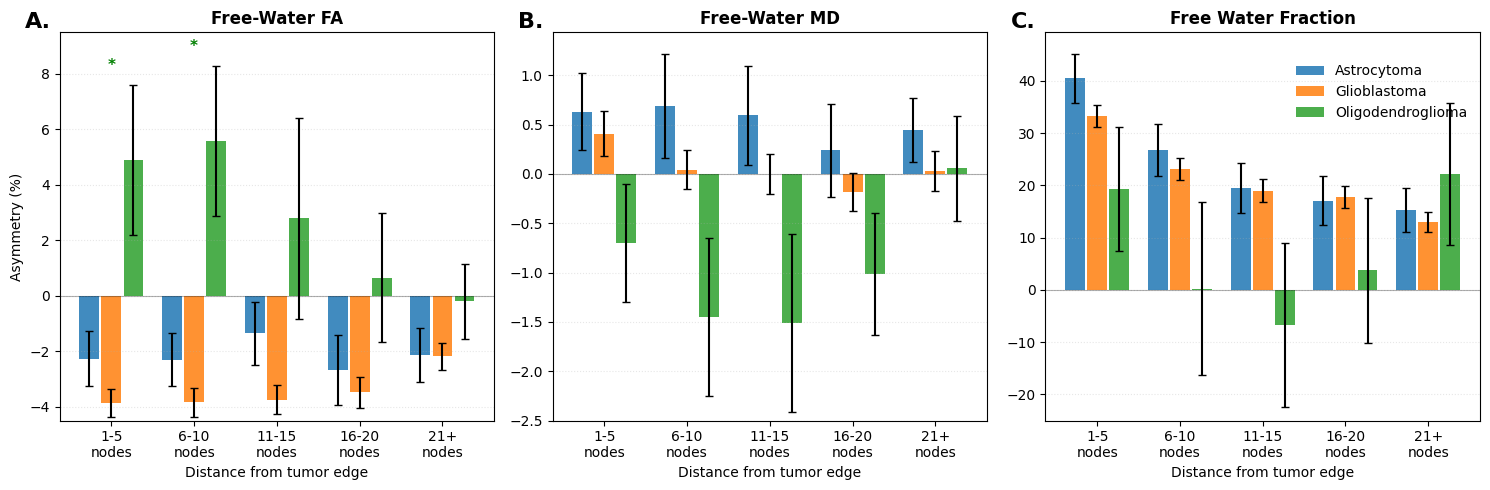


Plot Summary:
• Pathologies: Astrocytoma, Glioblastoma, Oligodendroglioma
• Distance bins: 1-5 nodes, 6-10 nodes, 11-15 nodes, 16-20 nodes, 21+ nodes
• Statistical significance: Mann-Whitney U pairwise comparisons
• * p < 0.05, ** p < 0.01, *** p < 0.001 (FDR-corrected)


In [12]:
# Load and prepare data
final_patients = pd.read_csv('final_analysis_cohort.csv')
final_participant_list = final_patients['participant'].tolist()
metadata = pd.read_csv('UCSF-PDGM-metadata_v5_cleaned.csv')
tracts = pd.read_csv('UCSF-PDGM-v5_profiles_20250819.csv')
metadata['participant'] = 'sub-' + metadata['ID'].str.extract(r'UCSF-PDGM-(\d+)')[0].str.zfill(4)

# Merge datasets and FILTER TO FINAL PATIENTS ONLY
df = tracts.merge(metadata, on='participant', how='inner')
df = df[df['participant'].isin(final_participant_list)]

# Create analysis variables - PATHOLOGY FOCUS
df['hemisphere'] = df['tract'].str.extract('(Left|Right)')[0]
df['tract_base'] = df['tract'].str.replace('Left|Right', '', regex=True)
df['pathology'] = df['Pathology']  # Keep pathology variable

# Define tumor involvement
df['any_tumor'] = df[['TUMOR-1', 'TUMOR-2', 'TUMOR-4']].max(axis=1)
df['tumor_affected'] = (df['any_tumor'] > 0.05).astype(int)

print(f"Filtered dataset: {len(df):,} rows, {df['participant'].nunique()} subjects")
print(f"Pathology distribution: {df.groupby('participant')['pathology'].first().value_counts().to_dict()}")

def identify_unilateral_tumor_cases_pathology():
    """
    Identify cases with unilateral tumor involvement - pathology analysis
    """
    print(f"\n{'='*80}")
    print("IDENTIFYING UNILATERAL TUMOR CASES - PATHOLOGY ANALYSIS")
    print(f"{'='*80}")
    
    unilateral_cases = []
    bilateral_threshold = 0.05
    
    for participant in df['participant'].unique():
        subj_data = df[df['participant'] == participant]
        participant_info = subj_data.iloc[0]
        
        # Skip if no pathology data
        if pd.isna(participant_info['pathology']):
            continue
        
        for tract_base in subj_data['tract_base'].unique():
            left_tract = subj_data[(subj_data['tract_base'] == tract_base) & 
                                  (subj_data['hemisphere'] == 'Left')]
            right_tract = subj_data[(subj_data['tract_base'] == tract_base) & 
                                   (subj_data['hemisphere'] == 'Right')]
            
            if len(left_tract) == 0 or len(right_tract) == 0:
                continue
            
            left_tumor_prop = left_tract['tumor_affected'].mean()
            right_tumor_prop = right_tract['tumor_affected'].mean()
            
            is_left_unilateral = (left_tumor_prop > bilateral_threshold and 
                                 right_tumor_prop < bilateral_threshold)
            is_right_unilateral = (right_tumor_prop > bilateral_threshold and 
                                  left_tumor_prop < bilateral_threshold)
            
            if is_left_unilateral or is_right_unilateral:
                tumor_side = 'Left' if is_left_unilateral else 'Right'
                healthy_side = 'Right' if is_left_unilateral else 'Left'
                tumor_involvement = left_tumor_prop if is_left_unilateral else right_tumor_prop
                
                unilateral_cases.append({
                    'participant': participant,
                    'tract_base': tract_base,
                    'tumor_side': tumor_side,
                    'healthy_side': healthy_side,
                    'tumor_involvement': tumor_involvement,
                    'pathology': participant_info['pathology']
                })
    
    unilateral_df = pd.DataFrame(unilateral_cases)
    
    print(f"Unilateral tumor cases: {len(unilateral_df)}")
    print(f"Participants: {unilateral_df['participant'].nunique()}")
    print(f"Pathology distribution in unilateral cases:")
    print(unilateral_df.groupby('participant')['pathology'].first().value_counts())
    
    return unilateral_df

def calculate_distance_based_asymmetry_pathology(unilateral_df):
    """
    Calculate asymmetry at different distances from tumor edge - pathology version
    """
    print(f"\n{'='*80}")
    print("CALCULATING DISTANCE-BASED ASYMMETRY - PATHOLOGY ANALYSIS")
    print(f"{'='*80}")
    print("Approach: 1-5 nodes | 6-10 nodes | 11-15 nodes | 16-20 nodes | 21+ nodes")
    
    distance_data = []
    
    for _, case in unilateral_df.iterrows():
        participant = case['participant']
        tract_base = case['tract_base']
        tumor_side = case['tumor_side']
        healthy_side = case['healthy_side']
        
        # Get tumor-side tract
        tumor_tract = df[(df['participant'] == participant) & 
                        (df['tract_base'] == tract_base) & 
                        (df['hemisphere'] == tumor_side)].sort_values('node')
        
        # Get healthy-side tract
        healthy_tract = df[(df['participant'] == participant) & 
                          (df['tract_base'] == tract_base) & 
                          (df['hemisphere'] == healthy_side)].sort_values('node')
        
        if len(tumor_tract) == 0 or len(healthy_tract) == 0:
            continue
        
        # Find tumor-affected nodes
        tumor_nodes = tumor_tract[tumor_tract['tumor_affected'] == 1]['node'].values
        
        if len(tumor_nodes) == 0:
            continue
        
        # Find tumor boundary nodes
        tumor_edge_min = tumor_nodes.min()
        tumor_edge_max = tumor_nodes.max()
        
        # For each CLEAN node on tumor side, calculate distance to nearest tumor edge
        clean_tumor_nodes = tumor_tract[tumor_tract['tumor_affected'] == 0]
        
        for _, tumor_node in clean_tumor_nodes.iterrows():
            node_num = tumor_node['node']
            
            # Calculate distance to nearest tumor edge
            dist_to_min_edge = abs(node_num - tumor_edge_min)
            dist_to_max_edge = abs(node_num - tumor_edge_max)
            distance_to_edge = min(dist_to_min_edge, dist_to_max_edge)
            
            # Skip nodes within tumor boundaries
            if tumor_edge_min <= node_num <= tumor_edge_max:
                continue
            
            # Find corresponding node on healthy side
            healthy_node = healthy_tract[healthy_tract['node'] == node_num]
            if len(healthy_node) == 0:
                continue
            
            healthy_node = healthy_node.iloc[0]
            
            # Calculate asymmetry for each BELTRAMI measure
            for measure in ['BELTRAMI-FA', 'BELTRAMI-FWF', 'BELTRAMI-MD']:
                tumor_val = tumor_node[measure]
                healthy_val = healthy_node[measure]
                
                # Skip if either value is invalid
                if pd.isna(tumor_val) or pd.isna(healthy_val) or (tumor_val + healthy_val) == 0:
                    continue
                
                # Calculate percent asymmetry: (tumor_side - healthy_side) / mean * 100
                mean_val = (tumor_val + healthy_val) / 2
                asymmetry = (tumor_val - healthy_val) / mean_val * 100
                
                distance_data.append({
                    'participant': participant,
                    'tract_base': tract_base,
                    'node': node_num,
                    'distance_to_edge': distance_to_edge,
                    'measure': measure,
                    'pathology': case['pathology'],
                    'tumor_val': tumor_val,
                    'healthy_val': healthy_val,
                    'asymmetry': asymmetry,
                    'tumor_involvement': case['tumor_involvement']
                })
    
    distance_df = pd.DataFrame(distance_data)
    
    if len(distance_df) == 0:
        print("No distance-based asymmetry data generated")
        return distance_df
    
    print(f"Distance-based asymmetry dataset: {len(distance_df):,} clean node observations")
    print(f"Participants: {distance_df['participant'].nunique()}")
    
    # Create uniform 5-node interval bins
    distance_df['distance_bin'] = pd.cut(
        distance_df['distance_to_edge'], 
        bins=[0, 6, 11, 16, 21, 100],
        labels=['1-5 nodes', '6-10 nodes', '11-15 nodes', '16-20 nodes', '21+ nodes'],
        right=False,
        include_lowest=True
    )
    
    print(f"\nDistance distribution:")
    distance_counts = distance_df['distance_bin'].value_counts().sort_index()
    for bin_name, count in distance_counts.items():
        pct = (count / len(distance_df)) * 100
        print(f"  {bin_name}: {count:,} observations ({pct:.1f}%)")
    
    return distance_df

def collapse_to_subject_level_distance_pathology(distance_df):
    """
    Collapse node-level to subject-level per distance bin - pathology version
    """
    print(f"\n{'='*80}")
    print("COLLAPSING TO SUBJECT-LEVEL MEANS BY DISTANCE BIN - PATHOLOGY")
    print(f"{'='*80}")
    
    # Step 1: Get subject-level asymmetry means
    subject_asymmetry = (
        distance_df
        .groupby(['participant', 'measure', 'distance_bin'])
        ['asymmetry'].mean()
        .reset_index()
    )
    
    # Step 2: Get participant-level pathology info (one per participant)
    participant_pathology = (
        distance_df
        .groupby('participant')
        ['pathology'].first()
        .reset_index()
    )
    
    # Step 3: Merge them together
    subject_distance = subject_asymmetry.merge(
        participant_pathology, 
        on='participant', 
        how='left'
    )
    
    print(f"Subject-level distance dataset: {len(subject_distance)} rows from "
          f"{subject_distance['participant'].nunique()} participants")
    
    # Check pathology distribution
    print("\nPathology distribution:")
    pathology_counts = subject_distance.groupby('participant')['pathology'].first().value_counts()
    print(pathology_counts)
    
    # Set categorical ordering
    available_pathologies = subject_distance['pathology'].dropna().unique()
    pathology_categories = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
    valid_categories = [p for p in pathology_categories if p in available_pathologies]
    
    if valid_categories:
        subject_distance['pathology'] = pd.Categorical(
            subject_distance['pathology'], 
            categories=valid_categories,
            ordered=True
        )
    
    # Ensure distance_bin is categorical with proper ordering
    distance_categories = ['1-5 nodes', '6-10 nodes', '11-15 nodes', '16-20 nodes', '21+ nodes']
    subject_distance['distance_bin'] = pd.Categorical(
        subject_distance['distance_bin'], 
        categories=distance_categories,
        ordered=True
    )
    
    print("\nSubject-level summary by distance bin and pathology:")
    for distance_bin in subject_distance['distance_bin'].cat.categories:
        bin_data = subject_distance[subject_distance['distance_bin'] == distance_bin]
        if len(bin_data) > 0:
            n_participants = bin_data['participant'].nunique()
            pathology_dist = bin_data.groupby('participant')['pathology'].first().value_counts()
            print(f"  {distance_bin}: {n_participants} participants - {pathology_dist.to_dict()}")
    
    return subject_distance

def run_pathology_distance_analysis_unadjusted(subject_distance, min_per_group=3):
    """
    Pathology distance analysis with 3-way comparisons - UNADJUSTED ONLY
    """
    print(f"\n{'='*80}")
    print("PATHOLOGY DISTANCE ANALYSIS - UNADJUSTED ONLY")
    print(f"{'='*80}")
    print("Statistical approach: Kruskal-Wallis + pairwise Mann-Whitney U")
    print("NO AGE/SEX ADJUSTMENT: Asymmetry is within-person comparison")
    
    results = []
    pathology_order = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']

    for measure in subject_distance['measure'].unique():
        print(f"\nAnalyzing {measure}...")
        
        for bin_name in subject_distance['distance_bin'].cat.categories:
            bin_data = subject_distance[
                (subject_distance['measure'] == measure) &
                (subject_distance['distance_bin'] == bin_name)
            ].dropna(subset=['asymmetry', 'pathology'])

            if bin_data.empty:
                continue

            # Filter to available pathologies in this bin
            available_pathologies = [p for p in pathology_order if p in bin_data['pathology'].values]
            bin_data = bin_data[bin_data['pathology'].isin(available_pathologies)]
            
            # Check minimum group sizes
            pathology_counts = bin_data['pathology'].value_counts()
            valid_pathologies = [p for p in available_pathologies if pathology_counts.get(p, 0) >= min_per_group]
            
            if len(valid_pathologies) < 2:
                print(f"  {bin_name}: Insufficient groups (need ≥{min_per_group} per group)")
                continue

            bin_data = bin_data[bin_data['pathology'].isin(valid_pathologies)]
            
            print(f"  {bin_name} pathology counts: {bin_data['pathology'].value_counts().to_dict()}")

            # ---------- KRUSKAL-WALLIS OVERALL TEST ----------
            if len(valid_pathologies) >= 3:
                try:
                    groups = [bin_data[bin_data['pathology'] == p]['asymmetry'].values 
                             for p in valid_pathologies]
                    kw_stat, kw_p = kruskal(*groups)
                    
                    results.append({
                        'family': 'Pathology',
                        'test_type': 'Kruskal-Wallis',
                        'measure': measure,
                        'bin': bin_name,
                        'comparison': 'Overall',
                        'statistic': kw_stat,
                        'pval': kw_p,
                        'n_total': len(bin_data)
                    })
                    
                    print(f"    Kruskal-Wallis overall: χ²={kw_stat:.3f}, p={kw_p:.4f} (n={len(bin_data)})")
                except Exception as e:
                    print(f"    Kruskal-Wallis failed: {e}")

            # ---------- PAIRWISE MANN-WHITNEY U TESTS ----------
            pairwise_comparisons = [
                ('Glioblastoma', 'Astrocytoma'),
                ('Glioblastoma', 'Oligodendroglioma'),
                ('Astrocytoma', 'Oligodendroglioma')
            ]
            
            for path1, path2 in pairwise_comparisons:
                if path1 in valid_pathologies and path2 in valid_pathologies:
                    vals1 = bin_data[bin_data['pathology'] == path1]['asymmetry']
                    vals2 = bin_data[bin_data['pathology'] == path2]['asymmetry']
                    
                    if len(vals1) >= min_per_group and len(vals2) >= min_per_group:
                        try:
                            mw_stat, mw_p = mannwhitneyu(vals2, vals1, alternative='two-sided')
                            
                            # Effect size (Cohen's d)
                            mean_diff = vals2.mean() - vals1.mean()
                            pooled_std = np.sqrt(((len(vals1)-1)*vals1.std(ddof=1)**2 + 
                                                (len(vals2)-1)*vals2.std(ddof=1)**2) / 
                                               (len(vals1)+len(vals2)-2))
                            cohens_d = mean_diff / pooled_std if pooled_std > 0 else np.nan
                            
                            results.append({
                                'family': 'Pathology',
                                'test_type': 'Mann-Whitney U',
                                'measure': measure,
                                'bin': bin_name,
                                'comparison': f'{path2}_vs_{path1}',
                                'path1': path1,
                                'path2': path2,
                                'mean1': vals1.mean(),
                                'mean2': vals2.mean(),
                                'mean_diff': mean_diff,
                                'cohens_d': cohens_d,
                                'pval': mw_p,
                                'n1': len(vals1),
                                'n2': len(vals2)
                            })
                            
                            print(f"    {path2} vs {path1}: diff={mean_diff:+.3f}, d={cohens_d:.3f}, "
                                  f"p={mw_p:.4f} (n={len(vals1)+len(vals2)})")
                        except Exception as e:
                            print(f"    {path2} vs {path1}: Failed - {e}")

    results_df = pd.DataFrame(results)
    if results_df.empty:
        print("No results generated.")
        return results_df

    return results_df

def apply_pathology_distance_fdr_correction_targeted(results_df):
    """
    Apply highly targeted FDR correction: separate families for each measure
    Maximum power while maintaining scientific rigor
    """
    print(f"\n{'='*80}")
    print("TARGETED FDR CORRECTION - PATHOLOGY DISTANCE ANALYSIS")
    print("Stratification: Test Family × Measure (most targeted)")
    print(f"{'='*80}")
    
    results_df['p_fdr'] = np.nan
    results_df['sig_fdr'] = False
    
    # Apply FDR correction within each test_type × measure combination
    for test_type in results_df['test_type'].unique():
        for measure in results_df['measure'].unique():
            mask = ((results_df['test_type'] == test_type) & 
                   (results_df['measure'] == measure) & 
                   results_df['pval'].notna())
            
            if mask.any():
                reject, qvals, _, _ = multipletests(results_df.loc[mask, 'pval'].values, 
                                                  alpha=0.05, method='fdr_bh')
                results_df.loc[mask, 'p_fdr'] = qvals
                results_df.loc[mask, 'sig_fdr'] = reject
                
                # Print summary for this family
                n_tests = mask.sum()
                n_sig_before = sum(results_df.loc[mask, 'pval'] < 0.05)
                n_sig_after = sum(reject)
                
                print(f"\n{test_type} - {measure}:")
                print(f"  Tests: {n_tests}")
                print(f"  Significant before correction: {n_sig_before}")
                print(f"  Significant after FDR correction: {n_sig_after}")
    
    return results_df

def print_pathology_distance_results_unadjusted(results_df):
    """
    Print formatted results for pathology distance analysis - unadjusted only
    """
    print(f"\n{'='*80}")
    print("PATHOLOGY DISTANCE ANALYSIS RESULTS (UNADJUSTED)")
    print(f"{'='*80}")
    
    if results_df.empty:
        print("No results to display.")
        return
    
    # Group by test type
    for test_type in ['Kruskal-Wallis', 'Mann-Whitney U']:
        test_results = results_df[results_df['test_type'] == test_type]
        if test_results.empty:
            continue
            
        print(f"\n{test_type.upper()} RESULTS:")
        print("=" * 80)
        
        if test_type == 'Kruskal-Wallis':
            print(f"{'Measure':<15} {'Distance Bin':<15} {'χ²':<8} {'p-val':<8} {'p-FDR':<8} {'Sig':<5} {'N':<6}")
            print("-" * 70)
            
            for _, row in test_results.iterrows():
                sig_marker = "*" if row['sig_fdr'] else ""
                print(f"{row['measure']:<15} {row['bin']:<15} {row['statistic']:.3f}  "
                      f"{row['pval']:.3f}  {row['p_fdr']:.3f}  {sig_marker:<5} {row['n_total']:<6}")
        
        elif test_type == 'Mann-Whitney U':
            print(f"{'Measure':<15} {'Distance Bin':<15} {'Comparison':<25} {'Diff':<8} {'Cohen_d':<8} {'p-FDR':<8} {'Sig':<5}")
            print("-" * 95)
            
            for _, row in test_results.iterrows():
                sig_marker = "*" if row['sig_fdr'] else ""
                comparison = row['comparison'].replace('_vs_', ' vs ')
                cohens_d_str = f"{row['cohens_d']:.3f}" if not pd.isna(row['cohens_d']) else "N/A"
                print(f"{row['measure']:<15} {row['bin']:<15} {comparison:<25} "
                      f"{row['mean_diff']:+.3f}  {cohens_d_str:<8} {row['p_fdr']:.3f}  {sig_marker:<5}")

def print_significant_pathology_distance_results_unadjusted(results_df):
    """
    Print only FDR-significant results for pathology distance analysis - unadjusted only
    """
    print(f"\n{'='*80}")
    print("SIGNIFICANT PATHOLOGY DISTANCE EFFECTS (FDR-CORRECTED)")
    print(f"{'='*80}")
    
    sig_results = results_df[results_df['sig_fdr'] == True]
    
    if sig_results.empty:
        print("No significant results after FDR correction.")
        return
    
    print(f"Found {len(sig_results)} significant effects out of {len(results_df)} total tests:")
    
    # Group by test type
    for test_type in ['Kruskal-Wallis', 'Mann-Whitney U']:
        type_sig = sig_results[sig_results['test_type'] == test_type]
        if type_sig.empty:
            continue
            
        print(f"\n{test_type.upper()} SIGNIFICANT RESULTS:")
        print("-" * 60)
        
        for _, row in type_sig.iterrows():
            if test_type == 'Kruskal-Wallis':
                print(f"• {row['measure']} at {row['bin']}: χ²={row['statistic']:.3f}, q={row['p_fdr']:.4f}")
            elif test_type == 'Mann-Whitney U':
                direction = "higher" if row['mean_diff'] > 0 else "lower"
                comparison = row['comparison'].replace('_vs_', ' vs ')
                print(f"• {comparison} - {row['measure']} at {row['bin']}: "
                      f"{row['path2']} {direction} by {abs(row['mean_diff']):.3f}% "
                      f"(d={row['cohens_d']:.3f}, q={row['p_fdr']:.4f})")

def generate_pathology_distance_summary_unadjusted(results_df):
    """
    Generate comprehensive summary of pathology distance analysis - unadjusted only
    """
    print(f"\n{'='*80}")
    print("PATHOLOGY DISTANCE ANALYSIS SUMMARY (UNADJUSTED)")
    print(f"{'='*80}")
    
    print("METHODOLOGY:")
    print("• 3-way pathology comparison: Astrocytoma, Glioblastoma, Oligodendroglioma")
    print("• Uniform 5-node distance intervals")
    print("• Subject-level analysis avoiding pseudo-replication")
    print("• Clean tissue only (tumor involvement <5%)")
    print("• Statistical approach:")
    print("  - Kruskal-Wallis: Overall 3-group significance")
    print("  - Mann-Whitney U: All pairwise comparisons")
    print("• NO AGE/SEX ADJUSTMENT: Asymmetry is within-person comparison")
    print("• Stratified FDR correction by test family")
    
    # Count significant effects by test type
    sig_results = results_df[results_df['sig_fdr'] == True]
    kw_sig = len(sig_results[sig_results['test_type'] == 'Kruskal-Wallis'])
    mw_sig = len(sig_results[sig_results['test_type'] == 'Mann-Whitney U'])
    
    print(f"\nSTATISTICAL RESULTS:")
    print(f"• Overall effects (Kruskal-Wallis): {kw_sig} significant")
    print(f"• Pairwise effects (Mann-Whitney U): {mw_sig} significant")
    
    if len(sig_results) > 0:
        print(f"\nCLINICAL INTERPRETATION:")
        print(f"• Pure pathology-specific distance effects in clean tissue")
        print(f"• No demographic confounding (within-person asymmetry)")
        print(f"• Distance-dependent asymmetry patterns vary by tumor type")
        print(f"• Results reflect intrinsic biological differences between pathologies")
        
        # Identify which distance ranges show effects
        sig_bins = sig_results['bin'].unique()
        if len(sig_bins) > 0:
            print(f"• Significant effects found at: {', '.join(sorted(sig_bins))}")
        
        # Show specific comparisons
        print(f"\nSIGNIFICANT PAIRWISE DIFFERENCES:")
        for _, row in sig_results[sig_results['test_type'] == 'Mann-Whitney U'].iterrows():
            direction = "higher" if row['mean_diff'] > 0 else "lower"
            print(f"• {row['path2']} vs {row['path1']} - {row['measure']} at {row['bin']}: "
                  f"{row['path2']} {direction} by {abs(row['mean_diff']):.3f}% "
                  f"(d={row['cohens_d']:.3f}, q={row['p_fdr']:.4f})")

def display_pathology_asymmetry_values_by_distance(subject_distance, results_df):
    """
    Display actual asymmetry values (mean ± SD) for each pathology group at each distance bin
    """
    print(f"\n{'='*100}")
    print("ACTUAL ASYMMETRY VALUES BY PATHOLOGY AND DISTANCE BIN")
    print(f"{'='*100}")
    print("Values shown as: Mean ± SD (N)")
    print("Asymmetry = (ipsilateral - contralateral) / mean * 100%")
    print("Positive values: ipsilateral > contralateral")
    print("Negative values: ipsilateral < contralateral")
    
    # Get available pathologies and distance bins
    available_pathologies = subject_distance['pathology'].dropna().unique()
    pathology_order = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
    valid_pathologies = [p for p in pathology_order if p in available_pathologies]
    
    distance_bins = subject_distance['distance_bin'].cat.categories.tolist()
    measures = subject_distance['measure'].unique()
    
    for measure in measures:
        print(f"\n{measure} ASYMMETRY VALUES:")
        print("=" * 100)
        
        # Create table header
        header = f"{'Distance Bin':<15}"
        for pathology in valid_pathologies:
            header += f"{pathology:<25}"
        print(header)
        print("-" * 100)
        
        # For each distance bin, show values for each pathology
        for bin_name in distance_bins:
            bin_data = subject_distance[
                (subject_distance['measure'] == measure) &
                (subject_distance['distance_bin'] == bin_name)
            ].dropna(subset=['asymmetry', 'pathology'])
            
            if bin_data.empty:
                continue
                
            row = f"{bin_name:<15}"
            
            for pathology in valid_pathologies:
                path_data = bin_data[bin_data['pathology'] == pathology]['asymmetry']
                
                if len(path_data) > 0:
                    mean_val = path_data.mean()
                    std_val = path_data.std(ddof=1)
                    n_val = len(path_data)
                    
                    # Format with appropriate precision based on measure
                    if measure == 'BELTRAMI-MD':
                        value_str = f"{mean_val:+.4f} ± {std_val:.4f} (n={n_val})"
                    else:
                        value_str = f"{mean_val:+.3f} ± {std_val:.3f} (n={n_val})"
                else:
                    value_str = "No data"
                
                row += f"{value_str:<25}"
            
            print(row)
    
    # Summary table with statistical significance indicators
    print(f"\n{'='*100}")
    print("SUMMARY WITH SIGNIFICANCE INDICATORS")
    print(f"{'='*100}")
    print("* = FDR-significant pairwise difference from analysis")
    
    # Get significance results for Mann-Whitney U tests
    sig_results = results_df[
        (results_df['test_type'] == 'Mann-Whitney U') & 
        (results_df['sig_fdr'] == True)
    ]
    
    for measure in measures:
        print(f"\n{measure} - SIGNIFICANT PAIRWISE DIFFERENCES:")
        print("-" * 60)
        
        measure_sig = sig_results[sig_results['measure'] == measure]
        
        if len(measure_sig) > 0:
            for _, row in measure_sig.iterrows():
                direction = "higher" if row['mean_diff'] > 0 else "lower"
                print(f"  {row['bin']}: {row['path2']} vs {row['path1']} - "
                      f"{row['path2']} {direction} by {abs(row['mean_diff']):.3f}% "
                      f"(q={row['p_fdr']:.4f})")
        else:
            print("  No significant pairwise differences")

def detailed_pathology_asymmetry_breakdown(subject_distance):
    """
    Provide detailed statistical breakdown of asymmetry values
    """
    print(f"\n{'='*100}")
    print("DETAILED ASYMMETRY STATISTICS BY PATHOLOGY")
    print(f"{'='*100}")
    
    available_pathologies = subject_distance['pathology'].dropna().unique()
    pathology_order = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
    valid_pathologies = [p for p in pathology_order if p in available_pathologies]
    
    for pathology in valid_pathologies:
        print(f"\n{pathology.upper()} DETAILED STATISTICS:")
        print("=" * 80)
        
        path_data = subject_distance[subject_distance['pathology'] == pathology]
        
        for measure in subject_distance['measure'].unique():
            measure_data = path_data[path_data['measure'] == measure]
            
            print(f"\n{measure}:")
            print("-" * 40)
            
            if len(measure_data) > 0:
                print(f"{'Distance Bin':<15} {'N':<5} {'Mean':<8} {'SD':<8} {'Median':<8} {'Min':<8} {'Max':<8}")
                print("-" * 65)
                
                for bin_name in subject_distance['distance_bin'].cat.categories:
                    bin_measure_data = measure_data[measure_data['distance_bin'] == bin_name]['asymmetry']
                    
                    if len(bin_measure_data) > 0:
                        n_val = len(bin_measure_data)
                        mean_val = bin_measure_data.mean()
                        std_val = bin_measure_data.std(ddof=1)
                        median_val = bin_measure_data.median()
                        min_val = bin_measure_data.min()
                        max_val = bin_measure_data.max()
                        
                        print(f"{bin_name:<15} {n_val:<5} {mean_val:+.3f}  {std_val:.3f}  "
                              f"{median_val:+.3f}  {min_val:+.3f}  {max_val:+.3f}")
            else:
                print("No data available")

def create_compact_asymmetry_summary(subject_distance):
    """
    Create a compact summary table suitable for manuscripts
    """
    print(f"\n{'='*120}")
    print("COMPACT ASYMMETRY SUMMARY TABLE (MANUSCRIPT FORMAT)")
    print(f"{'='*120}")
    
    available_pathologies = subject_distance['pathology'].dropna().unique()
    pathology_order = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
    valid_pathologies = [p for p in pathology_order if p in available_pathologies]
    
    # Create summary dataframe
    summary_data = []
    
    for measure in subject_distance['measure'].unique():
        for bin_name in subject_distance['distance_bin'].cat.categories:
            for pathology in valid_pathologies:
                path_bin_data = subject_distance[
                    (subject_distance['measure'] == measure) &
                    (subject_distance['distance_bin'] == bin_name) &
                    (subject_distance['pathology'] == pathology)
                ]['asymmetry']
                
                if len(path_bin_data) > 0:
                    summary_data.append({
                        'Measure': measure.replace('BELTRAMI-', ''),
                        'Distance': bin_name,
                        'Pathology': pathology,
                        'N': len(path_bin_data),
                        'Mean': path_bin_data.mean(),
                        'SD': path_bin_data.std(ddof=1),
                        'Mean_SD_str': f"{path_bin_data.mean():+.2f} ± {path_bin_data.std(ddof=1):.2f}"
                    })
    
    summary_df = pd.DataFrame(summary_data)
    
    if not summary_df.empty:
        # Pivot to create a nice table format
        for measure in summary_df['Measure'].unique():
            measure_data = summary_df[summary_df['Measure'] == measure]
            
            print(f"\n{measure} Asymmetry (Mean ± SD):")
            print("-" * 80)
            
            pivot_table = measure_data.pivot_table(
                index='Distance', 
                columns='Pathology', 
                values='Mean_SD_str', 
                aggfunc='first'
            )
            
            # Reorder columns to match pathology order
            available_cols = [p for p in valid_pathologies if p in pivot_table.columns]
            pivot_table = pivot_table[available_cols]
            
            print(pivot_table.to_string())
    
    return summary_df

# ----------------------- config for plotting -----------------------
DESIRED_BINS = ['1-5 nodes','6-10 nodes','11-15 nodes','16-20 nodes','21+ nodes']
MEASURES_ROW = ['BELTRAMI-FA', 'BELTRAMI-MD', 'BELTRAMI-FWF']

YLIM_OVERRIDES = {
    "BELTRAMI-FA": {"ymin": -4.5, "ymax": 9.5},
    "BELTRAMI-MD": {"ymin": -2.5, "ymax": None},
    "BELTRAMI-FWF": {"ymin": -25, "ymax": None}
}

# Pathology colors
PATHOLOGY_COLORS = {
    'Astrocytoma': '#1f77b4',      # Blue
    'Glioblastoma': '#ff7f0e',     # Orange  
    'Oligodendroglioma': '#2ca02c'  # Green
}

# -------------------- plotting helpers ------------------------
def stars_from_q(q):
    if pd.isna(q): return ""
    return "***" if q < 1e-3 else ("**" if q < 1e-2 else ("*" if q < 5e-2 else ""))

def build_pathology_star_map(results_df, measure, bins):
    """Build star map for pathology comparisons using Mann-Whitney U results"""
    if results_df is None or results_df.empty:
        return {b: "" for b in bins}
    
    # Get Mann-Whitney U significant results for this measure
    mw_results = results_df[
        (results_df['test_type'] == 'Mann-Whitney U') & 
        (results_df['measure'] == measure) &
        (results_df['sig_fdr'] == True)
    ]
    
    star_map = {}
    for b in bins:
        # Check if any pairwise comparison is significant in this bin
        bin_sig = mw_results[mw_results['bin'] == b]
        if not bin_sig.empty:
            # Get the most significant q-value for this bin
            min_q = bin_sig['p_fdr'].min()
            star_map[b] = stars_from_q(min_q)
        else:
            star_map[b] = ""
    
    return star_map

def _two_line_xticks(bins):
    return [b.split()[0] + "\n" + b.split()[1] for b in bins]

# ----------------- convert pathology data to plot format -----------------
def build_pathology_plot_summary(subject_distance):
    """Convert subject_distance to plotting format"""
    # Create summary with mean, SD, SEM for each pathology/measure/bin combination
    pathology_summary = (
        subject_distance
        .dropna(subset=['asymmetry', 'pathology'])
        .groupby(['measure', 'distance_bin', 'pathology'])
        .agg(
            N=('asymmetry', 'size'),
            mean=('asymmetry', 'mean'),
            sd=('asymmetry', lambda x: x.std(ddof=1))
        )
        .reset_index()
    )
    
    # Calculate SEM
    pathology_summary['sem'] = pathology_summary['sd'] / np.sqrt(pathology_summary['N'])
    
    # Filter to desired bins and measures
    pathology_summary = pathology_summary[
        pathology_summary['distance_bin'].isin(DESIRED_BINS) &
        pathology_summary['measure'].isin(MEASURES_ROW)
    ]
    
    return pathology_summary

# --------------- the plotting internals ----------------
def _plot_pathology_cell(ax, pathology_summary, results_df, measure, bins):
    """Plot one cell of the pathology grid"""
    
    # Get data for this measure
    measure_data = pathology_summary[pathology_summary['measure'] == measure]
    
    # Get available pathologies and bins
    available_pathologies = [p for p in ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma'] 
                           if p in measure_data['pathology'].values]
    bins_local = [b for b in bins if b in measure_data['distance_bin'].values]
    
    if not bins_local or not available_pathologies:
        ax.set_xticks([])
        ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes, fontsize=9)
        return

    x = np.arange(len(bins_local))
    n_groups = len(available_pathologies)
    barw = 0.8 / n_groups

    tops = np.full(len(bins_local), -np.inf, dtype=float)
    bottoms = np.full(len(bins_local), np.inf, dtype=float)

    # Plot bars for each pathology
    for gi, pathology in enumerate(available_pathologies):
        path_data = measure_data[measure_data['pathology'] == pathology].set_index('distance_bin')
        
        ys, es = [], []
        for b in bins_local:
            if b in path_data.index:
                row = path_data.loc[b]
                mu = float(row['mean'])
                se = float(row['sem'])
                ys.append(mu)
                es.append(se)
                
                idx = np.where(np.array(bins_local) == b)[0][0]
                tops[idx] = max(tops[idx], mu + se)
                bottoms[idx] = min(bottoms[idx], mu - se)
            else:
                ys.append(np.nan)
                es.append(np.nan)
        
        ys = np.array(ys, dtype=float)
        es = np.array(es, dtype=float)
        offset = (gi - (n_groups-1)/2) * barw
        
        color = PATHOLOGY_COLORS.get(pathology, f'C{gi}')
        
        ax.bar(x + offset, ys, yerr=es, width=barw*0.9, capsize=3, alpha=0.85,
               label=pathology, color=color)

    # Set y-limits
    finite_tops = tops[np.isfinite(tops)]
    finite_btm = bottoms[np.isfinite(bottoms)]
    
    if finite_tops.size == 0:
        y_upper = 1.0
        y_lower = -1.0
    else:
        y_upper = float(np.nanmax(finite_tops))
        y_lower = float(np.nanmin(finite_btm))
    
    vrange = (y_upper - y_lower) if y_upper > y_lower else max(abs(y_upper), 1.0)
    top_offset = 0.03 * vrange
    ax.set_ylim(y_lower, y_upper + 2*top_offset)

    # Apply y-limit overrides
    ovr = YLIM_OVERRIDES.get(measure, {})
    cur_ymin, cur_ymax = ax.get_ylim()
    ax.set_ylim(ovr.get("ymin", cur_ymin), ovr.get("ymax", cur_ymax))
    cur_ymin, cur_ymax = ax.get_ylim()
    vrange = max(cur_ymax - cur_ymin, 1e-6)
    top_offset = 0.03 * vrange

    # Add significance stars - NOW IN GREEN
    star_map = build_pathology_star_map(results_df, measure, bins_local)
    for i, b in enumerate(bins_local):
        s = star_map.get(b, "")
        if s:
            star_y = (tops[i] if np.isfinite(tops[i]) else cur_ymax) + top_offset
            star_y = min(star_y, cur_ymax - 0.02 * vrange)
            ax.text(i, star_y, s, ha='center', va='bottom', fontsize=11, fontweight='bold', color='green')

    # Add horizontal line at zero and grid
    ax.axhline(0, color='k', linewidth=0.8, alpha=0.3)
    ax.grid(axis='y', linestyle=':', alpha=0.3)
    
    # Set x-axis
    ax.set_xticks(x)
    ax.set_xticklabels(_two_line_xticks(bins_local))

# ------------------------ main pathology plot ------------------------
def plot_pathology_distance_asymmetry(subject_distance, results_df, ylabel='Asymmetry (%)'):
    """
    Create pathology distance asymmetry plot
    Single row with 3 columns (one for each BELTRAMI measure)
    """
    
    # Build plotting summary
    pathology_summary = build_pathology_plot_summary(subject_distance)
    
    if pathology_summary.empty:
        print("No data available for plotting")
        return
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    measure_titles = {
        "BELTRAMI-FA": "Free-Water FA",
        "BELTRAMI-MD": "Free-Water MD", 
        "BELTRAMI-FWF": "Free Water Fraction"
    }
    
    available_pathologies = [p for p in ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma'] 
                           if p in pathology_summary['pathology'].values]
    
    for c, measure in enumerate(MEASURES_ROW):
        ax = axes[c]
        
        # Set title and labels
        ax.set_title(measure_titles.get(measure, measure), fontsize=12, fontweight='bold')
        ax.set_xlabel('Distance from tumor edge')
        if c == 0:
            ax.set_ylabel(ylabel)
        
        # Add panel label
        label = chr(65 + c) + '.'  # A., B., C.
        ax.text(-0.08, 1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', 
                verticalalignment='bottom', horizontalalignment='left')
        
        # Plot the data
        _plot_pathology_cell(ax, pathology_summary, results_df, measure, DESIRED_BINS)
        
        # Add legend to the rightmost panel
        if c == 2 and len(available_pathologies) > 0:
            ax.legend(frameon=False, fontsize=10, loc='upper right', bbox_to_anchor=(1.0, 0.95))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of what was plotted
    print("\nPlot Summary:")
    print(f"• Pathologies: {', '.join(available_pathologies)}")
    print(f"• Distance bins: {', '.join(DESIRED_BINS)}")
    print(f"• Statistical significance: Mann-Whitney U pairwise comparisons")
    print(f"• * p < 0.05, ** p < 0.01, *** p < 0.001 (FDR-corrected)")

# ========================= MAIN EXECUTION =========================
print("PATHOLOGY DISTANCE ANALYSIS - UNADJUSTED ONLY")
print(f"Using matched cohort of {len(final_participant_list)} patients from CSV file")
print("="*95)

# Step 1: Identify unilateral cases with pathology data
unilateral_df = identify_unilateral_tumor_cases_pathology()

if len(unilateral_df) > 0:
    # Step 2: Calculate distance-based asymmetry (clean tissue only)
    distance_df = calculate_distance_based_asymmetry_pathology(unilateral_df)
    
    if len(distance_df) > 0:
        # Step 3: Collapse to subject-level means by distance bin
        subject_distance = collapse_to_subject_level_distance_pathology(distance_df)
        
        # Step 4: Run pathology distance analysis (unadjusted only)
        results_df = run_pathology_distance_analysis_unadjusted(subject_distance, min_per_group=3)
        
        if not results_df.empty:
            # Step 5: Apply stratified FDR correction
            results_df = apply_pathology_distance_fdr_correction_targeted(results_df)
            
            # Step 6: Print results
            print_pathology_distance_results_unadjusted(results_df)
            print_significant_pathology_distance_results_unadjusted(results_df)
            
            # Step 7: Generate comprehensive summary
            generate_pathology_distance_summary_unadjusted(results_df)
            
            # Step 8: Display actual asymmetry values
            display_pathology_asymmetry_values_by_distance(subject_distance, results_df)
            detailed_pathology_asymmetry_breakdown(subject_distance)
            summary_df = create_compact_asymmetry_summary(subject_distance)
            
            # Step 9: Create visualization
            plot_pathology_distance_asymmetry(subject_distance, results_df)
                       
        else:
            print("No statistical models could be fitted")
    else:
        print("No distance-based asymmetry data generated")
else:
    print("No unilateral tumor cases with pathology data identified")

## Tumor Volume and Free Water Fraction

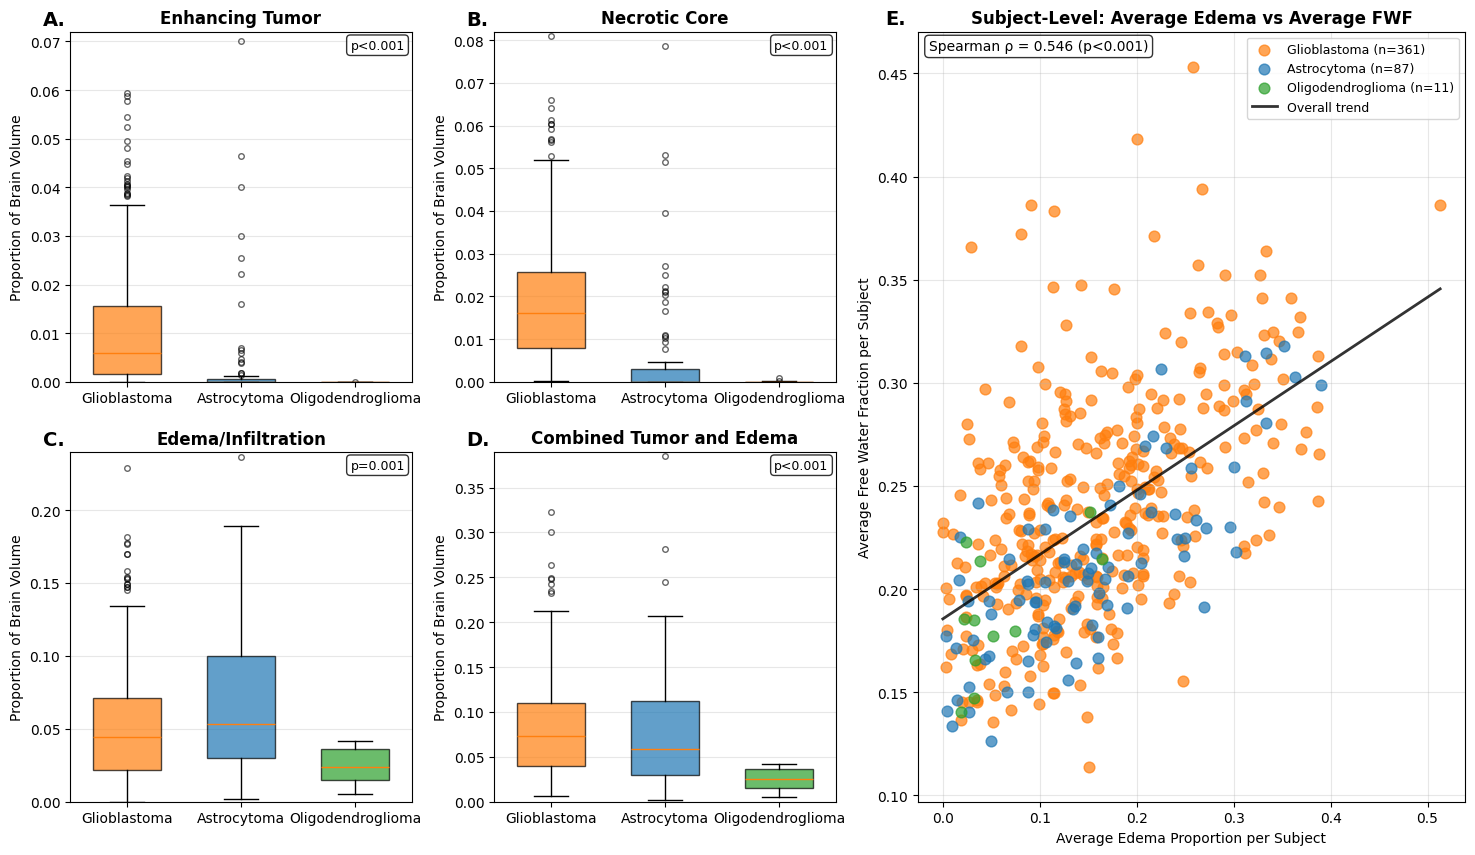

In [13]:
def create_combined_tumor_edema_plot():
    """
    Create combined plot: tumor volume box plots (A-D) + subject-level edema-FWF scatter (E)
    """
    
    # Load and prepare data for tumor volume plots
    final_patients = pd.read_csv('final_analysis_cohort.csv')
    final_participant_list = final_patients['participant'].tolist()
    metadata = pd.read_csv('UCSF-PDGM-metadata_v5_cleaned.csv')
    tracts = pd.read_csv('UCSF-PDGM-v5_profiles_20250819.csv')
    tumor_volumes = pd.read_csv('tumor_volumes.csv')

    # Convert metadata IDs to match tract format
    metadata['participant'] = 'sub-' + metadata['ID'].str.extract(r'UCSF-PDGM-(\d+)')[0].str.zfill(4)

    # Merge datasets and filter to final patients
    df = tracts.merge(metadata, on='participant', how='inner')
    df = df[df['participant'].isin(final_participant_list)]

    # =============================================================================
    # PREPARE TUMOR VOLUME DATA
    # =============================================================================
    subject_data = df.groupby('participant').agg({
        'Pathology': 'first'
    }).reset_index()

    # Process tumor volume data by component
    tumor_vol_pivot = tumor_volumes.pivot_table(
        index='participant', 
        columns='tumor_label', 
        values=['tumor_volume', 'p_tumor_volume'], 
        aggfunc='sum', 
        fill_value=0
    ).reset_index()

    # Flatten column names
    tumor_vol_pivot.columns = ['participant'] + [f'{metric}_{label}' for metric, label in tumor_vol_pivot.columns[1:]]

    # Rename columns to match tumor components
    volume_cols = {}
    if 'tumor_volume_1' in tumor_vol_pivot.columns:
        volume_cols['tumor_volume_1'] = 'enhancing_volume'
    if 'tumor_volume_2' in tumor_vol_pivot.columns:
        volume_cols['tumor_volume_2'] = 'edema_volume'
    if 'tumor_volume_4' in tumor_vol_pivot.columns:
        volume_cols['tumor_volume_4'] = 'necrotic_volume'
    if 'p_tumor_volume_1' in tumor_vol_pivot.columns:
        volume_cols['p_tumor_volume_1'] = 'p_enhancing_volume'
    if 'p_tumor_volume_2' in tumor_vol_pivot.columns:
        volume_cols['p_tumor_volume_2'] = 'p_edema_volume'
    if 'p_tumor_volume_4' in tumor_vol_pivot.columns:
        volume_cols['p_tumor_volume_4'] = 'p_necrotic_volume'

    tumor_vol_pivot = tumor_vol_pivot.rename(columns=volume_cols)

    # Add missing columns as zeros if they don't exist
    expected_cols = ['enhancing_volume', 'edema_volume', 'necrotic_volume', 
                    'p_enhancing_volume', 'p_edema_volume', 'p_necrotic_volume']
    for col in expected_cols:
        if col not in tumor_vol_pivot.columns:
            tumor_vol_pivot[col] = 0

    # Calculate total volumes
    tumor_vol_pivot['total_volume'] = tumor_vol_pivot[['enhancing_volume', 'edema_volume', 'necrotic_volume']].sum(axis=1)
    tumor_vol_pivot['p_total_volume'] = tumor_vol_pivot[['p_enhancing_volume', 'p_edema_volume', 'p_necrotic_volume']].sum(axis=1)

    # Merge with subject data
    plot_data_vol = subject_data.merge(tumor_vol_pivot, on='participant', how='left')
    plot_data_vol = plot_data_vol.dropna(subset=['Pathology', 'p_total_volume'])

    # Prepare volume data for plotting
    pathology_order = ['Glioblastoma', 'Astrocytoma', 'Oligodendroglioma']
    plot_data_vol = plot_data_vol[plot_data_vol['Pathology'].isin(pathology_order)]

    volume_data = []
    components = [
        ('p_enhancing_volume', 'Enhancing'),
        ('p_necrotic_volume', 'Necrotic'),
        ('p_edema_volume', 'Edema'), 
        ('p_total_volume', 'Combined')
    ]

    for _, row in plot_data_vol.iterrows():
        for vol_col, component_name in components:
            if pd.notna(row[vol_col]):
                volume_data.append({
                    'participant': row['participant'],
                    'pathology': row['Pathology'],
                    'component': component_name,
                    'proportion': row[vol_col]
                })

    volume_df = pd.DataFrame(volume_data)

    # =============================================================================
    # PREPARE EDEMA-FWF DATA
    # =============================================================================
    # Create analysis variables for edema
    df['hemisphere'] = df['tract'].str.extract('(Left|Right)')[0]
    df['tract_base'] = df['tract'].str.replace('Left|Right', '', regex=True)
    df['edema_involvement'] = (df['TUMOR-2'] > 0.05).astype(int)

    # Calculate tract-level edema proportion and mean FWF
    tract_data = []
    for (participant, tract), group in df.groupby(['participant', 'tract']):
        participant_info = group.iloc[0]
        
        edema_proportion = group['edema_involvement'].mean()
        mean_fwf = group['BELTRAMI-FWF'].mean()
        
        if pd.isna(mean_fwf):
            continue
        
        tract_data.append({
            'participant': participant,
            'tract': tract,
            'pathology': participant_info.get('Pathology', 'Unknown'),
            'edema_proportion': edema_proportion,
            'mean_fwf': mean_fwf
        })

    tract_df = pd.DataFrame(tract_data)

    # Calculate subject-level means for edema-FWF
    subject_level = tract_df.groupby('participant').agg({
        'edema_proportion': 'mean',
        'mean_fwf': 'mean',
        'pathology': 'first'
    }).reset_index()
    
    subject_level = subject_level.dropna(subset=['edema_proportion', 'mean_fwf', 'pathology'])

    # =============================================================================
    # CREATE COMBINED PLOT
    # =============================================================================
    fig = plt.figure(figsize=(18, 10))
    
    # Create grid: 2x3 layout (left 4 panels for volumes, right 1 panel for edema-FWF)
    gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1.6], hspace=0.2, wspace=0.2)
    
    # Colors for pathology types
    pathology_colors = {
        'Glioblastoma': '#ff7f0e',     # Orange
        'Astrocytoma': '#1f77b4',      # Blue  
        'Oligodendroglioma': '#2ca02c'  # Green
    }
    
    # Component order and titles for volume plots
    component_order = ['Enhancing', 'Necrotic', 'Edema', 'Combined']
    component_titles = {
        'Enhancing': 'Enhancing Tumor',
        'Necrotic': 'Necrotic Core',
        'Edema': 'Edema/Infiltration',
        'Combined': 'Combined Tumor and Edema'
    }
    
    # Custom y-limits for each component
    y_limits = {
        'Enhancing': 0.072,
        'Necrotic': 0.082,
        'Edema': 0.24,
        'Combined': 0.39
    }
    
    # Create volume box plots (A-D)
    for i, component in enumerate(component_order):
        row = i // 2
        col = i % 2
        ax = fig.add_subplot(gs[row, col])
        
        # Get data for this component
        comp_data = volume_df[volume_df['component'] == component]
        
        if comp_data.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(component_titles[component])
            continue
        
        # Create box plot with WIDER boxes
        box_plot = ax.boxplot(
            [comp_data[comp_data['pathology'] == p]['proportion'].values 
             for p in pathology_order if p in comp_data['pathology'].values],
            labels=[p for p in pathology_order if p in comp_data['pathology'].values],
            patch_artist=True,
            showfliers=True,
            flierprops=dict(marker='o', markersize=4, alpha=0.6),
            widths=0.6
        )
        
        # Color the boxes
        available_pathologies = [p for p in pathology_order if p in comp_data['pathology'].values]
        for patch, pathology in zip(box_plot['boxes'], available_pathologies):
            patch.set_facecolor(pathology_colors[pathology])
            patch.set_alpha(0.7)
        
        # Set custom y-axis limit
        ax.set_ylim(0, y_limits[component])
        
        # Formatting
        ax.set_title(component_titles[component], fontsize=12, fontweight='bold')
        ax.set_ylabel('Proportion of Brain Volume')
        ax.set_xlabel('')
        ax.grid(axis='y', alpha=0.3)
        
        # Add panel label
        panel_label = chr(65 + i) + '.'  # A., B., C., D.
        ax.text(-0.08, 1.02, panel_label, transform=ax.transAxes, fontsize=14, fontweight='bold')
        
        # Set x-axis labels HORIZONTALLY (no rotation)
        plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
        
        # Statistical comparison
        if len(available_pathologies) >= 2:
            groups = [comp_data[comp_data['pathology'] == p]['proportion'].values 
                     for p in available_pathologies]
            
            if all(len(g) > 0 for g in groups):
                try:
                    if len(available_pathologies) >= 3:
                        kw_stat, kw_p = kruskal(*groups)
                        if kw_p < 0.001:
                            p_text = "p<0.001"
                        else:
                            p_text = f"p={kw_p:.3f}"
                    else:
                        mw_stat, mw_p = mannwhitneyu(groups[0], groups[1], alternative='two-sided')
                        if mw_p < 0.001:
                            p_text = "p<0.001"
                        else:
                            p_text = f"p={mw_p:.3f}"
                    
                    # Add p-value to plot
                    ax.text(0.82, 0.98, p_text, transform=ax.transAxes, fontsize=9,
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                           verticalalignment='top')
                except:
                    pass
    
    # Create edema-FWF scatter plot (E)
    ax_scatter = fig.add_subplot(gs[:, 2])  # Span both rows in the third column
    
    # Filter to available pathologies and plot
    path_data = subject_level.dropna(subset=['pathology'])
    available_pathologies_scatter = [p for p in ['Glioblastoma', 'Astrocytoma','Oligodendroglioma'] 
                                   if p in path_data['pathology'].values]
    
    for pathology in available_pathologies_scatter:
        pathology_subset = path_data[path_data['pathology'] == pathology]
        ax_scatter.scatter(pathology_subset['edema_proportion'], pathology_subset['mean_fwf'],
                          label=f'{pathology} (n={len(pathology_subset)})', 
                          color=pathology_colors[pathology], alpha=0.7, s=60)
    
    # Add overall trend line
    x = subject_level['edema_proportion']
    y = subject_level['mean_fwf']
    coeffs = np.polyfit(x, y, 1)
    x_trend = np.linspace(x.min(), x.max(), 100)
    y_trend = np.polyval(coeffs, x_trend)
    ax_scatter.plot(x_trend, y_trend, 'k-', linewidth=2, alpha=0.8, label='Overall trend')
    
    # Calculate correlations
    subj_spearman_r, subj_spearman_p = spearmanr(subject_level['edema_proportion'], subject_level['mean_fwf'])
    
    ax_scatter.set_xlabel('Average Edema Proportion per Subject')
    ax_scatter.set_ylabel('Average Free Water Fraction per Subject')
    ax_scatter.set_title('Subject-Level: Average Edema vs Average FWF', fontweight='bold', fontsize=12)
    ax_scatter.legend(fontsize=9)
    ax_scatter.grid(True, alpha=0.3)
    
    # Add panel label E - moved down slightly
    ax_scatter.text(-0.06, 1.01, 'E.', transform=ax_scatter.transAxes, fontsize=14, fontweight='bold')
    
    # Add only Spearman correlation info in top left
    spearman_p_text = "p<0.001" if subj_spearman_p < 0.001 else f"p={subj_spearman_p:.4f}"
    
    ax_scatter.text(0.02, 0.99, f'Spearman ρ = {subj_spearman_r:.3f} ({spearman_p_text})',
                    transform=ax_scatter.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Run the combined analysis
create_combined_tumor_edema_plot()

## Sensitivity Analysis

SENSITIVITY ANALYSIS: TUMOR INVOLVEMENT THRESHOLD

Testing thresholds: ['1.0%', '2.5%', '5.0%', '7.5%', '10.0%', '15.0%']
Current threshold: 5.0%


Processing threshold: 1.0%...
  Mean tumor proportion: 0.201
  Unilateral cases: 2442
  Mean FA asymmetry: -6.34%

Processing threshold: 2.5%...
  Mean tumor proportion: 0.183
  Unilateral cases: 2356
  Mean FA asymmetry: -6.49%

Processing threshold: 5.0%...
  Mean tumor proportion: 0.166
  Unilateral cases: 2240
  Mean FA asymmetry: -6.75%

Processing threshold: 7.5%...
  Mean tumor proportion: 0.155
  Unilateral cases: 2176
  Mean FA asymmetry: -7.00%

Processing threshold: 10.0%...
  Mean tumor proportion: 0.146
  Unilateral cases: 2080
  Mean FA asymmetry: -7.29%

Processing threshold: 15.0%...
  Mean tumor proportion: 0.131
  Unilateral cases: 1887
  Mean FA asymmetry: -7.73%


SUMMARY: SENSITIVITY TO THRESHOLD CHOICE

 threshold  threshold_pct  mean_tumor_proportion  median_tumor_proportion
     0.010            1.0               0.2

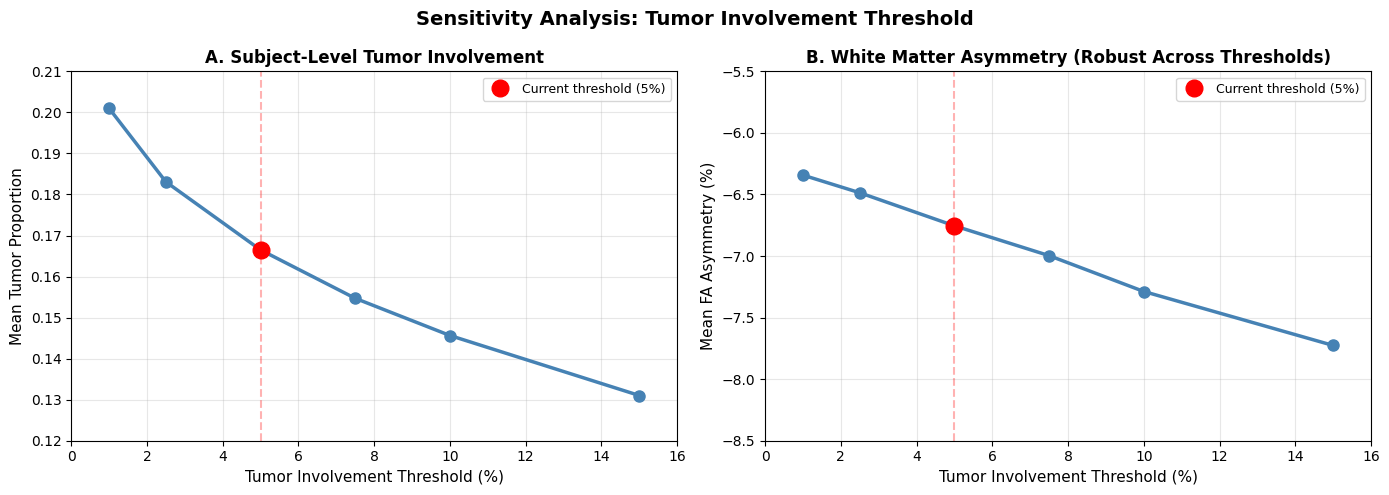


CONCLUSION

The 5% threshold balances sensitivity and specificity while maintaining robust
findings. Key observations:

1. Subject-level tumor involvement decreases with more stringent thresholds
   (expected behavior).

2. Mean FA asymmetry remains stable across thresholds from 2.5% to 10%,
   confirming the robustness of the main finding.

3. Results are not critically dependent on the specific threshold chosen.

Figures saved:
  - SupplementaryFigure_SensitivityAnalysis.png
  - SupplementaryFigure_SensitivityAnalysis.pdf



In [ ]:
print("="*80)
print("SENSITIVITY ANALYSIS: TUMOR INVOLVEMENT THRESHOLD")
print("="*80)

# Define thresholds to test
thresholds_to_test = [0.01, 0.025, 0.05, 0.075, 0.10, 0.15]
print(f"\nTesting thresholds: {[f'{t*100:.1f}%' for t in thresholds_to_test]}")
print(f"Current threshold: 5.0%\n")

# Store results
sensitivity_results = []
detailed_results = []

for threshold in thresholds_to_test:
    print(f"\nProcessing threshold: {threshold*100:.1f}%...")
    
    # Recalculate tumor_affected with new threshold
    df_temp = df.copy()
    df_temp['tumor_affected'] = (df_temp['any_tumor'] > threshold).astype(int)
    
    # ========================================================================
    # Part 1: Subject-level tumor involvement
    # ========================================================================
    subject_involvement = df_temp.groupby('participant').agg({
        'tumor_affected': 'sum',
        'participant': 'size'
    }).rename(columns={'participant': 'total_nodes'})
    subject_involvement['tumor_proportion'] = (
        subject_involvement['tumor_affected'] / subject_involvement['total_nodes']
    )
    
    mean_involvement = subject_involvement['tumor_proportion'].mean()
    median_involvement = subject_involvement['tumor_proportion'].median()
    
    # ========================================================================
    # Part 2: Identify unilateral cases and calculate asymmetry
    # ========================================================================
    bilateral_threshold = threshold
    unilateral_cases = []
    
    for participant in df_temp['participant'].unique():
        subj_data = df_temp[df_temp['participant'] == participant]
        participant_info = subj_data.iloc[0]
        
        for tract_base in subj_data['tract_base'].unique():
            left_tract = subj_data[(subj_data['tract_base'] == tract_base) & 
                                  (subj_data['hemisphere'] == 'Left')]
            right_tract = subj_data[(subj_data['tract_base'] == tract_base) & 
                                   (subj_data['hemisphere'] == 'Right')]
            
            if len(left_tract) == 0 or len(right_tract) == 0:
                continue
            
            left_tumor_prop = left_tract['tumor_affected'].mean()
            right_tumor_prop = right_tract['tumor_affected'].mean()
            
            is_left_unilateral = (left_tumor_prop > bilateral_threshold and 
                                 right_tumor_prop < bilateral_threshold)
            is_right_unilateral = (right_tumor_prop > bilateral_threshold and 
                                  left_tumor_prop < bilateral_threshold)
            
            if is_left_unilateral or is_right_unilateral:
                tumor_side = 'Left' if is_left_unilateral else 'Right'
                healthy_side = 'Right' if is_left_unilateral else 'Left'
                
                unilateral_cases.append({
                    'participant': participant,
                    'tract_base': tract_base,
                    'tumor_side': tumor_side,
                    'healthy_side': healthy_side,
                })
    
    unilateral_df_temp = pd.DataFrame(unilateral_cases)
    
    # Calculate FA asymmetry for unilateral cases
    if len(unilateral_df_temp) > 0 and 'BELTRAMI-FA' in df_temp.columns:
        asymmetry_data = []
        
        for _, case in unilateral_df_temp.iterrows():
            participant = case['participant']
            tract_base = case['tract_base']
            tumor_side = case['tumor_side']
            healthy_side = case['healthy_side']
            
            tumor_tract = df_temp[(df_temp['participant'] == participant) & 
                                (df_temp['tract_base'] == tract_base) & 
                                (df_temp['hemisphere'] == tumor_side)]
            healthy_tract = df_temp[(df_temp['participant'] == participant) & 
                                  (df_temp['tract_base'] == tract_base) & 
                                  (df_temp['hemisphere'] == healthy_side)]
            
            if len(tumor_tract) > 0 and len(healthy_tract) > 0:
                for node in tumor_tract['node'].unique():
                    tumor_node = tumor_tract[tumor_tract['node'] == node]
                    healthy_node = healthy_tract[healthy_tract['node'] == node]
                    
                    if len(tumor_node) > 0 and len(healthy_node) > 0:
                        tumor_val = tumor_node['BELTRAMI-FA'].values[0]
                        healthy_val = healthy_node['BELTRAMI-FA'].values[0]
                        
                        if not (pd.isna(tumor_val) or pd.isna(healthy_val)) and (tumor_val + healthy_val) != 0:
                            mean_val = (tumor_val + healthy_val) / 2
                            asymmetry = (tumor_val - healthy_val) / mean_val * 100
                            asymmetry_data.append(asymmetry)
        
        if len(asymmetry_data) > 10:
            mean_asymmetry = np.mean(asymmetry_data)
            median_asymmetry = np.median(asymmetry_data)
        else:
            mean_asymmetry = median_asymmetry = np.nan
    else:
        mean_asymmetry = median_asymmetry = np.nan
    
    # Store results
    sensitivity_results.append({
        'threshold': threshold,
        'threshold_pct': threshold * 100,
        'mean_tumor_proportion': mean_involvement,
        'median_tumor_proportion': median_involvement,
    })
    
    detailed_results.append({
        'threshold': threshold,
        'threshold_pct': threshold * 100,
        'n_unilateral_cases': len(unilateral_df_temp),
        'mean_asymmetry': mean_asymmetry,
        'median_asymmetry': median_asymmetry
    })
    
    print(f"  Mean tumor proportion: {mean_involvement:.3f}")
    print(f"  Unilateral cases: {len(unilateral_df_temp)}")
    if not np.isnan(mean_asymmetry):
        print(f"  Mean FA asymmetry: {mean_asymmetry:.2f}%")

# Create summary dataframes
sensitivity_df = pd.DataFrame(sensitivity_results)
detailed_df = pd.DataFrame(detailed_results)

print(f"\n\n{'='*80}")
print("SUMMARY: SENSITIVITY TO THRESHOLD CHOICE")
print(f"{'='*80}\n")
print(sensitivity_df.to_string(index=False))
print("\n")
print(detailed_df.to_string(index=False))

# ============================================================================
# Create Figure
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Sensitivity Analysis: Tumor Involvement Threshold', 
             fontsize=14, fontweight='bold', y=0.98)

highlight_idx_sens = sensitivity_df['threshold'] == 0.05
highlight_idx_det = detailed_df['threshold'] == 0.05

# Panel A - Direct Tumor Involvement (Mean only)
ax1.plot(sensitivity_df['threshold_pct'], sensitivity_df['mean_tumor_proportion'], 
        'o-', linewidth=2.5, markersize=8, color='steelblue')
ax1.plot(sensitivity_df.loc[highlight_idx_sens, 'threshold_pct'], 
        sensitivity_df.loc[highlight_idx_sens, 'mean_tumor_proportion'], 
        'o', markersize=12, color='red', zorder=5, label='Current threshold (5%)')
ax1.axvline(x=5, color='red', linestyle='--', alpha=0.3, linewidth=1.5)

ax1.set_xlabel('Tumor Involvement Threshold (%)', fontsize=11)
ax1.set_ylabel('Mean Tumor Proportion', fontsize=11)
ax1.set_title('A. Subject-Level Tumor Involvement', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 16])
ax1.set_ylim([0.12, 0.21])

# Panel B - White Matter Asymmetry (Mean only)
valid_asym = detailed_df[detailed_df['mean_asymmetry'].notna()]

if len(valid_asym) > 0:
    ax2.plot(valid_asym['threshold_pct'], valid_asym['mean_asymmetry'], 
            'o-', linewidth=2.5, markersize=8, color='steelblue')
    
    current_asym = valid_asym[valid_asym['threshold'] == 0.05]
    if len(current_asym) > 0:
        ax2.plot(current_asym['threshold_pct'], current_asym['mean_asymmetry'], 
                'o', markersize=12, color='red', zorder=5, label='Current threshold (5%)')
    
    ax2.axvline(x=5, color='red', linestyle='--', alpha=0.3, linewidth=1.5)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.15, linewidth=1)
    
    ax2.set_xlabel('Tumor Involvement Threshold (%)', fontsize=11)
    ax2.set_ylabel('Mean FA Asymmetry (%)', fontsize=11)
    ax2.set_title('B. White Matter Asymmetry (Robust Across Thresholds)', 
                 fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9, loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, 16])
    ax2.set_ylim([-8.5, -5.5])
else:
    ax2.text(0.5, 0.5, 'Asymmetry data not available', 
            ha='center', va='center', transform=ax2.transAxes)
    ax2.set_xlabel('Tumor Involvement Threshold (%)', fontsize=11)
    ax2.set_ylabel('Mean FA Asymmetry (%)', fontsize=11)
    ax2.set_title('B. White Matter Asymmetry (Robust Across Thresholds)', 
                 fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()